In [1]:
if "run_once" not in get_ipython().user_ns:
    %cd ..
    get_ipython().user_ns["run_once"] = True

/home/chamara/Documents/projects/1-poisoning-xai


In [3]:
import flwr as fl
import torch

%matplotlib inline
import importlib

from src.FLProcess.CustomFedAvg import CustomFedAvg
from src.FLProcess.FLUtil import weighted_average
from src.FLProcess.FlowerClient import FlowerClient
from src.NN.NNConfig import get_nn
from src.dataset import dataLoaderFactory
from src.dataset.datasetStrategy import poison_strategy_with_non_iid_split, poison_strategy_for_multi_label_split
from src.poisonDetection.clientAnalysis.strategyFnGeneralAlg import client_analysis_fn_general_alg
from src.poisonDetection.clientAnalysis.strategyFnDebugging import client_analysis_strategy_fn_debugging
from src.poisonDetection.clientAnalysis.strategyFnRandomPoison import client_analysis_strategy_fn_random_poison
from util import constants
from src.NN import NNUtil
import numpy as np

import time

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
print(
    f"Training on {constants.DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.1+cu117 and Flower 1.5.0


In [6]:
def set_constants(num_clients=10, selected_dataset='MNIST'):
    constants.NUM_CLIENTS = num_clients
    constants.SELECTED_DATASET = selected_dataset

In [7]:
set_constants(num_clients=10,selected_dataset='MNIST')

In [8]:
kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3,4,5]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = dataLoaderFactory.generate_data_loaders(kwargs_train, kwargs_val,
                          strategy=poison_strategy_with_non_iid_split,
                          len_train_data=10000, len_test_data=1000,
                          random_ratio=1, is_visualize=False,
                          visualize_idx=0)

MNIST
10000
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
performing random poisoning of labels
processing client:  2
performing random poisoning of labels
processing client:  3
performing random poisoning of labels
processing client:  4
performing random poisoning of labels
processing client:  5
performing random poisoning of labels
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for cl

In [9]:
def client_fn(cid) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    net = get_nn()
    net.to(constants.DEVICE)
    # trainloaders, valloaders, _ = get_train_val_test_loaders()
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

## When poisoners are removed

INFO flwr 2024-02-05 01:31:39,417 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-05 01:31:44,230	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2024-02-05 01:31:45,235 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 33931207065.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'CPU': 10.0, 'memory': 69172816487.0, 'accelerator_type:RTX': 1.0, 'node:193.1.133.164': 1.0}
INFO flwr 2024-02-05 01:31:45,236 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2024-02-05 01:31:45,272 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2024-02-05 01:31:45,274 | server.py:89 | Initializing global parameters
INFO flwr 2024-02-05 01:31:45,275 | CustomFedAvg.py:85 | Attempting to initialize parameters
INFO flwr 2024-02-05 01:31:45,276 | server.py:276 | Request

Attempting to initialize parameters


INFO flwr 2024-02-05 01:31:52,481 | server.py:280 | Received initial parameters from one random client
INFO flwr 2024-02-05 01:31:52,482 | server.py:91 | Evaluating initial parameters
INFO flwr 2024-02-05 01:31:52,484 | server.py:104 | FL starting
DEBUG flwr 2024-02-05 01:31:52,485 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:32:01,916 | server.py:236 | fit_round 1 received 10 results and 0 failures


total selecting features:  10


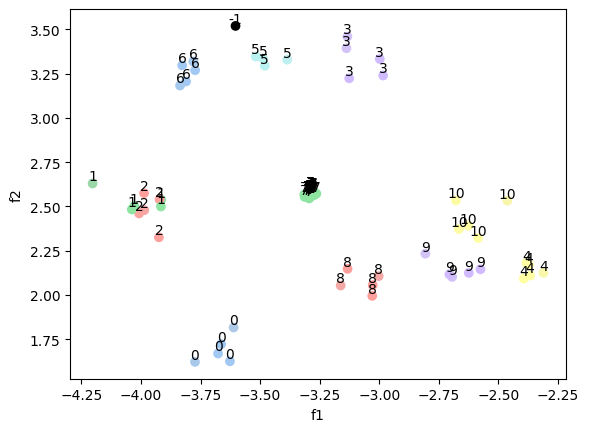

WARNING flwr 2024-02-05 01:32:09,904 | CustomFedAvg.py:147 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2024-02-05 01:32:09,905 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


['1', '4', '9', '3', '7', '8', '0', '5', '6', '2']
{-1: [29], 0: [21, 41, 51, 61, 81], 1: [26, 46, 56, 66, 86], 2: [22, 42, 52, 62, 82], 3: [27, 47, 57, 67, 87], 4: [20, 40, 50, 60, 80], 5: [49, 59, 69, 89], 6: [24, 44, 54, 64, 84], 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 8: [28, 48, 58, 68, 88], 9: [25, 45, 55, 65, 85], 10: [23, 43, 53, 63, 83]}
-1
All cluster features are the same: -1
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 31, 32, 33, 34, 35, 36, 37, 38, 3

DEBUG flwr 2024-02-05 01:32:16,703 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:32:16,705 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:32:23,544 | server.py:236 | fit_round 2 received 10 results and 0 failures


total selecting features:  10


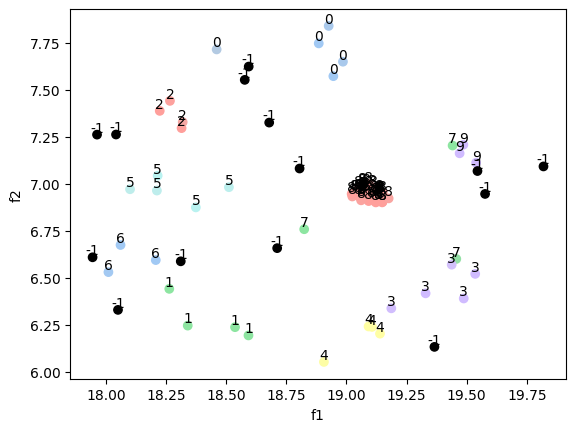

DEBUG flwr 2024-02-05 01:32:31,540 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)


['3', '1', '9', '8', '7', '2', '5', '0', '4', '6']
{-1: [22, 32, 33, 34, 38, 42, 44, 46, 47, 48, 72, 90, 92, 93], 0: [21, 31, 41, 71, 91], 1: [26, 36, 76, 96], 2: [27, 37, 77, 97], 3: [25, 35, 45, 75, 95], 4: [20, 30, 40, 70], 5: [29, 39, 49, 79, 99], 6: [24, 74, 94], 7: [28, 78, 98], 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 9: [23, 43, 73]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [33, 34, 38, 44, 46, 47, 48, 90, 93]
[22, 32, 33, 34, 38, 42, 44, 46, 47, 48, 72, 90, 92, 93]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
Not all 

DEBUG flwr 2024-02-05 01:32:37,931 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:32:37,933 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:32:44,627 | server.py:236 | fit_round 3 received 10 results and 0 failures


total selecting features:  10


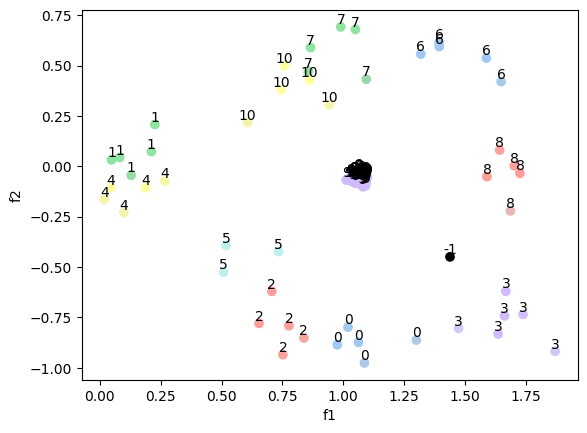

DEBUG flwr 2024-02-05 01:32:54,351 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)


['5', '2', '7', '6', '3', '9', '8', '1', '4', '0']
{-1: [29], 0: [21, 31, 51, 61, 91], 1: [26, 36, 56, 66, 96], 2: [22, 32, 52, 62, 92], 3: [27, 37, 39, 57, 67, 97], 4: [24, 34, 54, 64, 94], 5: [59, 69, 99], 6: [20, 30, 50, 60, 90], 7: [25, 35, 55, 65, 95], 8: [23, 33, 53, 63, 93], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 10: [28, 38, 58, 68, 98]}
-1
All cluster features are the same: -1
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
Not all features are the same. Possible poisoning
Cluster with different features: [39]
[27, 37, 39, 57, 67, 97]
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the s

DEBUG flwr 2024-02-05 01:33:00,808 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:33:00,811 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:33:07,480 | server.py:236 | fit_round 4 received 10 results and 0 failures


total selecting features:  10


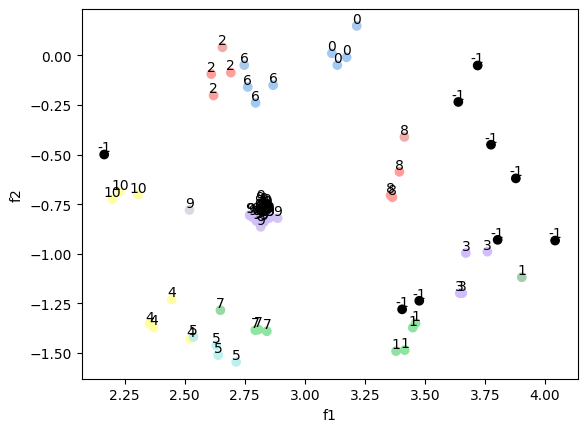

DEBUG flwr 2024-02-05 01:33:18,009 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)


['0', '1', '8', '6', '4', '7', '9', '3', '2', '5']
{-1: [30, 31, 32, 34, 35, 37, 38, 39, 63], 0: [7, 27, 57, 67], 1: [6, 26, 36, 56, 66], 2: [1, 21, 51, 61], 3: [4, 24, 54, 64], 4: [0, 20, 50, 60], 5: [5, 25, 55, 65], 6: [2, 22, 52, 62], 7: [8, 28, 58, 68], 8: [9, 29, 59, 69], 9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 33, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 10: [3, 23, 53]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [31, 32, 34, 35, 37, 38, 39, 63]
[30, 31, 32, 34, 35, 37, 38, 39, 63]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are t

DEBUG flwr 2024-02-05 01:33:24,636 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:33:24,638 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:33:31,526 | server.py:236 | fit_round 5 received 10 results and 0 failures


total selecting features:  10


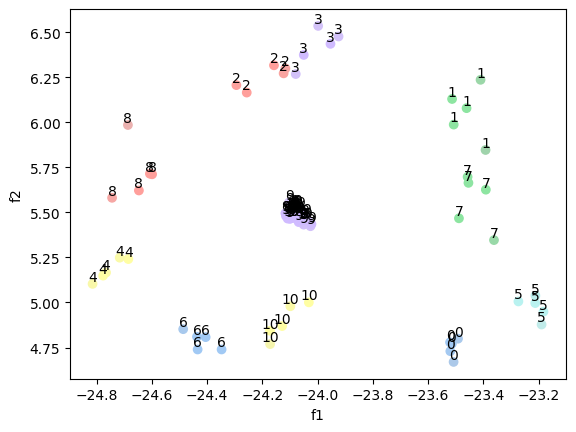

DEBUG flwr 2024-02-05 01:33:41,521 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)


['1', '3', '8', '6', '4', '5', '2', '0', '7', '9']
{0: [26, 36, 76, 86, 96], 1: [21, 31, 71, 81, 91], 2: [22, 32, 72, 82, 92], 3: [27, 37, 77, 87, 97], 4: [20, 30, 70, 80, 90], 5: [24, 34, 74, 84, 94], 6: [25, 35, 75, 85, 95], 7: [29, 39, 79, 89, 99], 8: [23, 33, 73, 83, 93], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], 10: [28, 38, 78, 88, 98]}
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 41

DEBUG flwr 2024-02-05 01:33:48,241 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:33:48,242 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:33:54,825 | server.py:236 | fit_round 6 received 10 results and 0 failures


total selecting features:  10


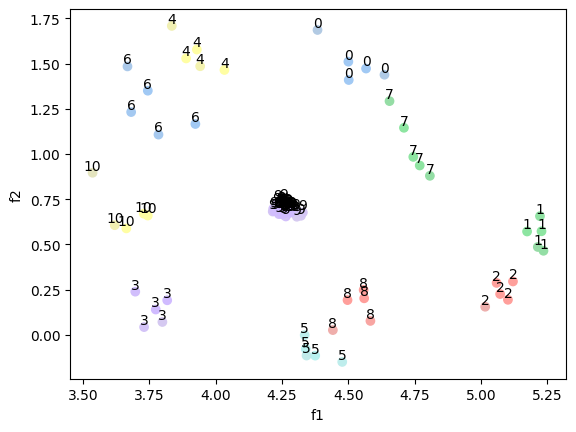

DEBUG flwr 2024-02-05 01:34:05,412 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)


['1', '0', '8', '7', '3', '2', '5', '4', '9', '6']
{0: [11, 21, 31, 81, 91], 1: [14, 24, 34, 84, 94], 2: [16, 26, 36, 86, 96], 3: [10, 20, 30, 80, 90], 4: [17, 27, 37, 87, 97], 5: [15, 25, 35, 85, 95], 6: [12, 22, 32, 82, 92], 7: [19, 29, 39, 89, 99], 8: [18, 28, 38, 88, 98], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], 10: [13, 23, 33, 83, 93]}
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51

DEBUG flwr 2024-02-05 01:34:11,867 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:34:11,869 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:34:18,819 | server.py:236 | fit_round 7 received 10 results and 0 failures


total selecting features:  10


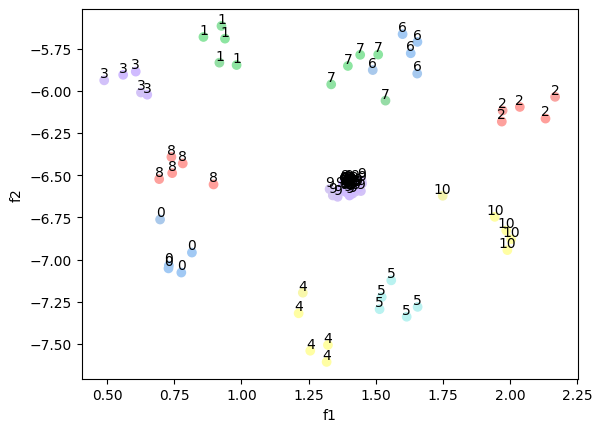

DEBUG flwr 2024-02-05 01:34:28,453 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)


['9', '7', '2', '4', '0', '3', '6', '1', '8', '5']
{0: [1, 11, 41, 61, 81], 1: [6, 16, 46, 66, 86], 2: [0, 10, 40, 60, 80], 3: [4, 14, 44, 64, 84], 4: [7, 17, 47, 67, 87], 5: [2, 12, 42, 62, 82], 6: [5, 15, 45, 65, 85], 7: [8, 18, 48, 68, 88], 8: [9, 19, 49, 69, 89], 9: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 10: [3, 13, 43, 63, 83]}
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 3

DEBUG flwr 2024-02-05 01:34:34,884 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:34:34,886 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:34:41,815 | server.py:236 | fit_round 8 received 10 results and 0 failures


total selecting features:  10


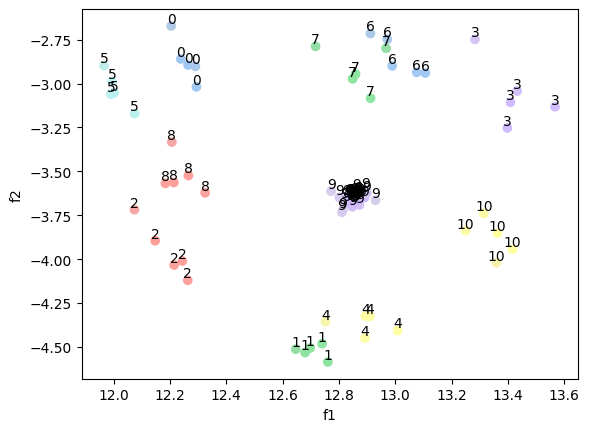

DEBUG flwr 2024-02-05 01:34:50,130 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)


['7', '9', '0', '4', '2', '8', '5', '3', '1', '6']
{0: [6, 16, 26, 56, 96], 1: [7, 17, 27, 57, 97], 2: [1, 11, 21, 51, 91], 3: [0, 10, 20, 50, 90], 4: [2, 12, 22, 52, 92], 5: [4, 14, 24, 54, 94], 6: [5, 15, 25, 55, 95], 7: [8, 18, 28, 58, 98], 8: [9, 19, 29, 59, 99], 9: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 10: [3, 13, 23, 53, 93]}
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 4

DEBUG flwr 2024-02-05 01:34:56,544 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:34:56,546 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:35:02,884 | server.py:236 | fit_round 9 received 10 results and 0 failures


total selecting features:  10


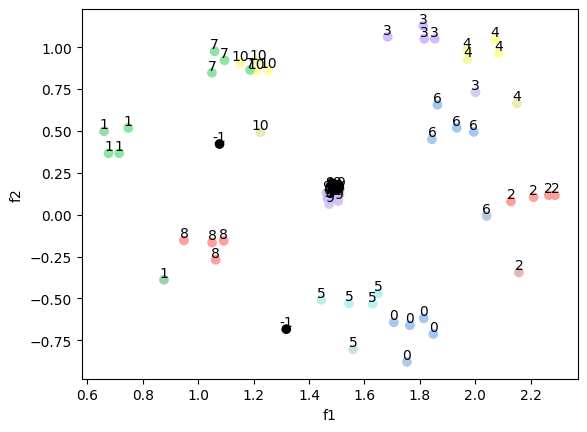

DEBUG flwr 2024-02-05 01:35:13,214 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)


['6', '8', '2', '5', '0', '9', '7', '4', '3', '1']
{-1: [13, 15], 0: [7, 17, 47, 57, 67], 1: [0, 10, 40, 50, 60], 2: [1, 11, 41, 51, 61], 3: [6, 16, 46, 56, 66], 4: [4, 14, 44, 54, 64], 5: [2, 12, 42, 52, 62], 6: [9, 19, 49, 59, 69], 7: [5, 45, 55, 65], 8: [3, 43, 53, 63], 9: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 10: [8, 18, 48, 58, 68]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [15]
[13, 15]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poi

DEBUG flwr 2024-02-05 01:35:19,627 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:35:19,629 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:35:26,554 | server.py:236 | fit_round 10 received 10 results and 0 failures


total selecting features:  10


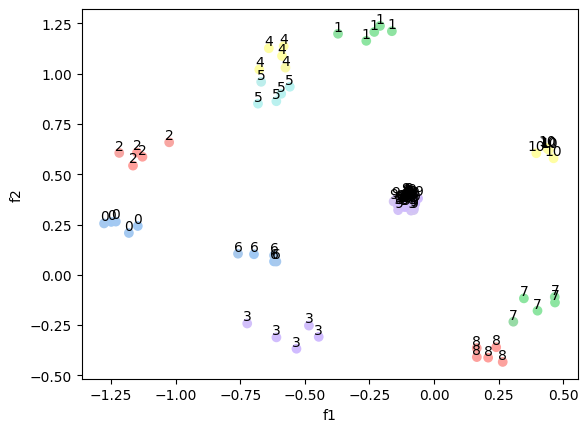

DEBUG flwr 2024-02-05 01:35:36,280 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)


['6', '9', '0', '2', '8', '4', '1', '5', '3', '7']
{0: [4, 14, 24, 44, 94], 1: [0, 10, 20, 40, 90], 2: [6, 16, 26, 46, 96], 3: [1, 11, 21, 41, 91], 4: [5, 15, 25, 45, 95], 5: [8, 18, 28, 48, 98], 6: [9, 19, 29, 49, 99], 7: [2, 12, 22, 42, 92], 8: [7, 17, 27, 47, 97], 9: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 10: [3, 13, 23, 43, 93]}
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [31, 32, 33, 34, 35, 36, 37, 38, 39, 51, 52, 53, 54, 55, 56, 57, 5

DEBUG flwr 2024-02-05 01:35:42,818 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2024-02-05 01:35:42,820 | server.py:153 | FL finished in 230.33519159490243
INFO flwr 2024-02-05 01:35:42,821 | app.py:225 | app_fit: losses_distributed [(1, 0.05840806186199189), (2, 0.027156583935022356), (3, 0.016624559365212916), (4, 0.015002610821276904), (5, 0.012134010937064886), (6, 0.0111682944977656), (7, 0.009126865920610724), (8, 0.007985149391926825), (9, 0.008044105191715062), (10, 0.0070552994646132005)]
INFO flwr 2024-02-05 01:35:42,822 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2024-02-05 01:35:42,823 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.692), (2, 0.8039999999999999), (3, 0.876), (4, 0.889), (5, 0.916), (6, 0.9109999999999999), (7, 0.9320000000000002), (8, 0.9350000000000002), (9, 0.9359999999999999), (10, 0.945)]}
INFO flwr 2024-02-05 01:35:42,824 | app.py:228 | app_fit: losses_centralized []
INFO flwr 2024-02

In [12]:
client_updates_list = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':True}


strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

## Without removing poisoners

INFO flwr 2024-02-05 01:39:04,189 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-05 01:39:09,177	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2024-02-05 01:39:10,258 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 67900278580.0, 'GPU': 1.0, 'CPU': 10.0, 'object_store_memory': 33385833676.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0}
INFO flwr 2024-02-05 01:39:10,260 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2024-02-05 01:39:10,295 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2024-02-05 01:39:10,298 | server.py:89 | Initializing global parameters
INFO flwr 2024-02-05 01:39:10,299 | CustomFedAvg.py:85 | Attempting to initialize parameters
INFO flwr 2024-02-05 01:39:10,300 | server.py:276 | Request

Attempting to initialize parameters


INFO flwr 2024-02-05 01:39:17,610 | server.py:280 | Received initial parameters from one random client
INFO flwr 2024-02-05 01:39:17,612 | server.py:91 | Evaluating initial parameters
INFO flwr 2024-02-05 01:39:17,613 | server.py:104 | FL starting
DEBUG flwr 2024-02-05 01:39:17,614 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:39:27,397 | server.py:236 | fit_round 1 received 10 results and 0 failures


total selecting features:  10


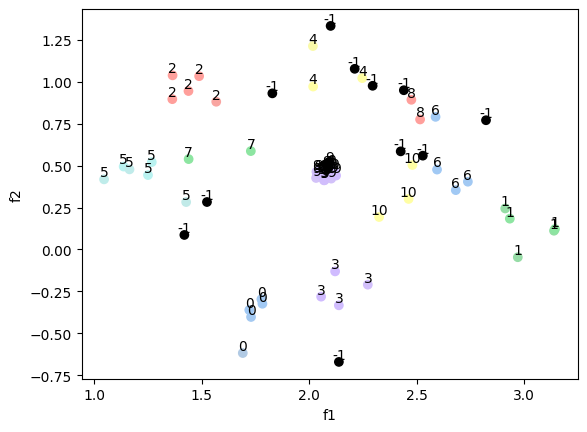

WARNING flwr 2024-02-05 01:39:35,468 | CustomFedAvg.py:147 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2024-02-05 01:39:35,473 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


['2', '5', '1', '9', '3', '6', '4', '7', '8', '0']
{-1: [32, 33, 38, 72, 75, 78, 79, 95, 97, 98, 99], 0: [31, 51, 71, 81, 91], 1: [30, 50, 70, 80, 90], 2: [36, 56, 76, 86, 96], 3: [37, 57, 77, 87], 4: [52, 82, 92], 5: [34, 54, 74, 84, 89, 94], 6: [53, 73, 83, 93], 7: [39, 59], 8: [58, 88], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], 10: [35, 55, 85]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [33, 38, 75, 78, 79, 95, 97, 98, 99]
[32, 33, 38, 72, 75, 78, 79, 95, 97, 98, 99]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
Not all features are the same. Possible poisoning
Cluster with different features: [89]
[34, 54, 74, 84, 89, 94]
6
All cluster feat

DEBUG flwr 2024-02-05 01:39:41,869 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:39:41,871 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:39:48,479 | server.py:236 | fit_round 2 received 10 results and 0 failures


total selecting features:  10


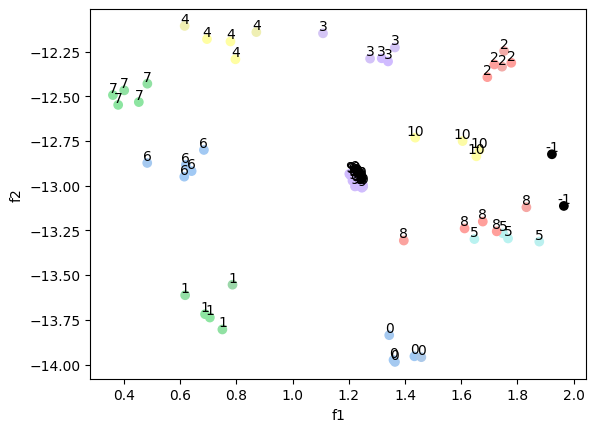

DEBUG flwr 2024-02-05 01:39:56,597 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)


['6', '5', '7', '0', '2', '8', '4', '3', '9', '1']
{-1: [3, 8], 0: [0, 20, 30, 50, 80], 1: [7, 27, 37, 57, 87], 2: [1, 21, 31, 51, 81], 3: [2, 22, 32, 52, 82], 4: [6, 26, 36, 56, 86], 5: [23, 33, 53, 83], 6: [9, 29, 39, 59, 89], 7: [4, 24, 34, 54, 84], 8: [5, 25, 35, 55, 85], 9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 10: [28, 38, 58, 88]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [8]
[3, 8]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poison

DEBUG flwr 2024-02-05 01:40:03,060 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:40:03,062 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:40:09,746 | server.py:236 | fit_round 3 received 10 results and 0 failures


total selecting features:  10


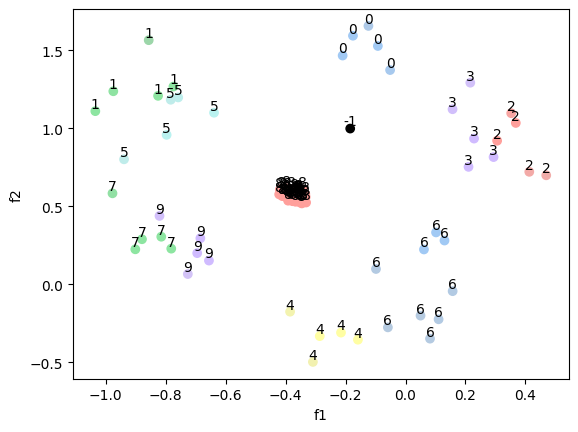

DEBUG flwr 2024-02-05 01:40:18,174 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)


['2', '3', '1', '8', '7', '0', '5', '4', '6', '9']
{-1: [49], 0: [37, 47, 57, 87, 97], 1: [30, 40, 50, 80, 90], 2: [31, 41, 51, 81, 91], 3: [32, 42, 52, 82, 92], 4: [36, 46, 56, 86, 96], 5: [33, 43, 53, 83, 93], 6: [34, 39, 44, 54, 59, 84, 89, 94, 99], 7: [35, 45, 55, 85, 95], 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], 9: [38, 48, 58, 88, 98]}
-1
All cluster features are the same: -1
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
Not all features are the same. Possible poisoning
Cluster with different features: [39, 59, 89, 99]
[34, 39, 44, 54, 59, 84, 89, 94, 99]
7
All cluster features are the same: 7
8
Not all features are the same. Possible poisoni

DEBUG flwr 2024-02-05 01:40:24,647 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:40:24,649 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:40:31,344 | server.py:236 | fit_round 4 received 10 results and 0 failures


total selecting features:  10


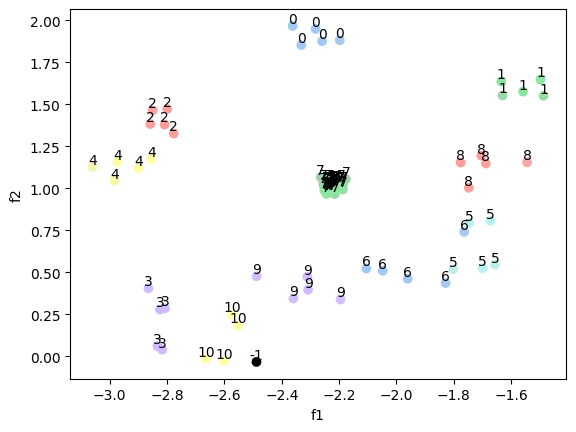

DEBUG flwr 2024-02-05 01:40:39,007 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)


['9', '8', '4', '2', '6', '1', '7', '0', '3', '5']
{-1: [4], 0: [7, 17, 47, 67, 77], 1: [0, 10, 40, 60, 70], 2: [2, 12, 42, 62, 72], 3: [6, 16, 46, 66, 76], 4: [1, 11, 41, 61, 71], 5: [5, 15, 45, 65, 75], 6: [8, 18, 48, 68, 78], 7: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 8: [3, 13, 43, 63, 73], 9: [9, 19, 49, 69, 79], 10: [14, 44, 64, 74]}
-1
All cluster features are the same: -1
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 51, 52, 53, 54, 55, 56, 

DEBUG flwr 2024-02-05 01:40:45,384 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:40:45,386 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:40:52,375 | server.py:236 | fit_round 5 received 10 results and 0 failures


total selecting features:  10


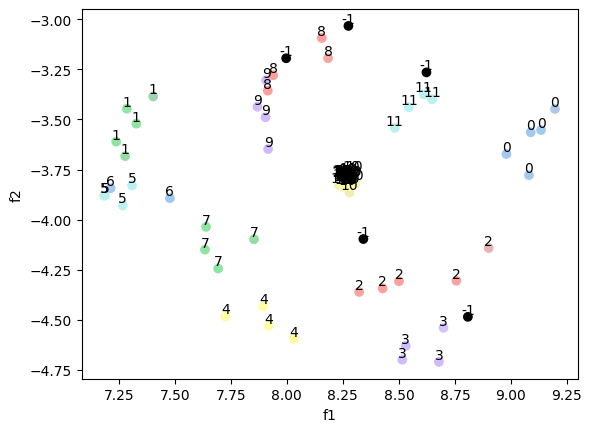

DEBUG flwr 2024-02-05 01:41:00,182 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)


['8', '5', '2', '0', '6', '1', '7', '4', '3', '9']
{-1: [41, 43, 45, 47, 48], 0: [0, 30, 40, 60, 90], 1: [6, 36, 46, 66, 96], 2: [2, 32, 42, 62, 92], 3: [7, 37, 67, 97], 4: [1, 31, 61, 91], 5: [4, 34, 64, 94], 6: [44, 49], 7: [9, 39, 69, 99], 8: [5, 35, 65, 95], 9: [8, 38, 68, 98], 10: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 11: [3, 33, 63, 93]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [43, 45, 47, 48]
[41, 43, 45, 47, 48]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
Not all features are the same. Possible poisoning
Cluster with different features: [49]
[44, 49]
7
All cluster features are the sa

DEBUG flwr 2024-02-05 01:41:06,274 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:41:06,275 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:41:13,053 | server.py:236 | fit_round 6 received 10 results and 0 failures


total selecting features:  10


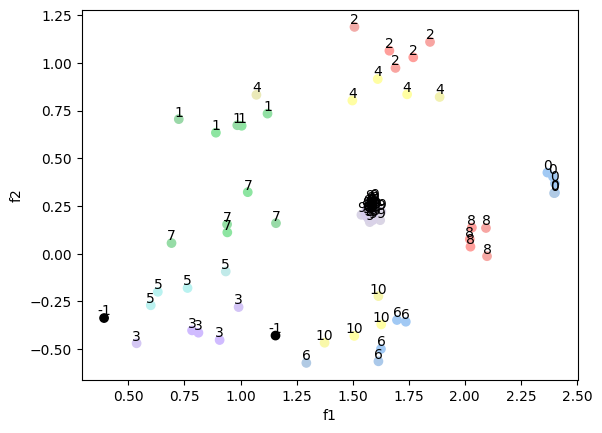

DEBUG flwr 2024-02-05 01:41:20,856 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)


['1', '0', '3', '4', '5', '2', '8', '7', '6', '9']
{-1: [94, 98], 0: [10, 60, 70, 80, 90], 1: [11, 61, 71, 81, 91], 2: [17, 67, 77, 87, 97], 3: [16, 66, 76, 86, 96], 4: [12, 62, 72, 82, 92], 5: [14, 64, 74, 84], 6: [15, 65, 75, 85, 95], 7: [19, 69, 79, 89, 99], 8: [13, 63, 73, 83, 93], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 10: [18, 68, 78, 88]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [98]
[94, 98]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poi

DEBUG flwr 2024-02-05 01:41:27,287 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:41:27,289 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:41:34,165 | server.py:236 | fit_round 7 received 10 results and 0 failures


total selecting features:  10


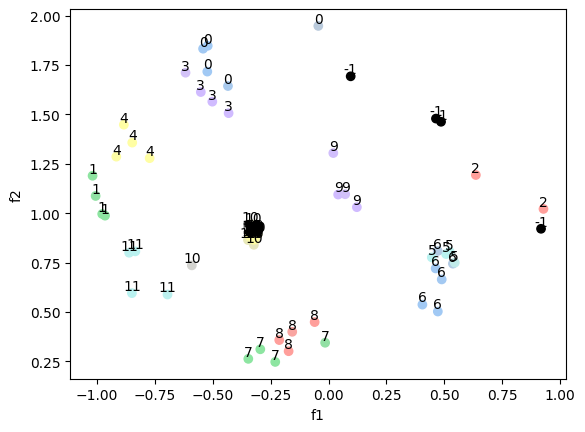

DEBUG flwr 2024-02-05 01:41:42,036 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)


['7', '3', '1', '8', '9', '2', '5', '4', '6', '0']
{-1: [30, 31, 32, 36], 0: [7, 37, 47, 87, 97], 1: [1, 41, 81, 91], 2: [34, 39], 3: [0, 40, 80, 90], 4: [2, 42, 82, 92], 5: [4, 44, 84, 94], 6: [6, 35, 38, 46, 86, 96], 7: [8, 48, 88, 98], 8: [5, 45, 85, 95], 9: [9, 49, 89, 99], 10: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], 11: [3, 43, 83, 93]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [31, 32, 36]
[30, 31, 32, 36]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
Not all features are the same. Possible poisoning
Cluster with different features: [39]
[34, 39]
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
Not all features are the same. Possible poisoning
Cluster with different featu

DEBUG flwr 2024-02-05 01:41:48,480 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:41:48,481 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:41:55,360 | server.py:236 | fit_round 8 received 10 results and 0 failures


total selecting features:  10


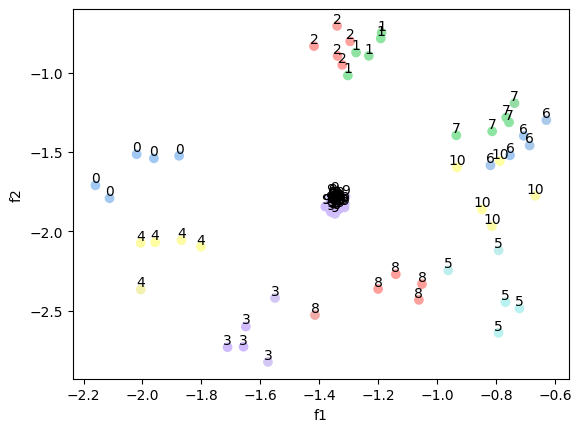

DEBUG flwr 2024-02-05 01:42:03,242 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)


['5', '4', '8', '3', '7', '0', '6', '2', '9', '1']
{0: [21, 41, 51, 61, 81], 1: [24, 44, 54, 64, 84], 2: [26, 46, 56, 66, 86], 3: [27, 47, 57, 67, 87], 4: [22, 42, 52, 62, 82], 5: [20, 40, 50, 60, 80], 6: [25, 45, 55, 65, 85], 7: [28, 48, 58, 68, 88], 8: [23, 43, 53, 63, 83], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 10: [29, 49, 59, 69, 89]}
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 31

DEBUG flwr 2024-02-05 01:42:09,841 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:42:09,843 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:42:16,424 | server.py:236 | fit_round 9 received 10 results and 0 failures


total selecting features:  10


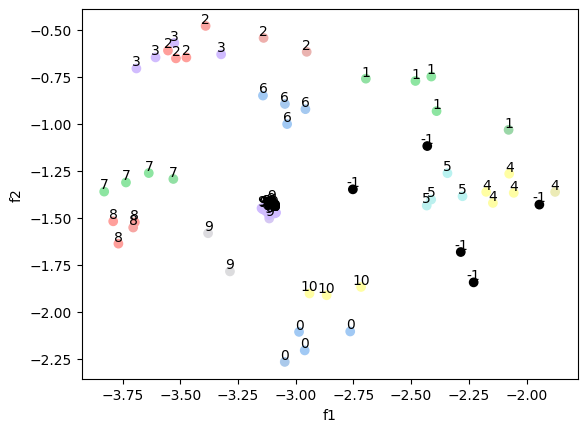

DEBUG flwr 2024-02-05 01:42:24,129 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)


['2', '7', '4', '9', '1', '0', '3', '5', '6', '8']
{-1: [90, 92, 93, 98, 99], 0: [10, 30, 50, 80], 1: [11, 31, 51, 81, 91], 2: [14, 34, 54, 84, 94, 96], 3: [16, 36, 56, 86], 4: [17, 37, 57, 87, 97], 5: [12, 32, 52, 82], 6: [19, 39, 59, 89], 7: [18, 38, 58, 88], 8: [15, 35, 55, 85], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83, 95], 10: [13, 33, 53]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [92, 93, 98, 99]
[90, 92, 93, 98, 99]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
Not all features are the same. Possible poisoning
Cluster with different features: [96]
[14, 34, 54, 84, 94, 96]
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features 

DEBUG flwr 2024-02-05 01:42:30,551 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2024-02-05 01:42:30,553 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2024-02-05 01:42:37,198 | server.py:236 | fit_round 10 received 10 results and 0 failures


total selecting features:  10


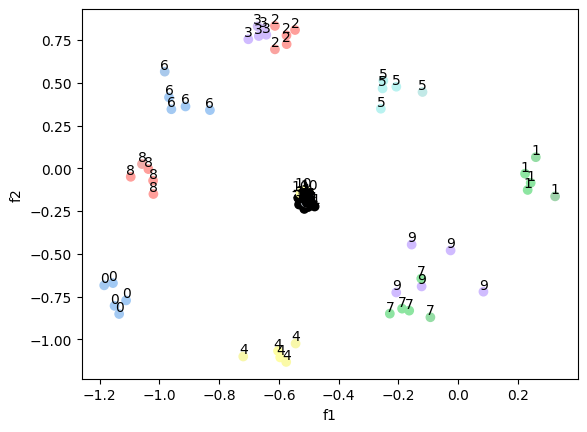

DEBUG flwr 2024-02-05 01:42:45,424 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)


['9', '0', '5', '3', '2', '4', '1', '7', '6', '8']
{-1: [22, 26, 29, 40, 42, 43, 44, 47, 48, 49, 51, 54, 56, 60, 61, 62, 63, 65, 66, 67, 68, 69], 0: [0, 10, 70, 80, 90], 1: [1, 11, 71, 81, 91], 2: [4, 14, 74, 84, 94], 3: [6, 16, 76, 86, 96], 4: [7, 17, 77, 87, 97], 5: [8, 18, 78, 88, 98], 6: [5, 15, 75, 85, 95], 7: [2, 12, 72, 82, 92], 8: [9, 19, 79, 89, 99], 9: [3, 13, 73, 83, 93], 10: [41, 45, 46], 11: [21, 24, 28], 12: [20, 23, 25, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 50, 52, 59, 64], 13: [53, 55, 57, 58]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [26, 29, 40, 43, 44, 47, 48, 49, 51, 54, 56, 60, 61, 63, 65, 66, 67, 68, 69]
[22, 26, 29, 40, 42, 43, 44, 47, 48, 49, 51, 54, 56, 60, 61, 62, 63, 65, 66, 67, 68, 69]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the 

DEBUG flwr 2024-02-05 01:42:52,148 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2024-02-05 01:42:52,150 | server.py:153 | FL finished in 214.5363628969062
INFO flwr 2024-02-05 01:42:52,151 | app.py:225 | app_fit: losses_distributed [(1, 0.08411754822731018), (2, 0.059282028436660764), (3, 0.052396609187126165), (4, 0.048372698426246655), (5, 0.04872170317173004), (6, 0.04839612364768982), (7, 0.04712213319540024), (8, 0.04920340633392334), (9, 0.04910330253839492), (10, 0.050169744968414295)]
INFO flwr 2024-02-05 01:42:52,153 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2024-02-05 01:42:52,154 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.708), (2, 0.819), (3, 0.876), (4, 0.857), (5, 0.861), (6, 0.89), (7, 0.8900000000000002), (8, 0.8930000000000001), (9, 0.898), (10, 0.891)]}
INFO flwr 2024-02-05 01:42:52,155 | app.py:228 | app_fit: losses_centralized []
INFO flwr 2024-02-05 01:42:52,156 | app.py:229 | app_fit: metr

In [13]:
client_updates_list = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}
strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

<!-- ### Other codes -->

In [23]:
# acc_all = []
# loss_all = []

In [14]:
# client_updates_list = []
# aggregated_updates_list = []
# results = []
# weight_results = []
# eliminated_client_list = []
# eliminated_client_ids = []
# debug_info = []
# kwargs_debug = {'dummy_poison_ids':['1', '2', '3','4','5'], 'debug_info': debug_info}
# kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
#                         'min_cluster_size': 2, 'perplexity': 90,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
#                         'debug_info': debug_info,'is_eliminating_clients':True}

# strategy = CustomFedAvg(
#     fraction_fit=1.0,
#     evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     client_updates_list=client_updates_list,
#     aggregated_updates_list=aggregated_updates_list,
#     results_all=results,
#     client_analysis_strategy_fn=client_analysis_strategy_fn_debugging,
#     strategy_kwargs=kwargs_debug,
#     eliminated_client_list=eliminated_client_list,
#     eliminated_client_ids=eliminated_client_ids,
#     weight_results=weight_results
# )

# client_resources = None
# if constants.DEVICE == "cuda":
#     # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
#     client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# for i in range(3):
#     sim = fl.simulation.start_simulation(
#         client_fn=client_fn,
#         num_clients=constants.NUM_CLIENTS,
#         config=fl.server.ServerConfig(num_rounds=50),
#         strategy=strategy,
#         client_resources=client_resources,
#         ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
#     )
#     accuracy_tuples = sim.metrics_distributed['accuracy']
#     rounded_accuracy_values = [round(accuracy, 4) for _, accuracy in accuracy_tuples]
#     acc_all.append(rounded_accuracy_values)
#     loss_tuples = sim.losses_distributed
#     rounded_loss_values = [round(loss, 4) for _, loss in loss_tuples]
    
#     loss_all.append(rounded_loss_values)

In [14]:
# import csv
# import os

# def export_to_csv(data, filename):
#     with open(filename, 'w', newline='') as csvfile:
#         csv_writer = csv.writer(csvfile)
#         csv_writer.writerows(data)

In [28]:
# relative_path = './notebooks/results-paper/50-rounds-mnist/50-percent-poisoned/avg3.csv'
# csv_filename = os.path.join(os.getcwd(), relative_path)
# export_to_csv(acc_all, csv_filename)

In [29]:
# relative_path = './notebooks/results-paper/50-rounds-mnist/50-percent-poisoned/std3.csv'
# csv_filename = os.path.join(os.getcwd(), relative_path)
# export_to_csv(loss_all, csv_filename)

In [15]:
# def average_every_n_elements(matrix, n):
#     # Transpose the matrix to group corresponding elements from each sublist
#     transposed_matrix = list(zip(*matrix))

#     # Calculate the average for every n elements
#     averaged_values = [round(sum(group) / len(group),4) for group in transposed_matrix[:n]]

#     return averaged_values

# def std_deviation_every_n_elements(matrix, n):
#     # Transpose the matrix to group corresponding elements from each sublist
#     transposed_matrix = list(zip(*matrix))

#     # Calculate the standard deviation for every n elements
#     std_deviation_values = [round(np.std(group),4) for group in transposed_matrix[:n]]

#     return std_deviation_values
    
# # Example usage
# original_matrix = result

# # Specify the value of n (number of elements to average)
# n = 50

# result_avg = average_every_n_elements(original_matrix, n)
# print(result_avg)


# result_std = std_deviation_every_n_elements(original_matrix, n)
# print(result_std)


In [34]:
# import csv

# def read_from_csv(filename):
#     data = []
#     with open(filename, 'r') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert each row to integers (or other types as needed)
#             row = [float(value) for value in row]
#             data.append(row)
#     return data

# # Example usage
# csv_filename = './notebooks/results-paper/50-rounds-mnist/benign/std.csv'  # Adjust the filename to your CSV file

# result = read_from_csv(csv_filename)
# # print(result)


<!-- TP:
TN:
FP: 2
FN: 4
 -->

In [16]:
# mnist 10 cli, 5 poison (2500), no def
# 'accuracy': [(1, 0.09), (2, 0.192), (3, 0.2900000000000001), (4, 0.36), (5, 0.5159999999999999), (6, 0.5279999999999999), (7, 0.617), (8, 0.658), (9, 0.708), (10, 0.7689999999999999)]
# loss: [(1, 0.09183227014541626), (2, 0.09116886568069457), (3, 0.09032148838043215), (4, 0.08901776933670044), (5, 0.08709484362602234), (6, 0.08443235886096953), (7, 0.08099651288986207), (8, 0.0761491426229477), (9, 0.07090197145938873), (10, 0.06766251718997955)]


In [ ]:
# MNIST, 10 clients (2500), with defence (legacy code)
# TP: 45
# TN: 50
# FP: 0
# FN: 5
# 'accuracy': [(1, 0.19615384615384618), (2, 0.496153846153846), (3, 0.6692307692307693), (4, 0.7461538461538462), (5, 0.7923076923076924), (6, 0.8269230769230769), (7, 0.8346153846153845), (8, 0.8653846153846155), (9, 0.8615384615384614), (10, 0.873076923076923)]


In [ ]:
# No poisoners 10 cli (2500)
# 'accuracy': [(1, 0.202), (2, 0.4630000000000001), (3, 0.6060000000000001), (4, 0.681), (5, 0.7299999999999999), (6, 0.829), (7, 0.851), (8, 0.849), (9, 0.874), (10, 0.875)]
# loss:[(1, 0.0902837929725647), (2, 0.08640714836120605), (3, 0.07738441240787507), (4, 0.060538903594017035), (5, 0.04303725284337997), (6, 0.030902988970279693), (7, 0.02495139645040035), (8, 0.02192657472938299), (9, 0.019045034706592558), (10, 0.017833274908363818)]

In [39]:
# GTSRB No poisoning 10 CLIENTS, 20 ROUNDS
#LOSS -> [(1, 0.14903051137924195), (2, 0.14465852737426757), (3, 0.1396850950717926), (4, 0.1290582892894745), (5, 0.11584865832328797), (6, 0.08810369896888733), (7, 0.0772959154844284), (8, 0.07271594429016112), (9, 0.06973868924379348), (10, 0.06837722206115723), (11, 0.062077836632728575), (12, 0.06049289727210998), (13, 0.053619049787521356), (14, 0.04961874145269394), (15, 0.043331998527050025), (16, 0.042454216629266746), (17, 0.0435372105538845), (18, 0.03150295542180538), (19, 0.03266289475560188), (20, 0.026752586111426356)]
# ACC -> [(1, 0.064), (2, 0.06800000000000002), (3, 0.065), (4, 0.10999999999999999), (5, 0.16899999999999998), (6, 0.265), (7, 0.36499999999999994), (8, 0.402), (9, 0.39599999999999996), (10, 0.41800000000000004), (11, 0.48600000000000004), (12, 0.492), (13, 0.5579999999999999), (14, 0.5919999999999999), (15, 0.648), (16, 0.644), (17, 0.6), (18, 0.737), (19, 0.748), (20, 0.7779999999999999)]

In [ ]:
# FMNIST No poisoning 20 clients, 20 rounds
# 'accuracy': [(1, 0.5), (2, 0.608), (3, 0.6930000000000001), (4, 0.7060000000000001), (5, 0.706), (6, 0.7210000000000001), (7, 0.7320000000000001), (8, 0.7370000000000001), (9, 0.745), (10, 0.7530000000000001), (11, 0.7620000000000001), (12, 0.7590000000000001), (13, 0.7819999999999998), (14, 0.77), (15, 0.775), (16, 0.784), (17, 0.7790000000000001), (18, 0.7790000000000001), (19, 0.7919999999999999), (20, 0.778)]
# losses_distributed [(1, 0.07464446544647216), (2, 0.04689865732192993), (3, 0.03905431038141251), (4, 0.03434564685821534), (5, 0.03193747192621231), (6, 0.029871561229228977), (7, 0.02864455661177635), (8, 0.027827643334865565), (9, 0.027213208049535753), (10, 0.026538333505392076), (11, 0.02585908889770508), (12, 0.025547472119331366), (13, 0.02509025427699089), (14, 0.024622660607099528), (15, 0.024314758315682403), (16, 0.02427951556444168), (17, 0.02353258541226387), (18, 0.023517543166875838), (19, 0.023124427899718285), (20, 0.023025022715330128)

In [ ]:
# FMNIST WITH DEFENCE 20 clients, 5 poisoners, 20 rounds
#'accuracy': [(1, 0.5200000000000001), (2, 0.61), (3, 0.6439999999999999), (4, 0.7030000000000001), (5, 0.702), (6, 0.721), (7, 0.752), (8, 0.7350000000000001), (9, 0.746), (10, 0.746), (11, 0.7530000000000001), (12, 0.7689999999999999), (13, 0.7740000000000002), (14, 0.7789999999999999), (15, 0.7770000000000001), (16, 0.775), (17, 0.7930000000000001), (18, 0.7809999999999999), (19, 0.7980000000000002), (20, 0.8000000000000002)]
# losses_distributed [(1, 0.07599220764636994), (2, 0.047126745462417616), (3, 0.03861908233165742), (4, 0.0345027659535408), (5, 0.03168837267160416), (6, 0.029598886072635645), (7, 0.0281645350754261), (8, 0.027265901297330856), (9, 0.02702120819687843), (10, 0.025602281957864757), (11, 0.025241906195878978), (12, 0.024853507667779925), (13, 0.02397298818826675), (14, 0.023205866038799282), (15, 0.022798371106386182), (16, 0.022821798220276832), (17, 0.022245794400572776), (18, 0.021947589501738547), (19, 0.02151364400982857), (20, 0.021146437615156173)]


In [ ]:
# FMNIST WITH no Defence 20 clients, 10 poisoners, 20 rounds
# 'accuracy': [(1, 0.598), (2, 0.5979999999999999), (3, 0.64), (4, 0.638), (5, 0.674), (6, 0.6960000000000001), (7, 0.7030000000000001), (8, 0.7329999999999999), (9, 0.736), (10, 0.7449999999999999), (11, 0.765), (12, 0.7619999999999998), (13, 0.762), (14, 0.768), (15, 0.782), (16, 0.7769999999999999), (17, 0.778), (18, 0.781), (19, 0.7920000000000001), (20, 0.788)]
# losses_distributed [(1, 0.08387970972061157), (2, 0.0704871507883072), (3, 0.06515530025959015), (4, 0.061042621850967406), (5, 0.0596816620826721), (6, 0.05634120082855225), (7, 0.05676589107513428), (8, 0.05376350021362304), (9, 0.05342029583454132), (10, 0.0529412566423416), (11, 0.05132819521427155), (12, 0.05234673833847046), (13, 0.05095167124271392), (14, 0.0509207946062088), (15, 0.05123675000667573), (16, 0.054230306744575504), (17, 0.051877243518829344), (18, 0.05326673114299775), (19, 0.05331059432029722), (20, 0.05207327723503112)]

In [ ]:
# FMNIST WITHOUT DEFENCE 10 clients, 5 poisoners, 10 rounds
# acc: [(1, 0.09127085137367248), (2, 0.09020511579513549), (3, 0.08882337665557863), (4, 0.08570373845100403), (5, 0.08341406071186067), (6, 0.07865888726711273), (7, 0.0759706279039383), (8, 0.0728906818628311), (9, 0.07065012979507447), (10, 0.06562847125530243)]
#  losses_distributed [(1, 0.09127085137367248), (2, 0.09020511579513549), (3, 0.08882337665557863), (4, 0.08570373845100403), (5, 0.08341406071186067), (6, 0.07865888726711273), (7, 0.0759706279039383), (8, 0.0728906818628311), (9, 0.07065012979507447), (10, 0.06562847125530243)]

In [ ]:
# FMNIST NO POISON 10 CLIENTS (2500 DATA), 10 ROUNDS
# 'accuracy': [(1, 0.394), (2, 0.563), (3, 0.6090000000000001), (4, 0.6380000000000001), (5, 0.632), (6, 0.643), (7, 0.6829999999999999), (8, 0.7070000000000001), (9, 0.694), (10, 0.7140000000000001)]}
# losses_distributed [(1, 0.08509721934795379), (2, 0.06446094286441803), (3, 0.052180696249008174), (4, 0.04564257049560547), (5, 0.04073374330997467), (6, 0.038651144385337836), (7, 0.035979714632034296), (8, 0.03377560403943062), (9, 0.0342072671353817), (10, 0.0322615985274315)]

In [ ]:
# FMNIST WITHOUT DEFENCE 10 CLIENTS (2500 DATA), 5 POISONERS, 10 ROUNDS
# ACCURACY: [(1, 0.32999999999999996), (2, 0.389), (3, 0.554), (4, 0.6210000000000001), (5, 0.5730000000000001), (6, 0.636), (7, 0.6359999999999999), (8, 0.658), (9, 0.6839999999999999), (10, 0.6660000000000001)]
# losses_distributed [(1, 0.08956669926643371), (2, 0.08488178563117979), (3, 0.07748817777633668), (4, 0.07069215393066405), (5, 0.06599806118011475), (6, 0.06307998836040497), (7, 0.06248349404335022), (8, 0.06005727577209472), (9, 0.05844637489318847), (10, 0.05707818341255187)]

In [ ]:
# FMNIST WITH DEFENCE 10 CLIENTS (2500 DATA), 5 POISONERS, 10 ROUNDS
# 'accuracy': [(1, 0.43500000000000005), (2, 0.48600000000000004), (3, 0.565), (4, 0.604), (5, 0.6479999999999999), (6, 0.69), (7, 0.6900000000000001), (8, 0.6940000000000001), (9, 0.7190000000000001), (10, 0.7089999999999999)]
# losses_distributed [(1, 0.08424595165252684), (2, 0.06479411208629608), (3, 0.05254705345630646), (4, 0.04444669729471206), (5, 0.04063422411680222), (6, 0.03699632290005684), (7, 0.03520258066058159), (8, 0.033770176142454145), (9, 0.03160384275019169), (10, 0.031903775990009306)]

In [11]:
# client_updates_list = []
# aggregated_updates_list = []
# results = []
# weight_results = []
# eliminated_client_list = []
# eliminated_client_ids = []
# debug_info = []

# # should update these value based on the dataset: total_labels_per_client, target_label
# kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
#                         'min_cluster_size': 2, 'perplexity': 90,
#                         'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
#                         'debug_info': debug_info,'is_eliminating_clients':False}

# # kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
# #                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
# #                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
# #                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
# #                         'min_cluster_size': 2, 'perplexity': 19,
# #                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
# #                         'debug_info': debug_info,'is_eliminating_clients':True}
# strategy = CustomFedAvg(
#     fraction_fit=1.0,
#     evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     client_updates_list=client_updates_list,
#     aggregated_updates_list=aggregated_updates_list,
#     results_all=results,
#     # client_analysis_strategy_fn=client_analysis_fn_general_alg,
#     strategy_kwargs=kwargs_poison,
#     eliminated_client_list=eliminated_client_list,
#     eliminated_client_ids=eliminated_client_ids,
#     weight_results=weight_results
# )

# client_resources = None
# if constants.DEVICE == "cuda":
#     # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
#     client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# # Start simulation
# sim = fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=constants.NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=20),
#     strategy=strategy,
#     client_resources=client_resources,
#     ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
# )

INFO flwr 2023-11-29 17:40:48,588 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-11-29 17:40:53,490	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-11-29 17:40:54,543 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 27679139020.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'CPU': 10.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0, 'memory': 55358278043.0}
INFO flwr 2023-11-29 17:40:54,545 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-29 17:40:54,582 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-29 17:40:54,583 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-29 17:40:54,585 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-29 17:40:54,586 | server.py:276 | Request

Attempting to initialize parameters


INFO flwr 2023-11-29 17:41:01,662 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-29 17:41:01,664 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-29 17:41:01,665 | server.py:104 | FL starting
DEBUG flwr 2023-11-29 17:41:01,667 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 17:41:11,746 | server.py:236 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 17:41:11,869 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 17:41:11,871 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


No fit_metrics_aggregation_fn provided


DEBUG flwr 2023-11-29 17:41:18,526 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 17:41:18,528 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 17:41:25,829 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 17:41:25,927 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 17:41:32,873 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 17:41:32,875 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 17:41:40,003 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 17:41:40,145 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 17:41:47,276 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 17:41:47,278 | server.py:222 

In [13]:
# client_updates_list = []
# aggregated_updates_list = []
# results = []
# weight_results = []
# eliminated_client_list = []
# eliminated_client_ids = []
# debug_info = []

# # should update these value based on the dataset: total_labels_per_client, target_label
# kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
#                         'min_cluster_size': 2, 'perplexity': 90,
#                         'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
#                         'debug_info': debug_info,'is_eliminating_clients':False}

# # kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
# #                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
# #                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
# #                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
# #                         'min_cluster_size': 2, 'perplexity': 19,
# #                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
# #                         'debug_info': debug_info,'is_eliminating_clients':True}
# strategy = CustomFedAvg(
#     fraction_fit=1.0,
#     evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     client_updates_list=client_updates_list,
#     aggregated_updates_list=aggregated_updates_list,
#     results_all=results,
#     # client_analysis_strategy_fn=client_analysis_fn_general_alg,
#     strategy_kwargs=kwargs_poison,
#     eliminated_client_list=eliminated_client_list,
#     eliminated_client_ids=eliminated_client_ids,
#     weight_results=weight_results
# )

# client_resources = None
# if constants.DEVICE == "cuda":
#     # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
#     client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# # Start simulation
# sim = fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=constants.NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=20),
#     strategy=strategy,
#     client_resources=client_resources,
#     ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
# )

INFO flwr 2023-11-29 18:24:29,043 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-11-29 18:24:33,790	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-11-29 18:24:34,894 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 27120868147.0, 'CPU': 10.0, 'node:__internal_head__': 1.0, 'memory': 54241736295.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 1.0}
INFO flwr 2023-11-29 18:24:34,895 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-29 18:24:34,931 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-29 18:24:34,932 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-29 18:24:34,934 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-29 18:24:34,935 | server.py:276 | Request

Attempting to initialize parameters


INFO flwr 2023-11-29 18:24:41,180 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-29 18:24:41,182 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-29 18:24:41,183 | server.py:104 | FL starting
DEBUG flwr 2023-11-29 18:24:41,184 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 18:24:46,648 | server.py:236 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 18:24:46,753 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 18:24:46,754 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


No fit_metrics_aggregation_fn provided


DEBUG flwr 2023-11-29 18:24:48,525 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 18:24:48,527 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 18:24:50,421 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 18:24:50,505 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 18:24:52,373 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 18:24:52,375 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 18:24:54,302 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 18:24:54,404 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 18:24:56,403 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 18:24:56,404 | server.py:222 

<!-- # Here -->

In [14]:
client_updates_list = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}
strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    # client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2023-11-29 18:59:38,609 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-11-29 18:59:43,283	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-11-29 18:59:44,347 | app.py:210 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 22097311334.0, 'node:__internal_head__': 1.0, 'CPU': 10.0, 'memory': 44194622670.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0}
INFO flwr 2023-11-29 18:59:44,349 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-29 18:59:44,385 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-29 18:59:44,386 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-29 18:59:44,388 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-29 18:59:44,388 | server.py:276 | Request

Attempting to initialize parameters


INFO flwr 2023-11-29 18:59:53,239 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-29 18:59:53,240 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-29 18:59:53,241 | server.py:104 | FL starting
DEBUG flwr 2023-11-29 18:59:53,242 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 18:59:59,172 | server.py:236 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 18:59:59,310 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 18:59:59,313 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


No fit_metrics_aggregation_fn provided


DEBUG flwr 2023-11-29 19:00:01,699 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:00:01,701 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:00:03,828 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:00:03,936 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:00:06,119 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:00:06,121 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:00:08,241 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:00:08,320 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:00:10,326 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:00:10,328 | server.py:222 

In [15]:
client_updates_list = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}
strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    # client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2023-11-29 19:01:17,446 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-11-29 19:01:23,688	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-11-29 19:01:24,950 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'CPU': 10.0, 'memory': 40834324071.0, 'accelerator_type:RTX': 1.0, 'node:193.1.133.164': 1.0, 'object_store_memory': 20417162035.0}
INFO flwr 2023-11-29 19:01:24,951 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-29 19:01:24,971 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-29 19:01:24,972 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-29 19:01:24,974 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-29 19:01:24,975 | server.py:276 | Request

Attempting to initialize parameters


INFO flwr 2023-11-29 19:01:31,221 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-29 19:01:31,222 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-29 19:01:31,223 | server.py:104 | FL starting
DEBUG flwr 2023-11-29 19:01:31,224 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:01:37,632 | server.py:236 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 19:01:37,770 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 19:01:37,773 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


No fit_metrics_aggregation_fn provided


DEBUG flwr 2023-11-29 19:01:40,184 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:01:40,184 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:01:42,133 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:01:42,239 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:01:44,411 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:01:44,413 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:01:46,668 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:01:46,792 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:01:49,284 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:01:49,285 | server.py:222 

In [16]:
client_updates_list = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}
strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    # client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2023-11-29 19:02:57,574 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-11-29 19:03:02,329	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-11-29 19:03:03,625 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0, 'CPU': 10.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'memory': 43120862823.0, 'object_store_memory': 21560431411.0}
INFO flwr 2023-11-29 19:03:03,626 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-29 19:03:03,655 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-29 19:03:03,657 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-29 19:03:03,658 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-29 19:03:03,659 | server.py:276 | Request

Attempting to initialize parameters


INFO flwr 2023-11-29 19:03:12,204 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-29 19:03:12,206 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-29 19:03:12,208 | server.py:104 | FL starting
DEBUG flwr 2023-11-29 19:03:12,209 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:03:18,358 | server.py:236 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 19:03:18,467 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 19:03:18,468 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


No fit_metrics_aggregation_fn provided


DEBUG flwr 2023-11-29 19:03:20,771 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:03:20,772 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:03:23,387 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:03:23,496 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:03:25,824 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:03:25,825 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:03:28,055 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:03:28,172 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:03:30,381 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:03:30,382 | server.py:222 

In [17]:
client_updates_list = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}
strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    # client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2023-11-29 19:04:36,420 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-11-29 19:04:41,833	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-11-29 19:04:43,149 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 44892991488.0, 'node:__internal_head__': 1.0, 'accelerator_type:RTX': 1.0, 'node:193.1.133.164': 1.0, 'CPU': 10.0, 'object_store_memory': 22446495744.0, 'GPU': 1.0}
INFO flwr 2023-11-29 19:04:43,150 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-29 19:04:43,172 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-29 19:04:43,173 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-29 19:04:43,173 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-29 19:04:43,174 | server.py:276 | Request

Attempting to initialize parameters


INFO flwr 2023-11-29 19:04:51,054 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-29 19:04:51,056 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-29 19:04:51,057 | server.py:104 | FL starting
DEBUG flwr 2023-11-29 19:04:51,058 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:04:57,053 | server.py:236 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 19:04:57,150 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 19:04:57,153 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


No fit_metrics_aggregation_fn provided


DEBUG flwr 2023-11-29 19:04:59,272 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:04:59,273 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:05:01,467 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:05:01,560 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:05:03,372 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:05:03,374 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:05:05,344 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:05:05,450 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-29 19:05:07,444 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 19:05:07,445 | server.py:222 

### Test results
#### 10 clients
TP: 100/2=50
TN: 100/2=50
FP: 0
FN: 0
#### 16 clients
TP: 160/2=80
TN: 36/2=18
FP: 4/2=2
FN: 0

## SHAP consistency evaluation

In [8]:
set_constants(num_clients=10,selected_dataset='MNIST')

kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_label': 4, 'target_clients': [1,2,3,4,5]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}

trainloaders, valloaders, testloaders = dataLoaderFactory.generate_data_loaders(kwargs_train, kwargs_val,
                          strategy=poison_strategy_with_non_iid_split,
                          len_train_data=10000, len_test_data=1000,
                          random_ratio=1, is_visualize=False,
                          visualize_idx=0)


MNIST
10000
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
performing random poisoning of labels
processing client:  2
performing random poisoning of labels
processing client:  3
performing random poisoning of labels
processing client:  4
performing random poisoning of labels
processing client:  5
performing random poisoning of labels
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for cl

INFO flwr 2023-11-27 04:58:33,389 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-11-27 04:58:36,277	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-11-27 04:58:37,346 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 10.0, 'object_store_memory': 33106735104.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'memory': 67249048576.0}
INFO flwr 2023-11-27 04:58:37,348 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-27 04:58:37,391 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-27 04:58:37,393 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-27 04:58:37,394 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-27 04:58:37,395 | server.py:276 | Requesti

Attempting to initialize parameters


INFO flwr 2023-11-27 04:58:45,022 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-27 04:58:45,024 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-27 04:58:45,025 | server.py:104 | FL starting
DEBUG flwr 2023-11-27 04:58:45,026 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-27 04:58:53,905 | server.py:236 | fit_round 1 received 10 results and 0 failures


total selecting features:  10


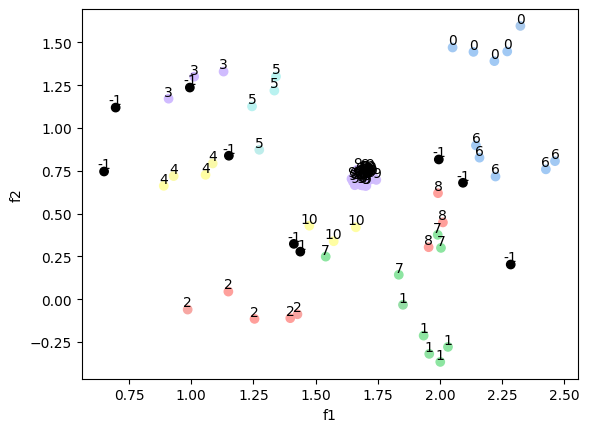

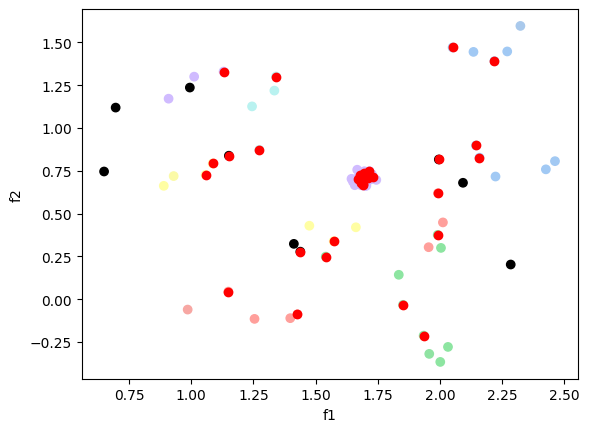

WARNING flwr 2023-11-27 04:59:03,245 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-27 04:59:03,247 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


['6', '9', '3', '0', '2', '7', '5', '1', '4', '8']
{-1: [2, 17, 18, 35, 55, 94, 97, 98, 99], 0: [1, 11, 31, 51, 91], 1: [6, 16, 36, 56, 96], 2: [0, 10, 30, 50, 90], 3: [7, 37, 57], 4: [4, 14, 34, 54], 5: [9, 19, 39, 59], 6: [3, 13, 33, 53, 93], 7: [12, 32, 52, 92], 8: [8, 38, 58], 9: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 10: [5, 15, 95]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [17, 18, 35, 55, 94, 97, 98, 99]
[2, 17, 18, 35, 55, 94, 97, 98, 99]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are th

DEBUG flwr 2023-11-27 04:59:09,850 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
INFO flwr 2023-11-27 04:59:09,852 | server.py:153 | FL finished in 24.82585871964693
INFO flwr 2023-11-27 04:59:09,854 | app.py:225 | app_fit: losses_distributed [(1, 0.08766142344474792)]
INFO flwr 2023-11-27 04:59:09,856 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-27 04:59:09,857 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.5090000000000001)]}
INFO flwr 2023-11-27 04:59:09,858 | app.py:228 | app_fit: losses_centralized []
INFO flwr 2023-11-27 04:59:09,859 | app.py:229 | app_fit: metrics_centralized {}


In [9]:
client_updates_list = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []
# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}

strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=1),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

In [16]:
from src.poisonDetection.xaiMetrics import get_shap_feature_list_all
from src.poisonDetection.clusteringHDBSCAN import run_hdbscan_clustering_algorithm, get_most_dense_cluster_label, \
    create_input_feature_list_per_fixed_round

In [17]:
round = 0

In [12]:
shap_feature_grad_exp_all = get_shap_feature_list_all(weight_results[round], results[round], client_updates_list, **kwargs_poison)

In [38]:
shap_feature_grad_exp_all[0]

[array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

INFO flwr 2023-11-27 05:03:12,052 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-11-27 05:03:16,836	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-11-27 05:03:17,875 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 32938850304.0, 'accelerator_type:RTX': 1.0, 'node:193.1.133.164': 1.0, 'memory': 66857317376.0, 'CPU': 10.0, 'GPU': 1.0}
INFO flwr 2023-11-27 05:03:17,876 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-27 05:03:17,912 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-27 05:03:17,914 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-27 05:03:17,915 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-27 05:03:17,916 | server.py:276 | Requesti

Attempting to initialize parameters


INFO flwr 2023-11-27 05:03:24,705 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-27 05:03:24,706 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-27 05:03:24,708 | server.py:104 | FL starting
DEBUG flwr 2023-11-27 05:03:24,709 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-27 05:03:34,400 | server.py:236 | fit_round 1 received 10 results and 0 failures
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


total selecting features:  10


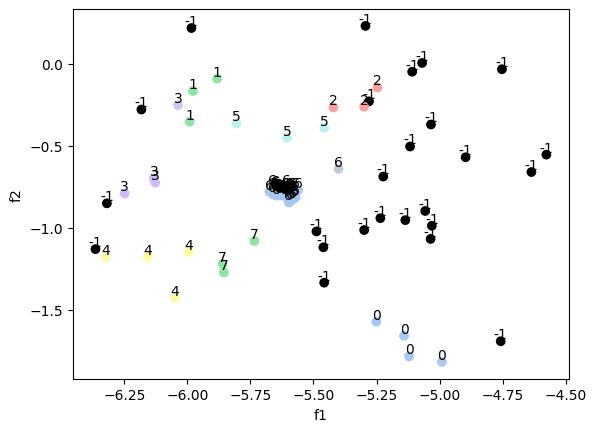

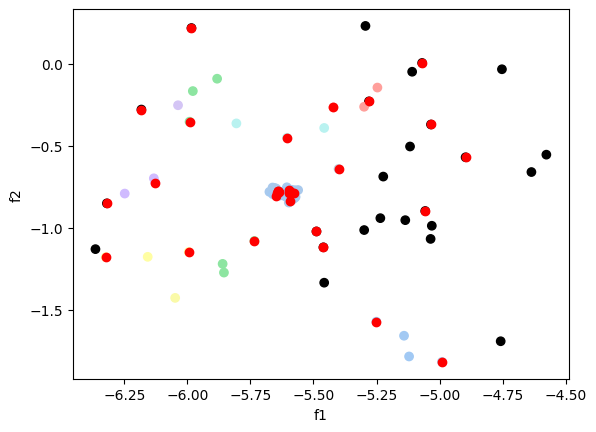

WARNING flwr 2023-11-27 05:03:40,569 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-27 05:03:40,571 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


['5', '0', '7', '1', '9', '6', '4', '3', '2', '8']
{-1: [13, 18, 20, 22, 23, 24, 25, 27, 28, 29, 43, 45, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 93, 95, 98], 0: [11, 21, 41, 91], 1: [10, 40, 90], 2: [17, 47, 97], 3: [14, 44, 54, 94], 4: [16, 26, 46, 96], 5: [19, 49, 99], 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 7: [12, 42, 92]}
-1
Not all features are the same. Possible poisoning
Cluster with different features: [18, 20, 22, 24, 25, 27, 28, 29, 45, 48, 50, 51, 52, 55, 56, 57, 58, 59, 95, 98]
[13, 18, 20, 22, 23, 24, 25, 27, 28, 29, 43, 45, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 93, 95, 98]
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
Not all 

In [ ]:
client_updates_list_d = []
aggregated_updates_list = []
results_d = []
weight_results_d = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []
# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison_d = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'deep_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list_d,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results_d,
    client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison_d,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results_d
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=1),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

In [26]:
shap_feature_deep_exp_all = get_shap_feature_list_all(weight_results_d[round], results_d[round], client_updates_list_d, **kwargs_poison_d)

In [37]:
# import numpy as np
# np.array(shap_feature_deep_exp_all[0]).flatten()

# # print(", ".join(map(str, output_list)))
shap_feature_deep_exp_all[0]

[array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

In [43]:
client_updates_list_d = []
aggregated_updates_list = []
results_d = []
weight_results_d = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []
# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison_d = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'sampling_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 90,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list_d,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results_d,
    client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison_d,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results_d
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=1),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2023-11-27 05:29:00,949 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-11-27 05:29:06,427	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-11-27 05:29:07,517 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 32791405363.0, 'memory': 66513279181.0, 'CPU': 10.0}
INFO flwr 2023-11-27 05:29:07,518 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-27 05:29:07,556 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-27 05:29:07,557 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-27 05:29:07,559 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-27 05:29:07,560 | server.py:276 | Requesti

Attempting to initialize parameters


INFO flwr 2023-11-27 05:29:14,382 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-27 05:29:14,384 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-27 05:29:14,385 | server.py:104 | FL starting
DEBUG flwr 2023-11-27 05:29:14,387 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-11-27 05:29:23,554 | server.py:236 | fit_round 1 received 10 results and 0 failures
ERROR flwr 2023-11-27 05:29:23,695 | app.py:294 | Unknown type passed as data object: <class 'list'>
ERROR flwr 2023-11-27 05:29:23,696 | app.py:295 | Your simulation crashed :(. This could be because of several reasons.The most common are: 
	 > Your system couldn't fit a single VirtualClient: try lowering `client_resources`.
	 > All the actors in your pool crashed. This could be because: 
		 - You clients hit an out-of-memory (OOM) error and actors couldn't recover from it. Try launching your simulation with more generous `client_resources

In [25]:
# from shapash.explainer.consistency import Consistency
# gradientSHAP=shap_feature_grad_exp_all[0]
# deepSHAP=shap_feature_deep_exp_all[0]
# contributions = {"gradientSHAP": gradientSHAP, 
#                  "deepSHAP": deepSHAP}
# cns.compile(contributions=contributions)
# cns.consistency_plot()

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
[(1, 0.615), (2, 0.766), (3, 0.8699999999999999), (4, 0.865), (5, 0.8989999999999998), (6, 0.899), (7, 0.9149999999999998), (8, 0.923), (9, 0.9250000000000002), (10, 0.933)]
[(1, 0.0833163332939148), (2, 0.03945595705509186), (3, 0.021021479308605193), (4, 0.01742779766023159), (5, 0.012745168924331664), (6, 0.011453792430460453), (7, 0.010133207216858862), (8, 0.008942649509757757), (9, 0.008093204518780112), (10, 0.007788422625511883)]

[(1, 0.0833163332939148),
 (2, 0.03945595705509186),
 (3, 0.021021479308605193),
 (4, 0.01742779766023159),
 (5, 0.012745168924331664),
 (6, 0.011453792430460453),
 (7, 0.010133207216858862),
 (8, 0.008942649509757757),
 (9, 0.008093204518780112),
 (10, 0.007788422625511883)]

In [ ]:
[(1, 0.6659999999999999), (2, 0.796), (3, 0.875), (4, 0.9010000000000001), (5, 0.906), (6, 0.921), (7, 0.923), (8, 0.932), (9, 0.9330000000000002), (10, 0.9400000000000001), (11, 0.9390000000000001), (12, 0.9399999999999998), (13, 0.9450000000000001), (14, 0.95), (15, 0.9469999999999998), (16, 0.951), (17, 0.9560000000000001), (18, 0.9550000000000001), (19, 0.961), (20, 0.958), (21, 0.9629999999999999), (22, 0.962), (23, 0.9630000000000001), (24, 0.958), (25, 0.959), (26, 0.969), (27, 0.9679999999999997), (28, 0.9639999999999999), (29, 0.967), (30, 0.967), (31, 0.9639999999999999), (32, 0.9700000000000001), (33, 0.9729999999999999), (34, 0.97), (35, 0.9680000000000002), (36, 0.9730000000000002), (37, 0.9720000000000001), (38, 0.9729999999999999), (39, 0.9739999999999999), (40, 0.976), (41, 0.975), (42, 0.975), (43, 0.974), (44, 0.9729999999999999), (45, 0.976), (46, 0.974), (47, 0.9759999999999998), (48, 0.974), (49, 0.9759999999999998), (50, 0.978)]
[(1, 0.07879273128509523), (2, 0.034294841304421425), (3, 0.017934894312173127), (4, 0.013559254148975014), (5, 0.011789213219657538), (6, 0.009512776158750057), (7, 0.00862702341284603), (8, 0.007526989920064807), (9, 0.007393504655919969), (10, 0.006581108532845975), (11, 0.006227605068357661), (12, 0.005725765862036497), (13, 0.005201680200640113), (14, 0.004787073839455843), (15, 0.004647312652086839), (16, 0.004513611824950203), (17, 0.004082020550966263), (18, 0.0038723334914539014), (19, 0.003897675915854052), (20, 0.0036574745269026612), (21, 0.00348514821450226), (22, 0.0034028925591846927), (23, 0.003454576431540772), (24, 0.0034925688822986557), (25, 0.0035870886710472408), (26, 0.0031900829873047765), (27, 0.0029727109006489625), (28, 0.0030070083457394503), (29, 0.0028668698996189056), (30, 0.002974886851268821), (31, 0.0028895494880853217), (32, 0.0026707421420142053), (33, 0.0026030621935788077), (34, 0.0027199973219248926), (35, 0.002683127808573772), (36, 0.00268705430549744), (37, 0.002502934450370958), (38, 0.0024630387371289545), (39, 0.002451502657815581), (40, 0.0023345507841731885), (41, 0.0023032137904956474), (42, 0.002435501622108859), (43, 0.002313346089460538), (44, 0.002252879962165025), (45, 0.002315604942537902), (46, 0.002269493319370667), (47, 0.00219942120090127), (48, 0.002230442706204485), (49, 0.0022280716089735507), (50, 0.0021634032576621394)]

In [ ]:
[(1, 0.484), (2, 0.764), (3, 0.8230000000000001), (4, 0.8559999999999999), (5, 0.8719999999999999), (6, 0.883), (7, 0.9270000000000002), (8, 0.909), (9, 0.9350000000000002), (10, 0.9369999999999999), (11, 0.9429999999999998), (12, 0.946), (13, 0.9349999999999999), (14, 0.942), (15, 0.9410000000000002), (16, 0.9450000000000001), (17, 0.952), (18, 0.9570000000000001), (19, 0.9499999999999998), (20, 0.9570000000000001), (21, 0.9560000000000001), (22, 0.9579999999999999), (23, 0.9630000000000001), (24, 0.9640000000000001), (25, 0.959), (26, 0.967), (27, 0.966), (28, 0.968), (29, 0.9640000000000002), (30, 0.9629999999999999), (31, 0.9650000000000002), (32, 0.9670000000000002), (33, 0.9639999999999999), (34, 0.9649999999999999), (35, 0.966), (36, 0.968), (37, 0.9710000000000001), (38, 0.968), (39, 0.9650000000000001), (40, 0.9650000000000001), (41, 0.968), (42, 0.9710000000000001), (43, 0.9709999999999999), (44, 0.9700000000000001), (45, 0.9729999999999999), (46, 0.9710000000000001), (47, 0.9730000000000001), (48, 0.9670000000000002), (49, 0.966), (50, 0.9710000000000001)]
[(1, 0.0764826749563217), (2, 0.0365421002805233), (3, 0.024264134988188742), (4, 0.01821853718161583), (5, 0.015673730224370956), (6, 0.01428798226546496), (7, 0.01081318270228803), (8, 0.011423138735815883), (9, 0.009694257497787477), (10, 0.008512274952139704), (11, 0.008077382174320519), (12, 0.007424622465856375), (13, 0.008589310672134162), (14, 0.007332519545219839), (15, 0.008197119529359042), (16, 0.007236337868729607), (17, 0.005694511293899267), (18, 0.005059877701569348), (19, 0.005457014059764334), (20, 0.004873027685331181), (21, 0.005238980601541697), (22, 0.004662580144009553), (23, 0.004915980873978697), (24, 0.0041760739310411745), (25, 0.004333545412344392), (26, 0.004207460777834059), (27, 0.004249652552593033), (28, 0.0038193552772572735), (29, 0.004653415851527824), (30, 0.004201816178334411), (31, 0.003897463083267212), (32, 0.003926916492724558), (33, 0.003893926253163955), (34, 0.0038418484516732853), (35, 0.0037958869102585587), (36, 0.003505089068872621), (37, 0.0035354529127653222), (38, 0.003795108706413885), (39, 0.0040021968474902685), (40, 0.004041233451192966), (41, 0.0034050057313725125), (42, 0.0034700201173473028), (43, 0.0031965422258508625), (44, 0.003384298845652666), (45, 0.003249168085872952), (46, 0.003327411235048203), (47, 0.003396737415678217), (48, 0.0037623278959872546), (49, 0.004080399338548886), (50, 0.0032778048345062415)]

In [10]:
sim.losses_distributed

[(1, 0.04305557066202163),
 (2, 0.015540857982821763),
 (3, 0.011019635195843874),
 (4, 0.007822641238337383),
 (5, 0.0068570918918121615),
 (6, 0.006441129241371526),
 (7, 0.005441510683856904),
 (8, 0.004422726241347846),
 (9, 0.004573393688886427),
 (10, 0.004865162237605546),
 (11, 0.004278980131435674),
 (12, 0.004449576700571924),
 (13, 0.003985242081107572),
 (14, 0.0038906065462506385),
 (15, 0.003646943605242995)]

In [12]:
sim.metrics_distributed['accuracy']

[(1, 0.833),
 (2, 0.908),
 (3, 0.937),
 (4, 0.953),
 (5, 0.952),
 (6, 0.954),
 (7, 0.9620000000000001),
 (8, 0.9720000000000001),
 (9, 0.969),
 (10, 0.968),
 (11, 0.969),
 (12, 0.9729999999999999),
 (13, 0.975),
 (14, 0.978),
 (15, 0.9720000000000001)]

In [13]:
# Your list of tuples
data = sim.metrics_distributed['accuracy']

# Extract the second values from each tuple using a list comprehension
second_values = [t[1] for t in data]

# Print the list of second values
print(second_values)


[0.833, 0.908, 0.937, 0.953, 0.952, 0.954, 0.9620000000000001, 0.9720000000000001, 0.969, 0.968, 0.969, 0.9729999999999999, 0.975, 0.978, 0.9720000000000001]


INFO flwr 2023-09-17 19:51:32,429 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-09-17 19:51:38,058	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-09-17 19:51:39,022 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 30329471385.0, 'GPU': 1.0, 'CPU': 5.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0, 'memory': 60768766567.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-09-17 19:51:39,023 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-09-17 19:51:39,060 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-09-17 19:51:39,062 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-17 19:51:39,063 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-09-17 19:51:39,064 | server.py:276 | Requesti

Attempting to initialize parameters


INFO flwr 2023-09-17 19:51:44,647 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-09-17 19:51:44,649 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-17 19:51:44,650 | server.py:104 | FL starting
DEBUG flwr 2023-09-17 19:51:44,651 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:51:52,862 | server.py:236 | fit_round 1 received 10 results and 0 failures


total selecting features


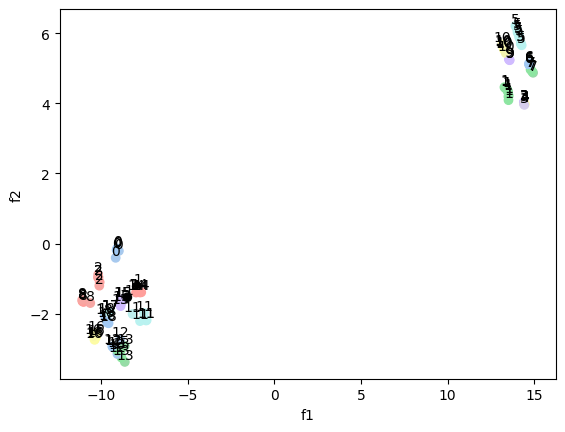

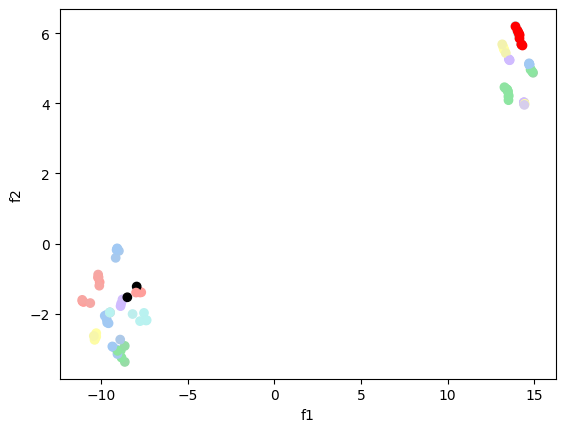

WARNING flwr 2023-09-17 19:52:03,048 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-17 19:52:03,050 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


['5', '0', '7', '6', '8', '9', '1', '2', '4', '3']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [81, 82, 83, 85, 86, 87, 88, 89]
[80, 81, 82, 83, 85, 86, 87, 88, 89]
2
All cluster features are the same: 2
3
Not all features are the same. Possible poisoning
Cluster with different features: [2, 3, 5, 7, 9]
[0, 2, 3, 5, 7, 9]
4
Not all features are the same. Possible poisoning
Cluster with different features: [6, 8]
[1, 6, 8]
5
Not all features are the same. Possible poisoning
Cluster with different features: [61, 62, 63, 65, 66, 67, 68, 69]
[60, 61, 62, 63, 65, 66, 67, 68, 69]
6
Not all features are the same. Possible poisoning
Cluster with different features: [73, 75, 77, 79]
[72, 73, 75, 77, 79]
7
Not all features are the same. Possible poisoning
Cluster with different features: [71, 76, 78]
[70, 71, 76, 78]
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster wi

DEBUG flwr 2023-09-17 19:52:09,778 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:52:09,780 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:52:16,298 | server.py:236 | fit_round 2 received 10 results and 0 failures


total selecting features


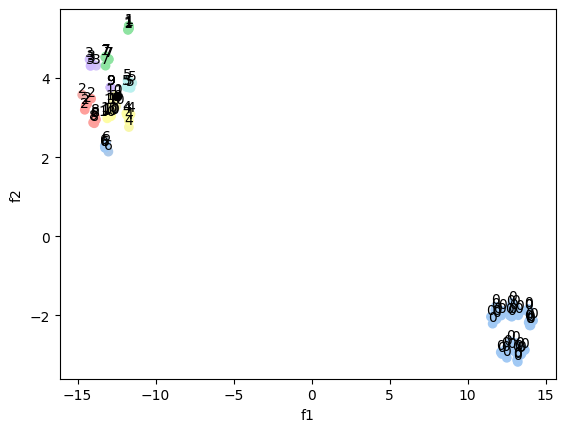

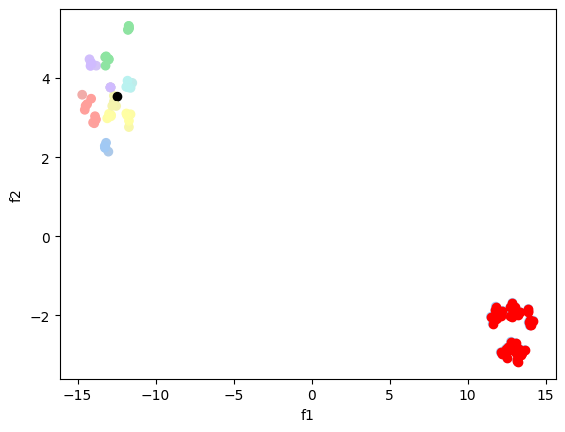

DEBUG flwr 2023-09-17 19:52:25,979 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)


['2', '9', '1', '8', '3', '4', '7', '0', '5', '6']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 81, 82, 83, 85, 86, 87, 88, 89]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
Not all features are the same. Possible poisoning
Cluster with different features: [18, 38, 78, 98]
[14, 18, 34, 38, 64, 74, 78, 94, 98]
{'2': 9, '9': 2, '1': 9, '8': 2, '3': 9, '4': 9,

DEBUG flwr 2023-09-17 19:52:32,349 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:52:32,351 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:52:38,843 | server.py:236 | fit_round 3 received 10 results and 0 failures


total selecting features


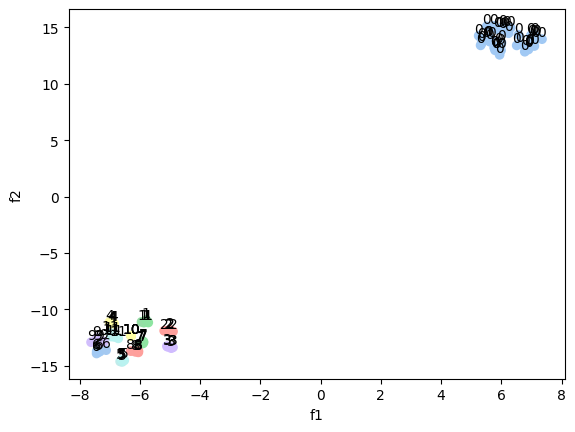

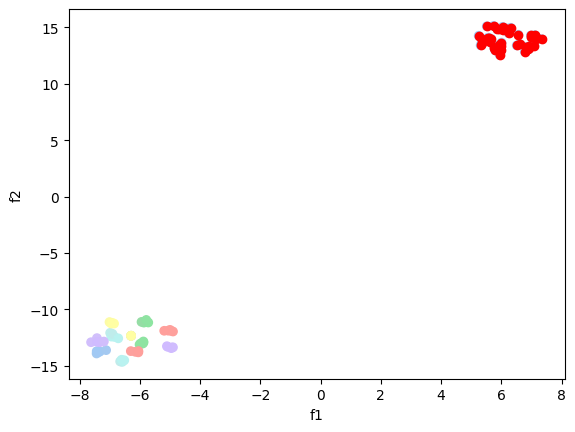

DEBUG flwr 2023-09-17 19:52:48,614 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)


['5', '4', '3', '7', '0', '9', '1', '2', '6', '8']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 77, 78, 79]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'5': 9, '4': 9, '3': 9, '7': 0, '0': 0, '9': 0, '1': 9, '2': 9, '6': 0, '8': 0}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 19:52:55,068 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:52:55,070 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:53:01,621 | server.py:236 | fit_round 4 received 10 results and 0 failures


total selecting features


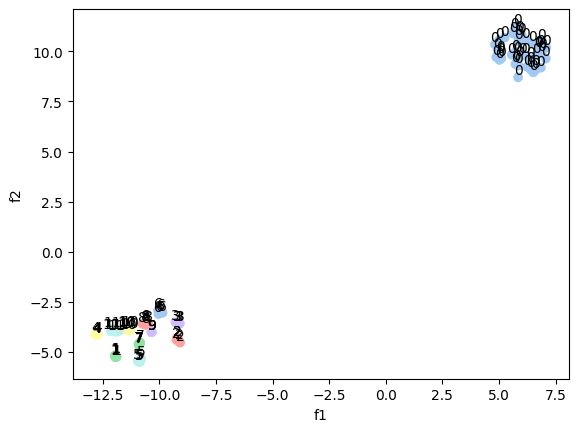

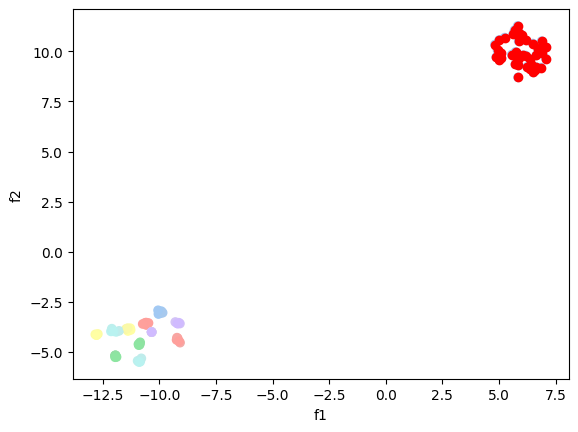

DEBUG flwr 2023-09-17 19:53:11,039 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)


['9', '7', '4', '8', '6', '3', '2', '5', '1', '0']
0
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 25, 26, 27, 28, 29, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89]
[20, 21, 22, 23, 25, 26, 27, 28, 29, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'9': 0, '7': 0, '4': 9, '8': 0, '6': 0, '3': 9, '2': 9, '5': 9, '1': 9, '0': 0}
poison c

DEBUG flwr 2023-09-17 19:53:17,382 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:53:17,384 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:53:23,731 | server.py:236 | fit_round 5 received 10 results and 0 failures


total selecting features


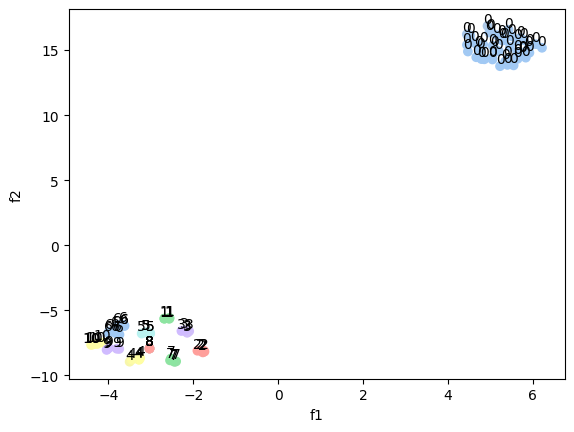

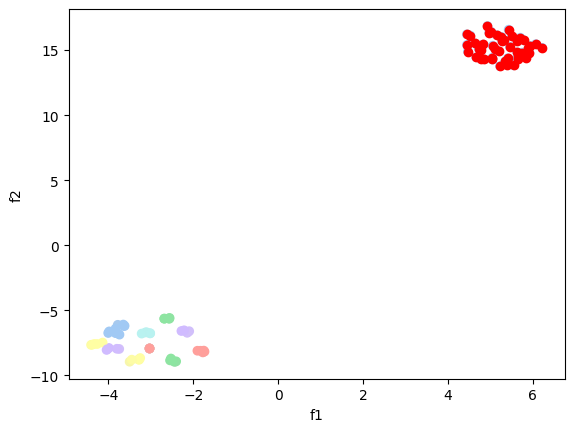

DEBUG flwr 2023-09-17 19:53:33,515 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)


['6', '1', '0', '2', '5', '8', '3', '9', '4', '7']
0
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 61, 62, 63, 65, 66, 67, 68, 69, 81, 82, 83, 85, 86, 87, 88, 89]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 60, 61, 62, 63, 65, 66, 67, 68, 69, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
Not all features are the same. Possible poisoning
Cluster with different features: [9, 29, 59, 79, 99]
[4, 9, 24, 29, 54, 59, 74, 79, 94, 99]
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
{'6': 2, '1': 9, '0': 2, 

DEBUG flwr 2023-09-17 19:53:39,587 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:53:39,588 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:53:46,129 | server.py:236 | fit_round 6 received 10 results and 0 failures


total selecting features


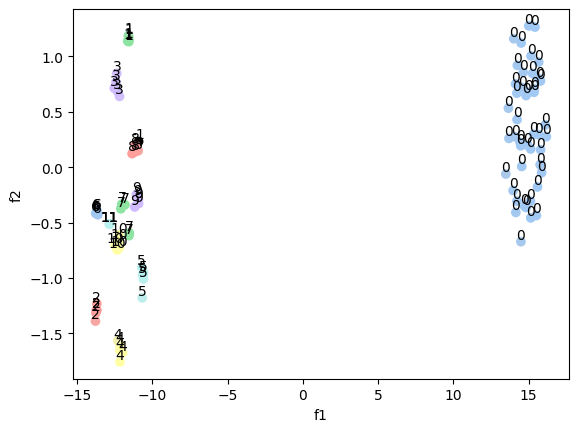

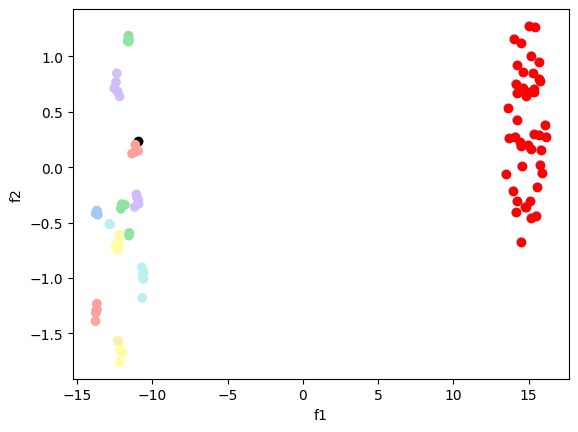

DEBUG flwr 2023-09-17 19:53:55,625 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)


['3', '5', '6', '1', '4', '8', '9', '2', '7', '0']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 71, 72, 73, 75, 76, 77, 78, 79]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 70, 71, 72, 73, 75, 76, 77, 78, 79]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'3': 9, '5': 9, '6': 0, '1': 9, '4': 9, '8': 0, '9': 0, '2': 9, '7': 0, '0': 0}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 19:54:01,963 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:54:01,965 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:54:08,834 | server.py:236 | fit_round 7 received 10 results and 0 failures


total selecting features


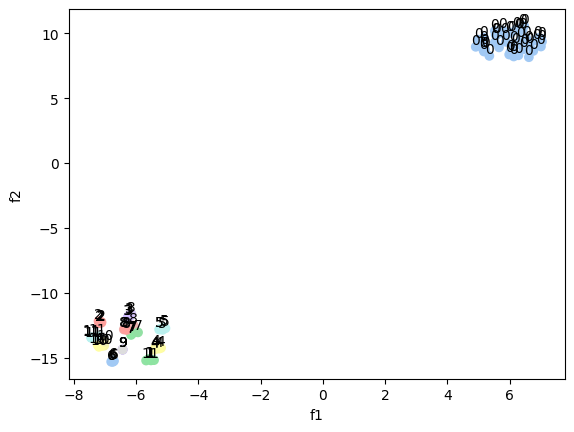

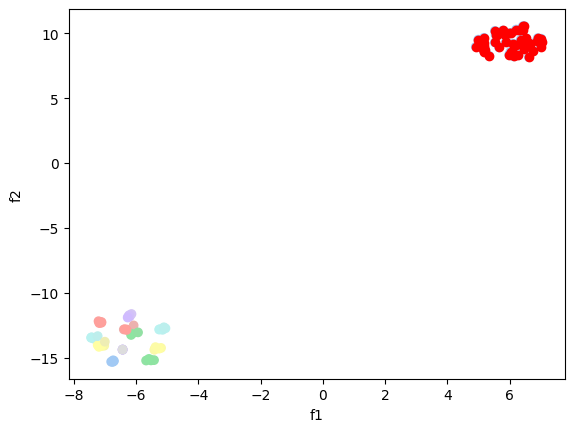

DEBUG flwr 2023-09-17 19:54:19,044 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)


['3', '4', '8', '5', '7', '1', '6', '9', '2', '0']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 31, 32, 33, 35, 36, 37, 38, 39, 51, 52, 53, 55, 56, 57, 58, 59, 81, 82, 83, 85, 86, 87, 88, 89]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 30, 31, 32, 33, 35, 36, 37, 38, 39, 50, 51, 52, 53, 55, 56, 57, 58, 59, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'3': 9, '4': 9, '8': 0, '5': 9, '7': 0, '1': 9, '6': 0, '9': 0, '2': 9, '0': 0}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 19:54:25,385 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:54:25,387 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:54:31,980 | server.py:236 | fit_round 8 received 10 results and 0 failures


total selecting features


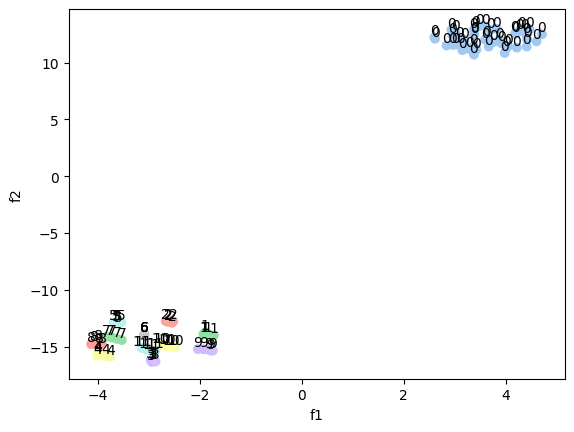

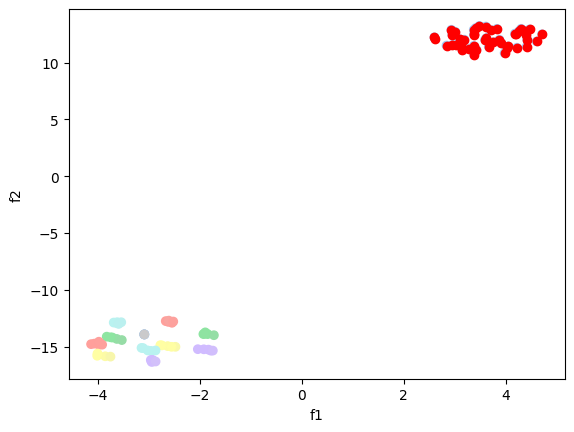

DEBUG flwr 2023-09-17 19:54:41,913 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)


['3', '2', '6', '0', '1', '5', '4', '9', '7', '8']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'3': 9, '2': 9, '6': 0, '0': 0, '1': 9, '5': 9, '4': 9, '9': 0, '7': 0, '8': 0}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 19:54:48,517 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:54:48,519 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:54:55,328 | server.py:236 | fit_round 9 received 10 results and 0 failures


total selecting features


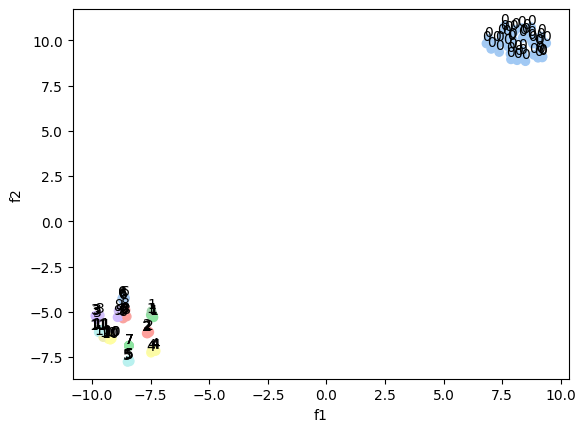

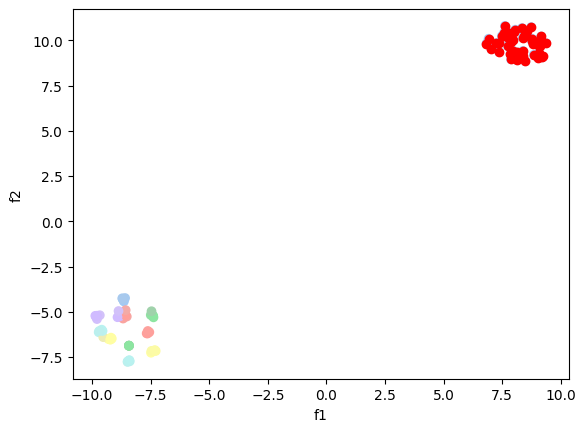

DEBUG flwr 2023-09-17 19:55:06,102 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)


['9', '3', '5', '6', '8', '1', '2', '0', '7', '4']
0
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 91, 92, 93, 95, 96, 97, 98, 99]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 90, 91, 92, 93, 95, 96, 97, 98, 99]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
Not all features are the same. Possible poisoning
Cluster with different features: [35]
[8, 35, 38, 48, 78, 88]
11
All cluster features are the same: 11
{'9': 1, '3': 9

DEBUG flwr 2023-09-17 19:55:12,446 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:55:12,447 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:55:19,387 | server.py:236 | fit_round 10 received 10 results and 0 failures


total selecting features


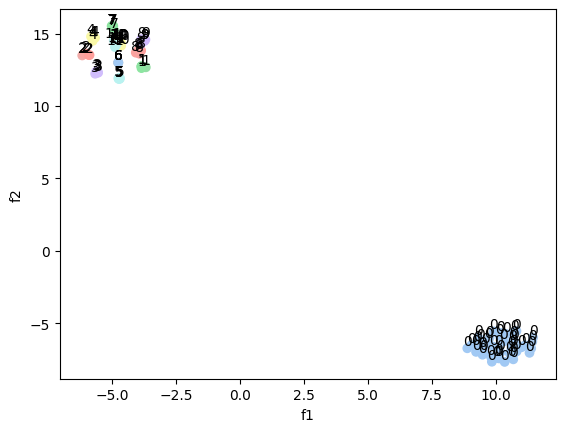

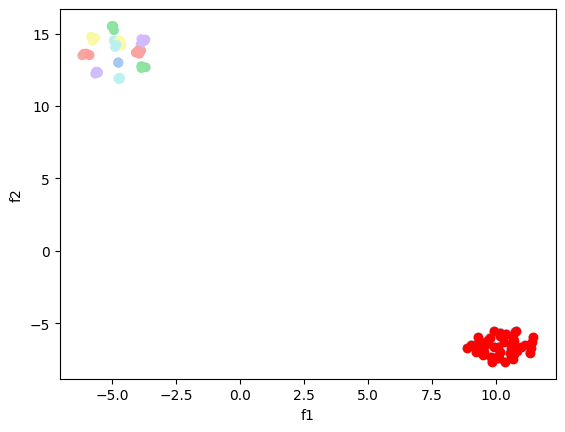

DEBUG flwr 2023-09-17 19:55:31,332 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)


['6', '8', '1', '0', '5', '3', '7', '9', '2', '4']
0
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 98, 99]
[20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'6': 0, '8': 0, '1': 9, '0': 0, '5': 9, '3': 9, '7': 0, '9': 0, '2': 9, '4': 9}
poison c

DEBUG flwr 2023-09-17 19:55:37,938 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:55:37,940 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:55:44,550 | server.py:236 | fit_round 11 received 10 results and 0 failures


total selecting features


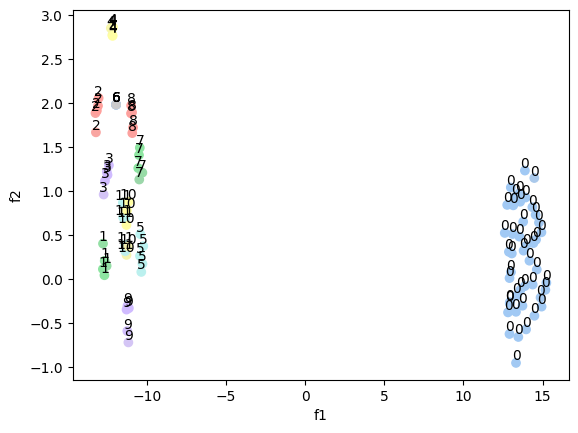

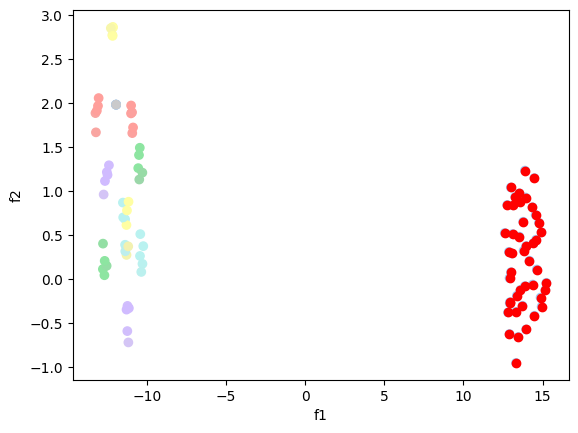

DEBUG flwr 2023-09-17 19:55:56,254 | server.py:173 | evaluate_round 11: strategy sampled 10 clients (out of 10)


['6', '0', '7', '1', '4', '9', '2', '3', '5', '8']
0
Not all features are the same. Possible poisoning
Cluster with different features: [31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89]
[30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'6': 0, '0': 0, '7': 0, '1': 9, '4': 9, '9': 0, '2': 9, '3': 9, '5': 9, '8': 0}
poison c

DEBUG flwr 2023-09-17 19:56:02,678 | server.py:187 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:56:02,679 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:56:09,568 | server.py:236 | fit_round 12 received 10 results and 0 failures


total selecting features


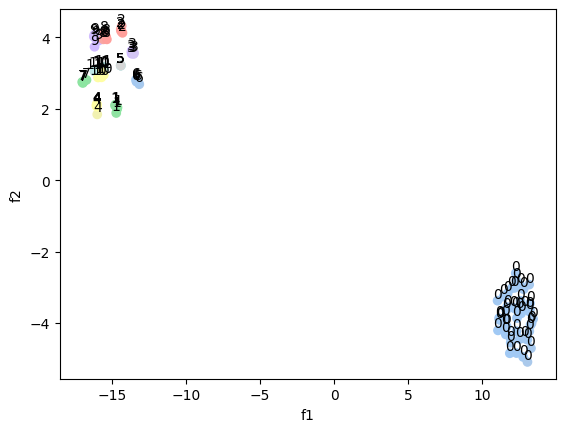

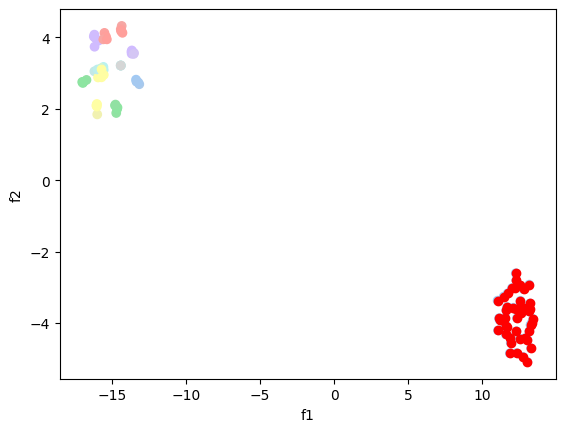

DEBUG flwr 2023-09-17 19:56:20,938 | server.py:173 | evaluate_round 12: strategy sampled 10 clients (out of 10)


['4', '6', '8', '7', '3', '2', '5', '9', '1', '0']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 81, 82, 83, 85, 86, 87, 88, 89]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'4': 9, '6': 0, '8': 0, '7': 0, '3': 9, '2': 9, '5': 9, '9': 0, '1': 9, '0': 0}
poison client ids:  [0, 4

DEBUG flwr 2023-09-17 19:56:27,395 | server.py:187 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:56:27,397 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:56:34,356 | server.py:236 | fit_round 13 received 10 results and 0 failures


total selecting features


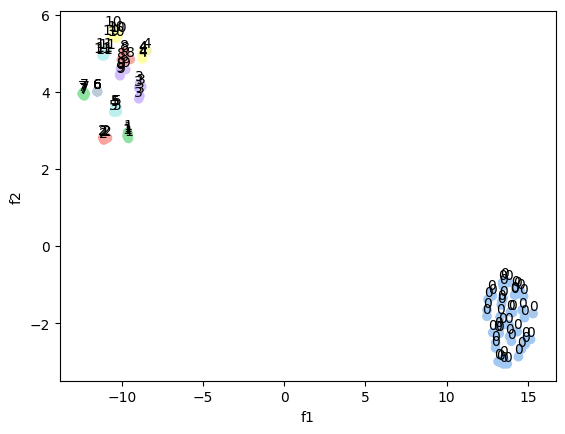

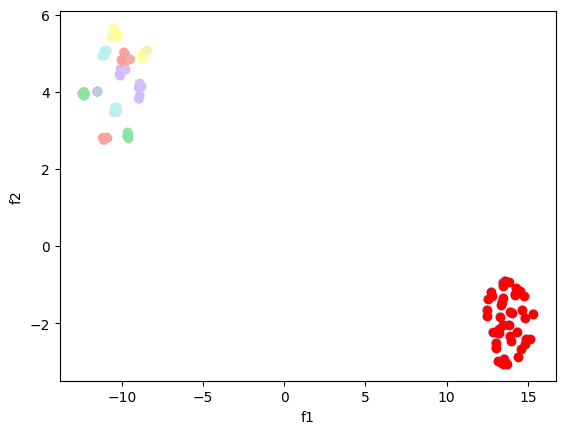

DEBUG flwr 2023-09-17 19:56:46,541 | server.py:173 | evaluate_round 13: strategy sampled 10 clients (out of 10)


['3', '4', '2', '8', '7', '0', '1', '9', '6', '5']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 61, 62, 63, 65, 66, 67, 68, 69, 91, 92, 93, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 60, 61, 62, 63, 65, 66, 67, 68, 69, 90, 91, 92, 93, 95, 96, 97, 98, 99]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'3': 9, '4': 9, '2': 9, '8': 0, '7': 0, '0': 0, '1': 9, '9': 0, '6': 0, '5': 9}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 19:56:53,050 | server.py:187 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:56:53,052 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:57:00,048 | server.py:236 | fit_round 14 received 10 results and 0 failures


total selecting features


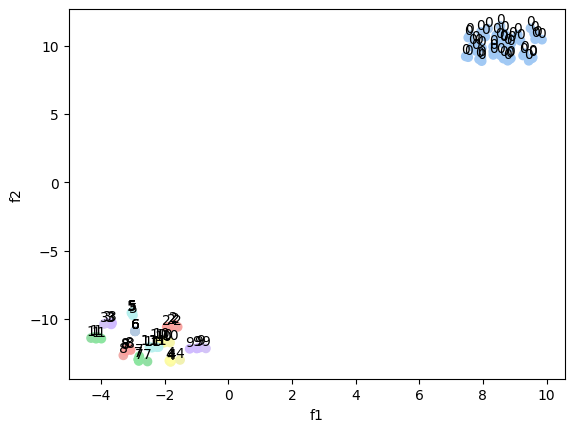

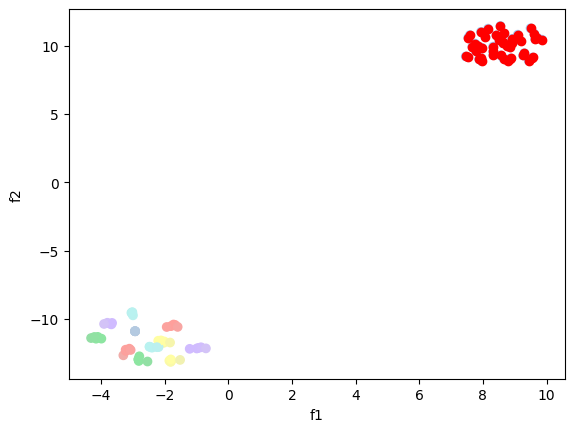

DEBUG flwr 2023-09-17 19:57:10,976 | server.py:173 | evaluate_round 14: strategy sampled 10 clients (out of 10)


['5', '1', '2', '9', '4', '6', '0', '7', '8', '3']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 91, 92, 93, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 90, 91, 92, 93, 95, 96, 97, 98, 99]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'5': 9, '1': 9, '2': 9, '9': 0, '4': 9, '6': 0, '0': 0, '7': 0, '8': 0, '3': 9}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 19:57:17,463 | server.py:187 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-09-17 19:57:17,465 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 19:57:24,257 | server.py:236 | fit_round 15 received 10 results and 0 failures


total selecting features


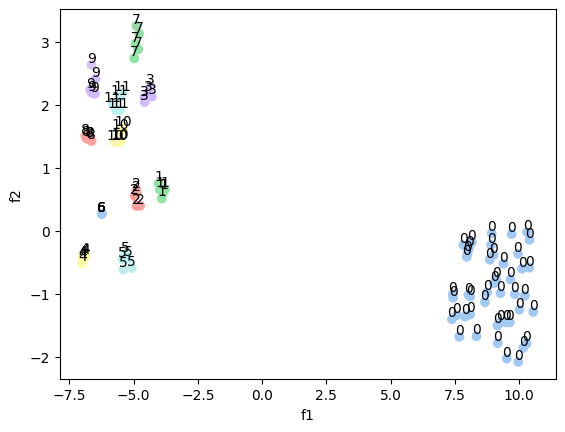

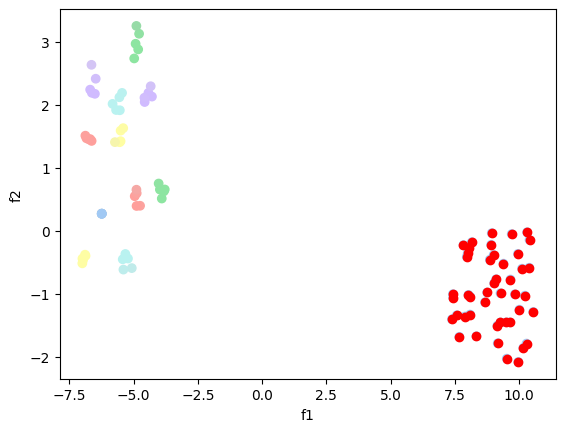

DEBUG flwr 2023-09-17 19:57:35,971 | server.py:173 | evaluate_round 15: strategy sampled 10 clients (out of 10)


['4', '8', '3', '7', '9', '1', '0', '6', '5', '2']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 21, 22, 23, 25, 26, 27, 28, 29, 51, 52, 53, 55, 56, 57, 58, 59, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 20, 21, 22, 23, 25, 26, 27, 28, 29, 50, 51, 52, 53, 55, 56, 57, 58, 59, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'4': 9, '8': 0, '3': 9, '7': 0, '9': 0, '1': 9, '0': 0, '6': 0, '5': 9, '2': 9}
poison client ids:  [0, 2

DEBUG flwr 2023-09-17 19:57:42,559 | server.py:187 | evaluate_round 15 received 10 results and 0 failures
INFO flwr 2023-09-17 19:57:42,560 | server.py:153 | FL finished in 357.9096387862228
INFO flwr 2023-09-17 19:57:42,562 | app.py:225 | app_fit: losses_distributed [(1, 0.7612960500717163), (2, 0.06164550757408142), (3, 0.6929568862915039), (4, 0.11778088057041167), (5, 0.31234375047683716), (6, 0.24465076184272766), (7, 0.2071453297138214), (8, 0.163371941447258), (9, 0.17098982417583464), (10, 0.16612583923339844), (11, 0.1292354711294174), (12, 0.12663226175308226), (13, 0.10865535032749174), (14, 0.11077792179584503), (15, 0.0815190060734749)]
INFO flwr 2023-09-17 19:57:42,563 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-17 19:57:42,564 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.095), (2, 0.381), (3, 0.09500000000000001), (4, 0.21799999999999997), (5, 0.095), (6, 0.096), (7, 0.11900000000000002), (8, 0.15100000000000002), (9, 0.1639999

In [18]:
client_updates_list = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                        'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                        'min_cluster_size': 2, 'perplexity': 40,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40,
                        'debug_info': debug_info,'is_eliminating_clients':False}

strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=15),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 5, "num_gpus": 1}
)

In [19]:
sim.losses_distributed

[(1, 0.7612960500717163),
 (2, 0.06164550757408142),
 (3, 0.6929568862915039),
 (4, 0.11778088057041167),
 (5, 0.31234375047683716),
 (6, 0.24465076184272766),
 (7, 0.2071453297138214),
 (8, 0.163371941447258),
 (9, 0.17098982417583464),
 (10, 0.16612583923339844),
 (11, 0.1292354711294174),
 (12, 0.12663226175308226),
 (13, 0.10865535032749174),
 (14, 0.11077792179584503),
 (15, 0.0815190060734749)]

In [20]:
sim.metrics_distributed['accuracy']

[(1, 0.095),
 (2, 0.381),
 (3, 0.09500000000000001),
 (4, 0.21799999999999997),
 (5, 0.095),
 (6, 0.096),
 (7, 0.11900000000000002),
 (8, 0.15100000000000002),
 (9, 0.16399999999999998),
 (10, 0.183),
 (11, 0.279),
 (12, 0.28),
 (13, 0.341),
 (14, 0.314),
 (15, 0.347)]

In [21]:
# Your list of tuples
data = sim.metrics_distributed['accuracy']

# Extract the second values from each tuple using a list comprehension
second_values = [t[1] for t in data]

# Print the list of second values
print(second_values)


[0.095, 0.381, 0.09500000000000001, 0.21799999999999997, 0.095, 0.096, 0.11900000000000002, 0.15100000000000002, 0.16399999999999998, 0.183, 0.279, 0.28, 0.341, 0.314, 0.347]


### SHAP consistency evaluation

INFO flwr 2023-11-27 04:04:04,577 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-11-27 04:04:09,813	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 
INFO flwr 2023-11-27 04:04:10,847 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 23928499814.0, 'GPU': 1.0, 'memory': 47856999630.0, 'CPU': 10.0, 'node:__internal_head__': 1.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0}
INFO flwr 2023-11-27 04:04:10,848 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
INFO flwr 2023-11-27 04:04:10,886 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO flwr 2023-11-27 04:04:10,887 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-27 04:04:10,888 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-11-27 04:04:10,889 | server.py:276 | Requesti

Attempting to initialize parameters


INFO flwr 2023-11-27 04:04:18,024 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-11-27 04:04:18,025 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-11-27 04:04:18,026 | server.py:104 | FL starting
DEBUG flwr 2023-11-27 04:04:18,028 | server.py:222 | fit_round 1: strategy sampled 20 clients (out of 20)
DEBUG flwr 2023-11-27 04:04:32,566 | server.py:236 | fit_round 1 received 20 results and 0 failures


total selecting features:  10


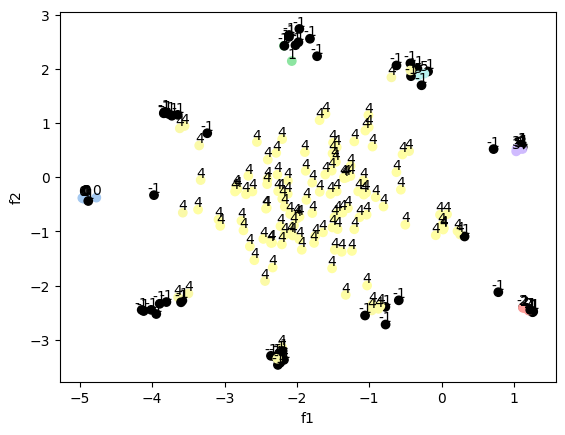

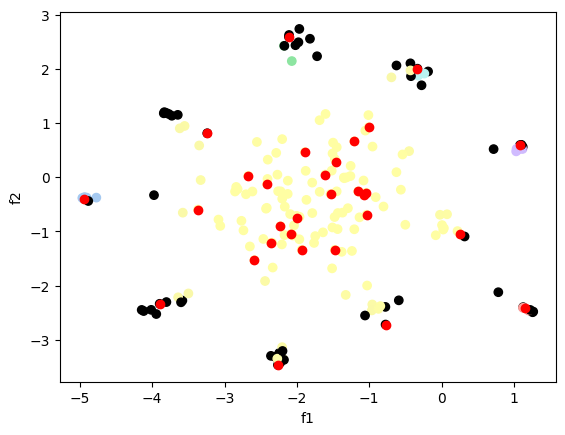

WARNING flwr 2023-11-27 04:04:49,292 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-27 04:04:49,294 | server.py:173 | evaluate_round 1: strategy sampled 20 clients (out of 20)


['7', '2', '9', '16', '18', '17', '12', '0', '8', '4', '5', '13', '10', '1', '15', '19', '14', '3', '11', '6']
{-1: [30, 32, 34, 35, 36, 37, 39, 41, 42, 44, 45, 50, 51, 55, 56, 57, 60, 61, 64, 65, 66, 67, 69, 70, 72, 73, 74, 75, 77, 110, 111, 112, 114, 116, 117, 118, 142, 150, 151, 154, 156, 157, 160, 164, 165, 169, 180, 181, 182, 183, 184, 185, 187, 189], 0: [33, 43, 53, 63, 113, 143, 153, 163], 1: [40, 140], 2: [31, 71, 141, 161], 3: [46, 76, 146, 166, 186], 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 38, 47, 48, 49, 52, 54, 58, 59, 68, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 115, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 144, 145, 147, 148, 149, 152, 155, 158, 159, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 188, 190, 191, 192, 193, 194, 19

DEBUG flwr 2023-11-27 04:05:01,501 | server.py:187 | evaluate_round 1 received 20 results and 0 failures
INFO flwr 2023-11-27 04:05:01,503 | server.py:153 | FL finished in 43.47532734647393
INFO flwr 2023-11-27 04:05:01,504 | app.py:225 | app_fit: losses_distributed [(1, 0.09108614587783813)]
INFO flwr 2023-11-27 04:05:01,505 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-27 04:05:01,506 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.15300000000000005)]}
INFO flwr 2023-11-27 04:05:01,507 | app.py:228 | app_fit: losses_centralized []
INFO flwr 2023-11-27 04:05:01,508 | app.py:229 | app_fit: metrics_centralized {}


## Experiments framework

In [29]:
def set_constants(num_clients=10, selected_dataset='MNIST'):
    constants.NUM_CLIENTS = num_clients
    constants.SELECTED_DATASET = selected_dataset

In [43]:
def get_dataset(kwargs_train, kwargs_val, len_train_data, len_test_data, random_iid_ratio, is_visualize=False):
    trainloaders, valloaders, testloaders = dataLoaderFactory.generate_data_loaders(kwargs_train, kwargs_val,
                              strategy=poison_strategy_with_non_iid_split,
                              len_train_data=len_train_data, len_test_data=len_test_data,
                              random_ratio=random_iid_ratio, is_visualize=is_visualize,
                              visualize_idx=0)
    return trainloaders, valloaders, testloaders

In [55]:
def client_fn(cid) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    net = get_nn()
    net.to(constants.DEVICE)
    # trainloaders, valloaders, _ = get_train_val_test_loaders()
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    
    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [149]:
def run_exp_type_num_rounds(num_rounds, trainloaders, valloaders, is_eliminating_clients=True, show_tsne_graphs=False):
    client_updates_list = []
    aggregated_updates_list = []
    results = []
    weight_results = []
    eliminated_client_list = []
    eliminated_client_ids = []
    debug_info = []

    # should update these value based on the dataset: total_labels_per_client, target_label
    kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                            'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
                            'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
                            'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
                            'min_cluster_size': 2, 'perplexity': 40,
                            'show_poison_detection_graphs': show_tsne_graphs, 'malicious_start_idx': 10, 'malicious_end_idx': 60,
                            'debug_info': debug_info,'is_eliminating_clients':is_eliminating_clients}
    
    strategy = CustomFedAvg(
        fraction_fit=1.0,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
        client_updates_list=client_updates_list,
        aggregated_updates_list=aggregated_updates_list,
        results_all=results,
        client_analysis_strategy_fn=client_analysis_fn_general_alg,
        strategy_kwargs=kwargs_poison,
        eliminated_client_list=eliminated_client_list,
        eliminated_client_ids=eliminated_client_ids,
        weight_results=weight_results
    )
    
    client_resources = None
    if constants.DEVICE == "cuda":
        # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
        client_resources = {"num_cpus": 1, "num_gpus": 0.1}
    
    # Start simulation
    sim = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=constants.NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
        client_resources=client_resources,
        ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
    )
    return sim, client_updates_list, eliminated_client_list, eliminated_client_ids, results, weight_results

### Exp1: evaluate impact of poisoning from clients with increasing number of total clients

In [ ]:
set_constants(num_clients=50, selected_dataset='MNIST')
kwargs_train = {'poison_type': 'target_poison', 'poison_ratio': 1, 'target_label': 4, 'target_clients': [1,2,3,4,5]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = get_dataset(kwargs_train=kwargs_train, kwargs_val=kwargs_val, 
                                                    len_train_data=10000, len_test_data=1000, random_iid_ratio=1, 
                                                    is_visualize=False)

INFO flwr 2023-09-17 21:26:05,074 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-09-17 21:26:10,054	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-09-17 21:26:11,140 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 59775632180.0, 'node:__internal_head__': 1.0, 'CPU': 10.0, 'object_store_memory': 29887816089.0, 'GPU': 1.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0}
INFO flwr 2023-09-17 21:26:11,142 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.1}
INFO flwr 2023-09-17 21:26:11,184 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO flwr 2023-09-17 21:26:11,186 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-17 21:26:11,188 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-09-17 21:26:11,189 | server.py:276 | Reques

Attempting to initialize parameters


INFO flwr 2023-09-17 21:26:17,192 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-09-17 21:26:17,194 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-17 21:26:17,195 | server.py:104 | FL starting
DEBUG flwr 2023-09-17 21:26:17,196 | server.py:222 | fit_round 1: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:26:31,313 | server.py:236 | fit_round 1 received 50 results and 0 failures


total selecting features


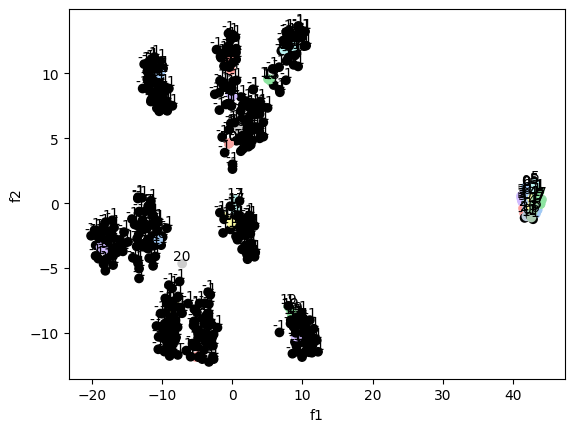

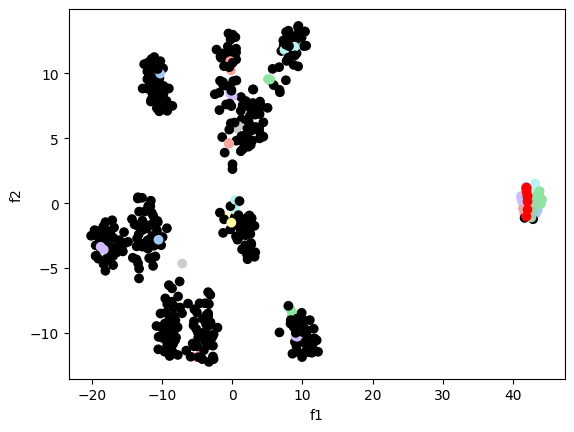

WARNING flwr 2023-09-17 21:27:13,032 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-17 21:27:13,034 | server.py:173 | evaluate_round 1: strategy sampled 50 clients (out of 50)


['7', '20', '39', '5', '43', '37', '46', '26', '6', '36', '15', '3', '2', '31', '30', '47', '19', '17', '12', '27', '24', '4', '13', '25', '23', '35', '8', '33', '49', '40', '28', '29', '14', '44', '9', '18', '41', '1', '48', '10', '34', '38', '42', '0', '11', '22', '32', '16', '21', '45']
0
Not all features are the same. Possible poisoning
Cluster with different features: [121, 122, 123, 125, 126, 127, 128, 129]
[120, 121, 122, 123, 125, 126, 127, 128, 129]
1
Not all features are the same. Possible poisoning
Cluster with different features: [371, 372, 373, 375, 376, 377, 378, 379]
[370, 371, 372, 373, 375, 376, 377, 378, 379]
2
Not all features are the same. Possible poisoning
Cluster with different features: [111, 116]
[110, 111, 116]
3
Not all features are the same. Possible poisoning
Cluster with different features: [115, 117, 118, 119]
[113, 115, 117, 118, 119]
4
Not all features are the same. Possible poisoning
Cluster with different features: [211, 216]
[210, 211, 216]
5
Not all

DEBUG flwr 2023-09-17 21:27:25,040 | server.py:187 | evaluate_round 1 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:27:25,042 | server.py:222 | fit_round 2: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:27:36,921 | server.py:236 | fit_round 2 received 50 results and 0 failures


total selecting features


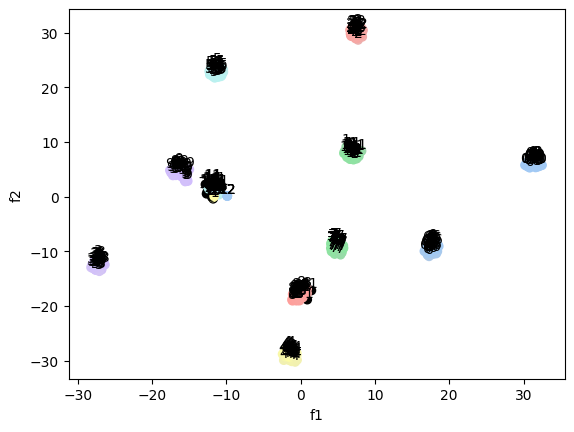

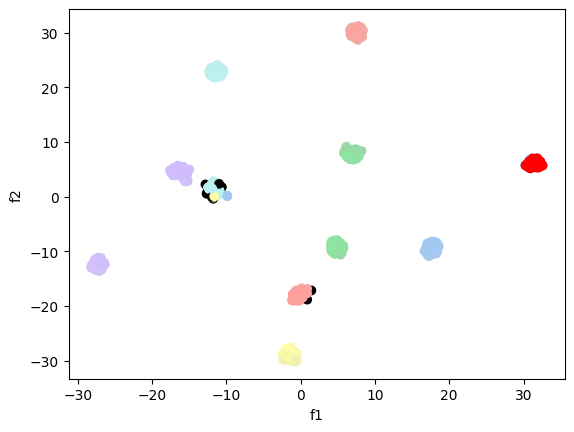

DEBUG flwr 2023-09-17 21:28:26,745 | server.py:173 | evaluate_round 2: strategy sampled 50 clients (out of 50)


['21', '36', '47', '18', '46', '7', '22', '8', '42', '5', '49', '4', '48', '39', '23', '30', '25', '15', '0', '9', '19', '38', '11', '17', '34', '31', '20', '6', '45', '3', '32', '37', '43', '26', '28', '14', '2', '13', '35', '40', '24', '12', '27', '44', '41', '16', '10', '33', '29', '1']
0
Not all features are the same. Possible poisoning
Cluster with different features: [91, 92, 93, 95, 96, 97, 98, 99, 111, 112, 113, 115, 116, 117, 118, 119, 291, 292, 293, 295, 296, 297, 298, 299, 361, 362, 363, 365, 366, 367, 368, 369, 491, 492, 493, 495, 496, 497, 498, 499]
[90, 91, 92, 93, 95, 96, 97, 98, 99, 110, 111, 112, 113, 115, 116, 117, 118, 119, 290, 291, 292, 293, 295, 296, 297, 298, 299, 360, 361, 362, 363, 365, 366, 367, 368, 369, 490, 491, 492, 493, 495, 496, 497, 498, 499]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:28:38,760 | server.py:187 | evaluate_round 2 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:28:38,762 | server.py:222 | fit_round 3: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:28:50,596 | server.py:236 | fit_round 3 received 50 results and 0 failures


total selecting features


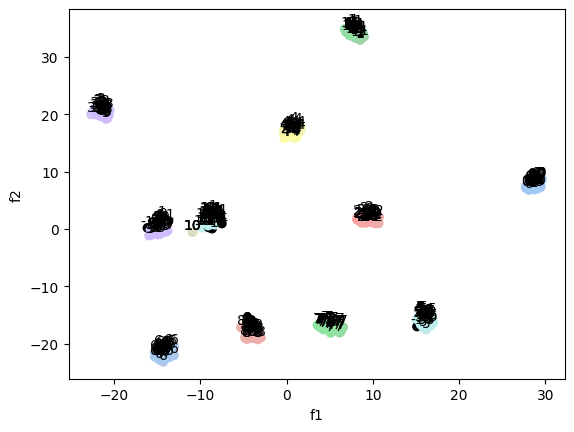

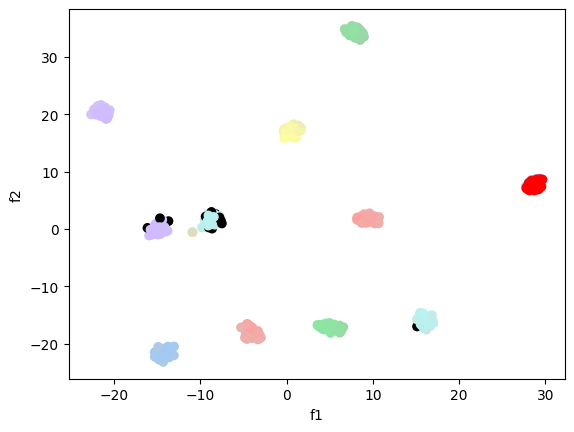

DEBUG flwr 2023-09-17 21:29:39,596 | server.py:173 | evaluate_round 3: strategy sampled 50 clients (out of 50)


['40', '19', '31', '3', '11', '26', '14', '21', '36', '9', '33', '23', '4', '49', '12', '34', '37', '1', '44', '7', '0', '13', '10', '39', '43', '27', '30', '5', '18', '47', '46', '28', '41', '25', '6', '2', '16', '29', '48', '24', '20', '32', '45', '22', '17', '38', '8', '35', '42', '15']
0
Not all features are the same. Possible poisoning
Cluster with different features: [31, 32, 33, 35, 36, 37, 38, 39, 121, 122, 123, 125, 126, 127, 128, 129, 171, 172, 173, 175, 176, 177, 178, 179, 271, 272, 273, 275, 276, 277, 278, 279, 351, 352, 353, 355, 356, 357, 358, 359]
[30, 31, 32, 33, 35, 36, 37, 38, 39, 120, 121, 122, 123, 125, 126, 127, 128, 129, 170, 171, 172, 173, 175, 176, 177, 178, 179, 270, 271, 272, 273, 275, 276, 277, 278, 279, 350, 351, 352, 353, 355, 356, 357, 358, 359]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:29:50,994 | server.py:187 | evaluate_round 3 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:29:50,996 | server.py:222 | fit_round 4: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:30:02,854 | server.py:236 | fit_round 4 received 50 results and 0 failures


total selecting features


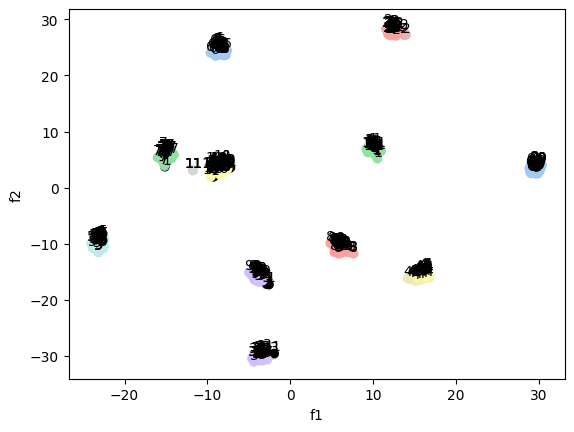

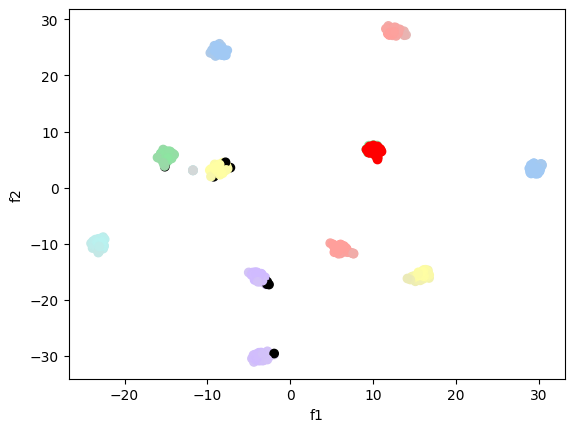

DEBUG flwr 2023-09-17 21:30:49,281 | server.py:173 | evaluate_round 4: strategy sampled 50 clients (out of 50)


['35', '22', '43', '23', '32', '46', '10', '8', '6', '49', '42', '40', '19', '2', '18', '13', '16', '33', '26', '14', '21', '29', '0', '11', '45', '31', '7', '12', '30', '34', '36', '5', '3', '9', '38', '17', '1', '28', '24', '48', '20', '44', '15', '4', '25', '37', '41', '27', '39', '47']
0
Not all features are the same. Possible poisoning
Cluster with different features: [131, 132, 133, 135, 136, 137, 138, 139, 311, 312, 313, 315, 316, 317, 318, 319, 321, 322, 323, 325, 326, 327, 328, 329, 361, 362, 363, 365, 366, 367, 368, 369, 431, 432, 433, 435, 436, 437, 438, 439]
[130, 131, 132, 133, 135, 136, 137, 138, 139, 310, 311, 312, 313, 315, 316, 317, 318, 319, 320, 321, 322, 323, 325, 326, 327, 328, 329, 360, 361, 362, 363, 365, 366, 367, 368, 369, 430, 431, 432, 433, 435, 436, 437, 438, 439]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6


DEBUG flwr 2023-09-17 21:31:01,063 | server.py:187 | evaluate_round 4 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:31:01,065 | server.py:222 | fit_round 5: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:31:12,991 | server.py:236 | fit_round 5 received 50 results and 0 failures


total selecting features


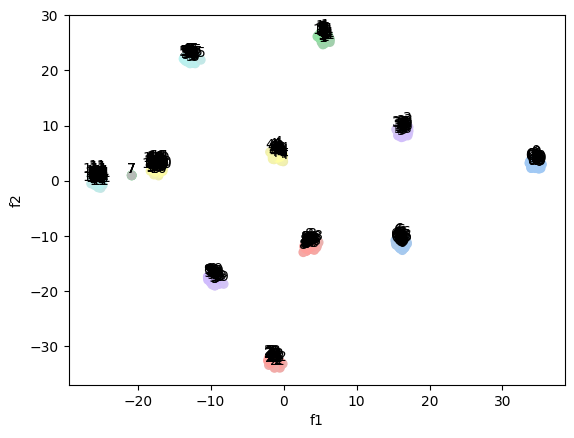

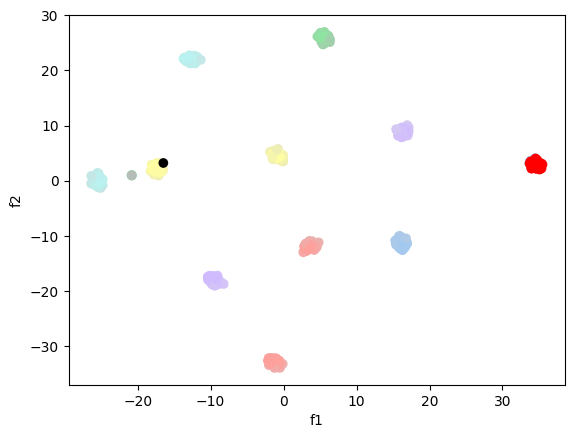

DEBUG flwr 2023-09-17 21:32:02,995 | server.py:173 | evaluate_round 5: strategy sampled 50 clients (out of 50)


['32', '39', '15', '25', '19', '7', '48', '22', '17', '3', '11', '34', '4', '14', '30', '38', '26', '37', '44', '31', '2', '28', '5', '46', '29', '33', '40', '45', '41', '23', '49', '12', '21', '36', '27', '16', '35', '43', '1', '10', '13', '9', '8', '24', '0', '18', '6', '20', '47', '42']
0
Not all features are the same. Possible poisoning
Cluster with different features: [91, 92, 93, 95, 96, 97, 98, 99, 121, 122, 123, 125, 126, 127, 128, 129, 201, 202, 203, 205, 206, 207, 208, 209, 221, 222, 223, 225, 226, 227, 228, 229, 381, 382, 383, 385, 386, 387, 388, 389]
[90, 91, 92, 93, 95, 96, 97, 98, 99, 120, 121, 122, 123, 125, 126, 127, 128, 129, 200, 201, 202, 203, 205, 206, 207, 208, 209, 220, 221, 222, 223, 225, 226, 227, 228, 229, 380, 381, 382, 383, 385, 386, 387, 388, 389]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:32:14,765 | server.py:187 | evaluate_round 5 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:32:14,767 | server.py:222 | fit_round 6: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:32:26,787 | server.py:236 | fit_round 6 received 50 results and 0 failures


total selecting features


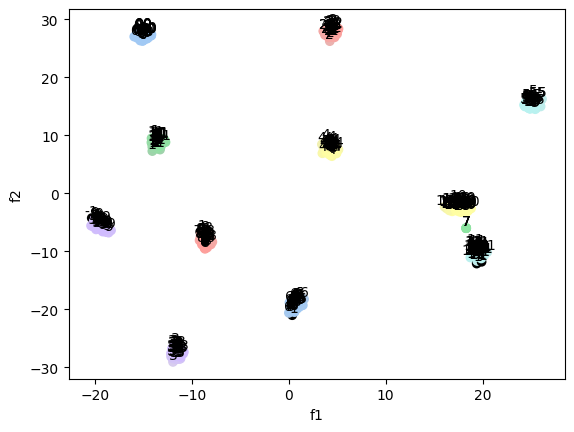

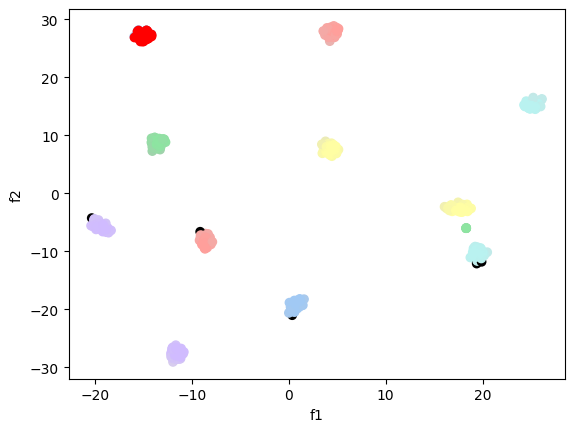

DEBUG flwr 2023-09-17 21:33:04,871 | server.py:173 | evaluate_round 6: strategy sampled 50 clients (out of 50)


['38', '37', '46', '24', '45', '32', '27', '1', '2', '36', '19', '5', '4', '6', '44', '35', '30', '21', '39', '43', '11', '0', '26', '40', '49', '33', '28', '10', '7', '15', '31', '3', '23', '18', '20', '13', '41', '16', '14', '8', '47', '25', '42', '48', '34', '12', '9', '22', '17', '29']
0
Not all features are the same. Possible poisoning
Cluster with different features: [71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 125, 126, 127, 128, 129, 311, 312, 313, 315, 316, 317, 318, 319]
[70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 310, 311, 312, 313, 315, 316, 317, 318, 319]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same:

DEBUG flwr 2023-09-17 21:33:16,616 | server.py:187 | evaluate_round 6 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:33:16,618 | server.py:222 | fit_round 7: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:33:28,516 | server.py:236 | fit_round 7 received 50 results and 0 failures


total selecting features


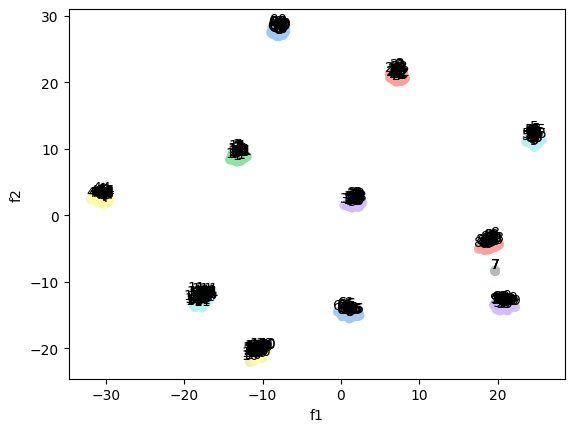

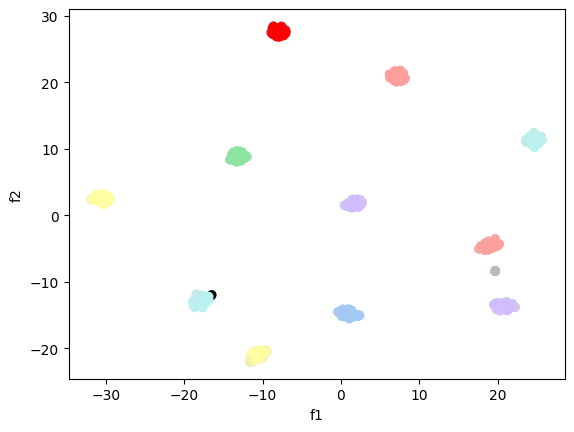

['14', '17', '38', '27', '5', '19', '41', '18', '10', '8', '40', '37', '33', '30', '43', '36', '7', '6', '25', '12', '31', '23', '48', '16', '29', '44', '11', '20', '32', '1', '34', '42', '28', '2', '4', '21', '26', '0', '49', '15', '9', '3', '22', '46', '47', '39', '13', '45', '35', '24']
0
Not all features are the same. Possible poisoning
Cluster with different features: [41, 42, 43, 45, 46, 47, 48, 49, 291, 292, 293, 295, 296, 297, 298, 299, 331, 332, 333, 335, 336, 337, 338, 339, 341, 342, 343, 345, 346, 347, 348, 349, 411, 412, 413, 415, 416, 417, 418, 419]
[40, 41, 42, 43, 45, 46, 47, 48, 49, 290, 291, 292, 293, 295, 296, 297, 298, 299, 330, 331, 332, 333, 335, 336, 337, 338, 339, 340, 341, 342, 343, 345, 346, 347, 348, 349, 410, 411, 412, 413, 415, 416, 417, 418, 419]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:34:18,542 | server.py:173 | evaluate_round 7: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:34:30,302 | server.py:187 | evaluate_round 7 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:34:30,304 | server.py:222 | fit_round 8: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:34:42,186 | server.py:236 | fit_round 8 received 50 results and 0 failures


total selecting features


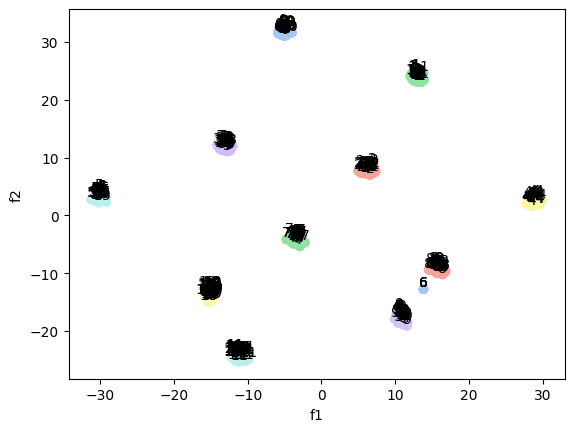

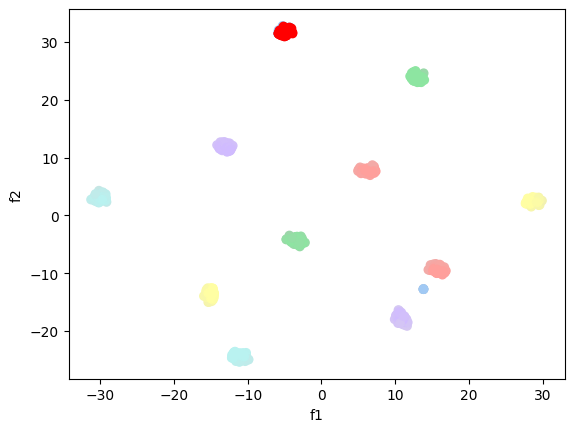

DEBUG flwr 2023-09-17 21:35:26,045 | server.py:173 | evaluate_round 8: strategy sampled 50 clients (out of 50)


['18', '13', '31', '47', '3', '10', '17', '34', '36', '20', '25', '30', '12', '46', '48', '37', '19', '21', '8', '42', '11', '23', '14', '29', '1', '38', '0', '44', '28', '33', '26', '39', '2', '5', '32', '49', '41', '15', '6', '7', '24', '43', '27', '22', '9', '40', '4', '16', '35', '45']
0
Not all features are the same. Possible poisoning
Cluster with different features: [41, 42, 43, 45, 46, 47, 48, 49, 241, 242, 243, 245, 246, 247, 248, 249, 321, 322, 323, 325, 326, 327, 328, 329, 331, 332, 333, 335, 336, 337, 338, 339, 461, 462, 463, 465, 466, 467, 468, 469]
[40, 41, 42, 43, 45, 46, 47, 48, 49, 240, 241, 242, 243, 245, 246, 247, 248, 249, 320, 321, 322, 323, 325, 326, 327, 328, 329, 330, 331, 332, 333, 335, 336, 337, 338, 339, 460, 461, 462, 463, 465, 466, 467, 468, 469]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:35:37,599 | server.py:187 | evaluate_round 8 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:35:37,602 | server.py:222 | fit_round 9: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:35:49,448 | server.py:236 | fit_round 9 received 50 results and 0 failures


total selecting features


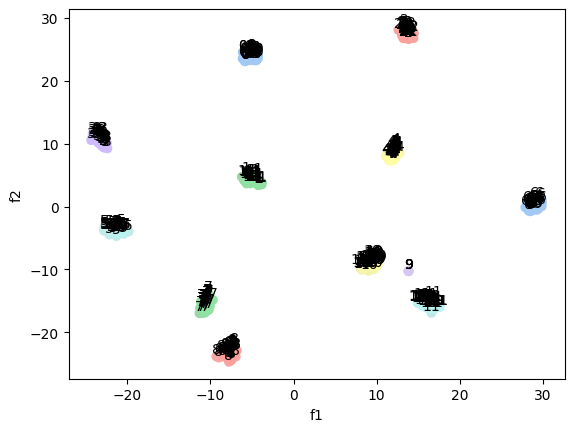

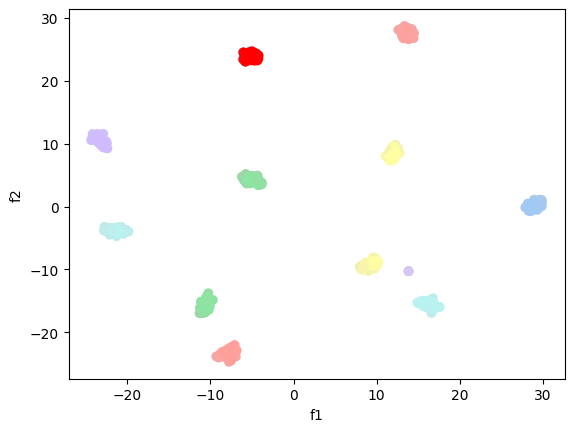

DEBUG flwr 2023-09-17 21:36:30,548 | server.py:173 | evaluate_round 9: strategy sampled 50 clients (out of 50)


['14', '26', '3', '11', '13', '39', '5', '33', '27', '15', '2', '37', '12', '7', '38', '40', '34', '44', '17', '6', '48', '46', '23', '8', '10', '31', '49', '20', '28', '0', '4', '1', '32', '47', '25', '22', '43', '30', '18', '36', '21', '16', '24', '35', '9', '45', '19', '41', '42', '29']
0
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 25, 26, 27, 28, 29, 61, 62, 63, 65, 66, 67, 68, 69, 101, 102, 103, 105, 106, 107, 108, 109, 301, 302, 303, 305, 306, 307, 308, 309, 311, 312, 313, 315, 316, 317, 318, 319]
[20, 21, 22, 23, 25, 26, 27, 28, 29, 60, 61, 62, 63, 65, 66, 67, 68, 69, 100, 101, 102, 103, 105, 106, 107, 108, 109, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 311, 312, 313, 315, 316, 317, 318, 319]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same:

DEBUG flwr 2023-09-17 21:36:41,915 | server.py:187 | evaluate_round 9 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:36:41,917 | server.py:222 | fit_round 10: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:36:53,685 | server.py:236 | fit_round 10 received 50 results and 0 failures


total selecting features


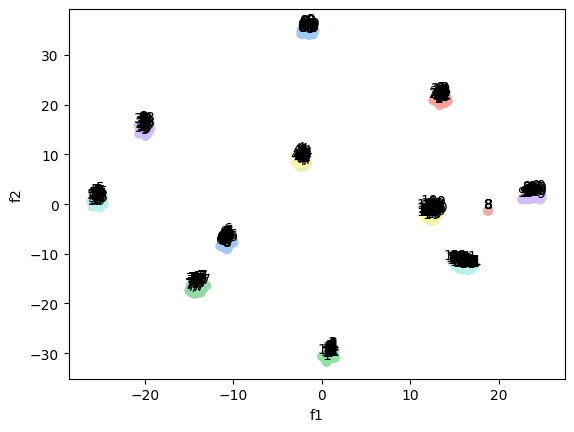

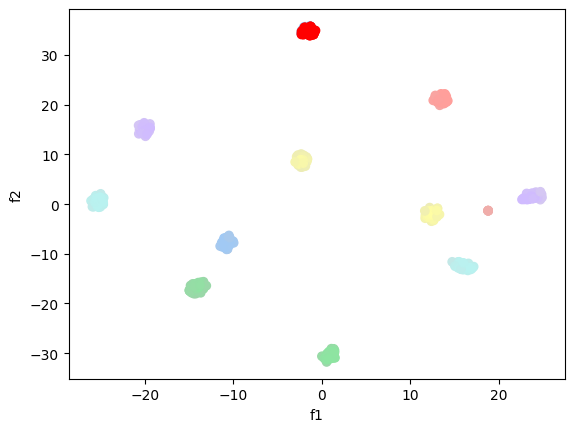

['8', '29', '6', '45', '34', '24', '37', '41', '1', '33', '23', '7', '36', '19', '2', '43', '39', '42', '16', '46', '26', '3', '4', '14', '21', '38', '17', '28', '13', '0', '11', '25', '27', '48', '18', '12', '5', '20', '35', '22', '9', '15', '10', '31', '47', '32', '44', '49', '40', '30']
0
Not all features are the same. Possible poisoning
Cluster with different features: [81, 82, 83, 85, 86, 87, 88, 89, 141, 142, 143, 145, 146, 147, 148, 149, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 223, 225, 226, 227, 228, 229, 361, 362, 363, 365, 366, 367, 368, 369]
[80, 81, 82, 83, 85, 86, 87, 88, 89, 140, 141, 142, 143, 145, 146, 147, 148, 149, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 360, 361, 362, 363, 365, 366, 367, 368, 369]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:37:42,904 | server.py:173 | evaluate_round 10: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:37:54,735 | server.py:187 | evaluate_round 10 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:37:54,737 | server.py:222 | fit_round 11: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:38:06,747 | server.py:236 | fit_round 11 received 50 results and 0 failures


total selecting features


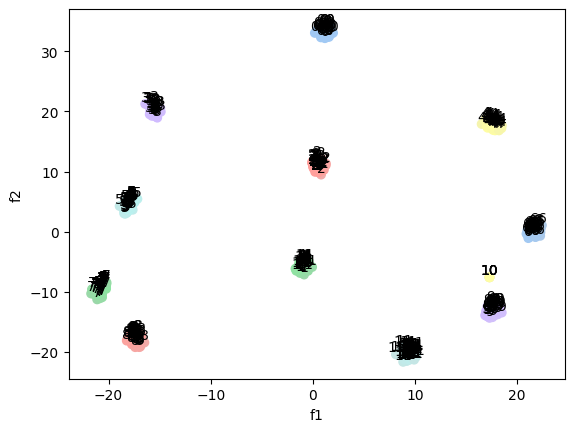

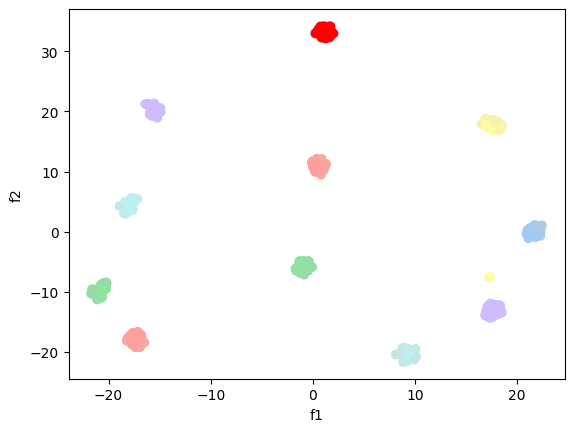

DEBUG flwr 2023-09-17 21:38:51,696 | server.py:173 | evaluate_round 11: strategy sampled 50 clients (out of 50)


['10', '23', '30', '27', '37', '3', '25', '44', '49', '48', '43', '35', '41', '28', '19', '7', '24', '12', '1', '32', '2', '22', '20', '21', '5', '36', '29', '42', '11', '47', '14', '0', '40', '46', '38', '16', '13', '4', '33', '9', '15', '8', '34', '45', '18', '17', '39', '31', '6', '26']
0
Not all features are the same. Possible poisoning
Cluster with different features: [51, 52, 53, 55, 56, 57, 58, 59, 181, 182, 183, 185, 186, 187, 188, 189, 201, 202, 203, 205, 206, 207, 208, 209, 241, 242, 243, 245, 246, 247, 248, 249, 371, 372, 373, 375, 376, 377, 378, 379]
[50, 51, 52, 53, 55, 56, 57, 58, 59, 180, 181, 182, 183, 185, 186, 187, 188, 189, 200, 201, 202, 203, 205, 206, 207, 208, 209, 240, 241, 242, 243, 245, 246, 247, 248, 249, 370, 371, 372, 373, 375, 376, 377, 378, 379]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:39:03,292 | server.py:187 | evaluate_round 11 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:39:03,294 | server.py:222 | fit_round 12: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:39:14,756 | server.py:236 | fit_round 12 received 50 results and 0 failures


total selecting features


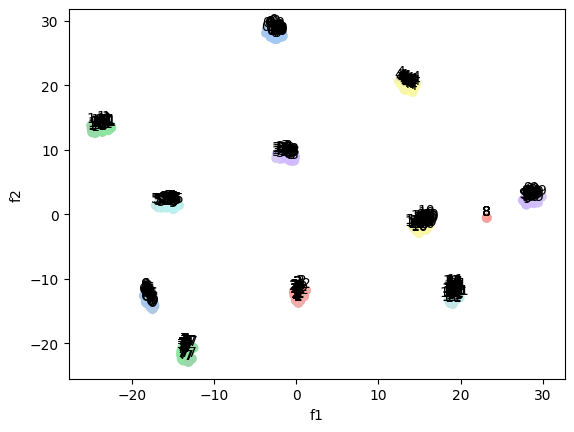

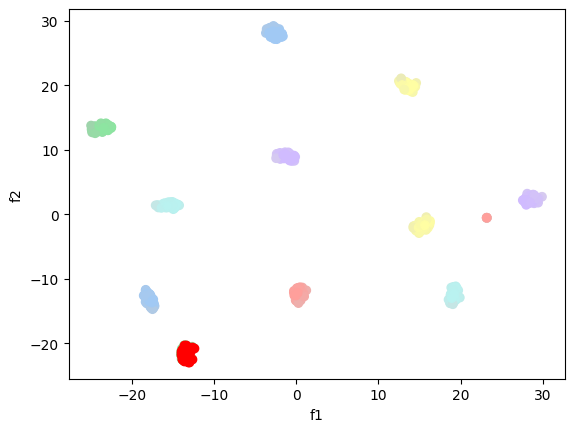

DEBUG flwr 2023-09-17 21:40:00,091 | server.py:173 | evaluate_round 12: strategy sampled 50 clients (out of 50)


['23', '45', '39', '43', '0', '37', '12', '8', '14', '24', '13', '46', '10', '31', '29', '9', '26', '28', '40', '19', '21', '27', '41', '15', '42', '4', '33', '11', '1', '48', '18', '32', '38', '22', '6', '34', '36', '44', '7', '49', '35', '20', '3', '16', '30', '47', '17', '2', '5', '25']
0
Not all features are the same. Possible poisoning
Cluster with different features: [251, 252, 253, 255, 256, 257, 258, 259, 281, 282, 283, 285, 286, 287, 288, 289, 421, 422, 423, 425, 426, 427, 428, 429, 471, 472, 473, 475, 476, 477, 478, 479, 481, 482, 483, 485, 486, 487, 488, 489]
[250, 251, 252, 253, 255, 256, 257, 258, 259, 280, 281, 282, 283, 285, 286, 287, 288, 289, 420, 421, 422, 423, 425, 426, 427, 428, 429, 470, 471, 472, 473, 475, 476, 477, 478, 479, 480, 481, 482, 483, 485, 486, 487, 488, 489]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6


DEBUG flwr 2023-09-17 21:40:11,345 | server.py:187 | evaluate_round 12 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:40:11,348 | server.py:222 | fit_round 13: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:40:23,137 | server.py:236 | fit_round 13 received 50 results and 0 failures


total selecting features


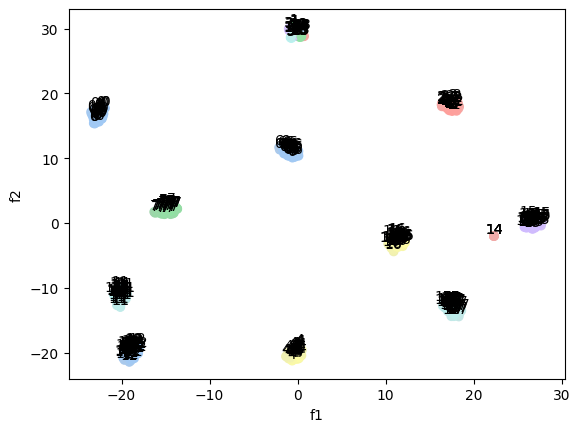

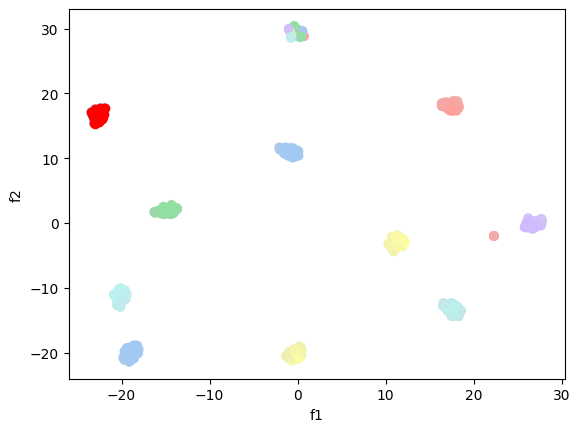

DEBUG flwr 2023-09-17 21:41:06,067 | server.py:173 | evaluate_round 13: strategy sampled 50 clients (out of 50)


['34', '25', '35', '31', '12', '28', '22', '17', '40', '0', '23', '20', '24', '49', '19', '14', '1', '8', '6', '15', '27', '11', '26', '29', '43', '13', '38', '36', '33', '7', '48', '42', '21', '47', '41', '5', '3', '32', '44', '30', '10', '2', '39', '16', '45', '37', '9', '18', '4', '46']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
All cluster features are the 

DEBUG flwr 2023-09-17 21:41:17,786 | server.py:187 | evaluate_round 13 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:41:17,788 | server.py:222 | fit_round 14: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:41:29,612 | server.py:236 | fit_round 14 received 50 results and 0 failures


total selecting features


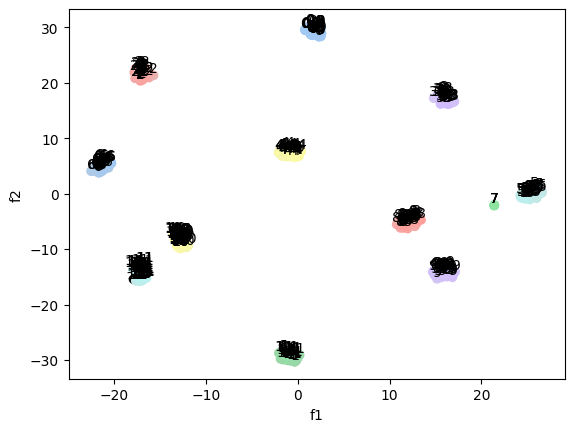

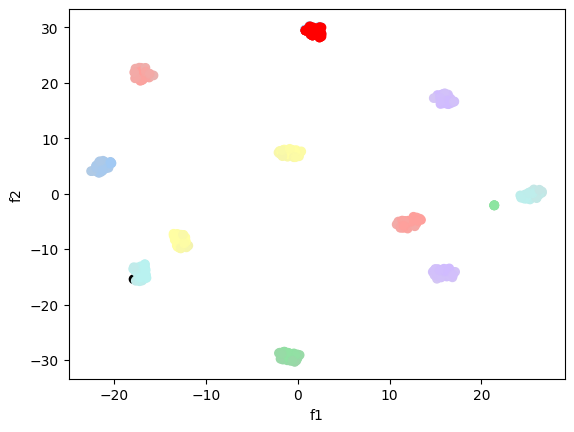

DEBUG flwr 2023-09-17 21:42:08,493 | server.py:173 | evaluate_round 14: strategy sampled 50 clients (out of 50)


['45', '2', '29', '0', '19', '34', '22', '6', '43', '18', '39', '10', '7', '16', '5', '35', '11', '47', '42', '38', '1', '3', '46', '13', '41', '20', '14', '21', '25', '15', '12', '17', '33', '4', '8', '40', '26', '23', '37', '48', '24', '44', '36', '28', '49', '32', '9', '30', '31', '27']
0
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 141, 142, 143, 145, 146, 147, 148, 149, 201, 202, 203, 205, 206, 207, 208, 209, 211, 212, 213, 215, 216, 217, 218, 219, 331, 332, 333, 335, 336, 337, 338, 339]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 140, 141, 142, 143, 145, 146, 147, 148, 149, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 330, 331, 332, 333, 335, 336, 337, 338, 339]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:42:19,921 | server.py:187 | evaluate_round 14 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:42:19,923 | server.py:222 | fit_round 15: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:42:31,785 | server.py:236 | fit_round 15 received 50 results and 0 failures


total selecting features


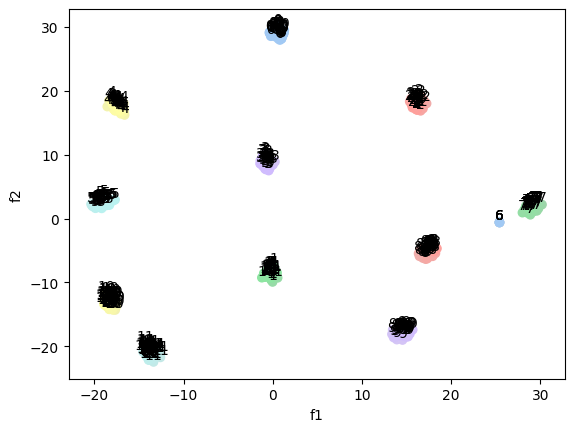

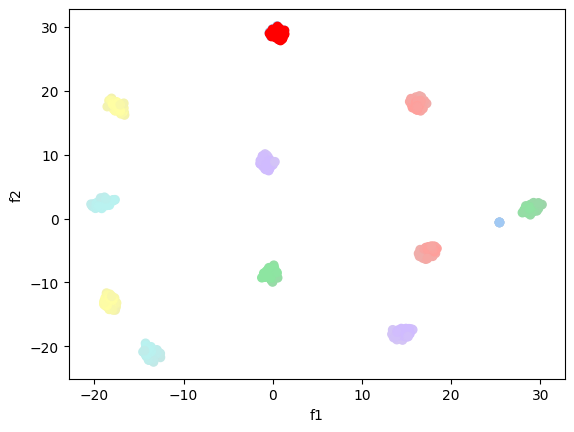

DEBUG flwr 2023-09-17 21:43:10,621 | server.py:173 | evaluate_round 15: strategy sampled 50 clients (out of 50)


['37', '12', '16', '31', '0', '25', '34', '15', '18', '36', '43', '6', '42', '47', '14', '19', '39', '30', '1', '7', '29', '45', '35', '22', '23', '40', '26', '9', '32', '48', '2', '13', '20', '8', '24', '49', '5', '3', '46', '28', '10', '4', '38', '27', '17', '21', '33', '11', '44', '41']
0
Not all features are the same. Possible poisoning
Cluster with different features: [181, 182, 183, 185, 186, 187, 188, 189, 301, 302, 303, 305, 306, 307, 308, 309, 361, 362, 363, 365, 366, 367, 368, 369, 371, 372, 373, 375, 376, 377, 378, 379, 411, 412, 413, 415, 416, 417, 418, 419]
[180, 181, 182, 183, 185, 186, 187, 188, 189, 300, 301, 302, 303, 305, 306, 307, 308, 309, 360, 361, 362, 363, 365, 366, 367, 368, 369, 370, 371, 372, 373, 375, 376, 377, 378, 379, 410, 411, 412, 413, 415, 416, 417, 418, 419]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6


DEBUG flwr 2023-09-17 21:43:22,444 | server.py:187 | evaluate_round 15 received 50 results and 0 failures
INFO flwr 2023-09-17 21:43:22,445 | server.py:153 | FL finished in 1025.2498200051486
INFO flwr 2023-09-17 21:43:22,447 | app.py:225 | app_fit: losses_distributed [(1, 0.10834740829467773), (2, 0.06492555308341978), (3, 0.046052710175514225), (4, 0.039054308891296394), (5, 0.030062253177165994), (6, 0.02538736408948899), (7, 0.02194507567584515), (8, 0.019758727565407752), (9, 0.016756181821227074), (10, 0.01570661374181509), (11, 0.014238213561475279), (12, 0.01303550210595131), (13, 0.01178375921398401), (14, 0.01110644531995058), (15, 0.010493130952119827)]
INFO flwr 2023-09-17 21:43:22,447 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-17 21:43:22,448 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.283), (2, 0.6150000000000001), (3, 0.711), (4, 0.7340000000000002), (5, 0.8160000000000001), (6, 0.836), (7, 0.872), (8, 0.8859999999999997), (9

NameError: name 'end_time' is not defined

In [57]:
start = time.time()

sim, cli_list, poison_list, poison_ids, _, _ = run_exp_type_num_rounds(num_rounds=10, trainloaders=trainloaders, valloaders=valloaders, 
                                                                 is_eliminating_clients=False, show_tsne_graphs=True)
end = time.time()

In [58]:
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1037.445332288742 seconds


In [59]:
sim.losses_distributed

[(1, 0.10834740829467773),
 (2, 0.06492555308341978),
 (3, 0.046052710175514225),
 (4, 0.039054308891296394),
 (5, 0.030062253177165994),
 (6, 0.02538736408948899),
 (7, 0.02194507567584515),
 (8, 0.019758727565407752),
 (9, 0.016756181821227074),
 (10, 0.01570661374181509),
 (11, 0.014238213561475279),
 (12, 0.01303550210595131),
 (13, 0.01178375921398401),
 (14, 0.01110644531995058),
 (15, 0.010493130952119827)]

In [60]:
# Your list of tuples
data = sim.metrics_distributed['accuracy']

# Extract the second values from each tuple using a list comprehension
second_values = [t[1] for t in data]

# Print the list of second values
print(second_values)

[0.283, 0.6150000000000001, 0.711, 0.7340000000000002, 0.8160000000000001, 0.836, 0.872, 0.8859999999999997, 0.9119999999999999, 0.9150000000000003, 0.9200000000000002, 0.9320000000000002, 0.9370000000000002, 0.9400000000000002, 0.9409999999999998]


#### with elimination of clients

INFO flwr 2023-09-17 21:45:33,485 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-09-17 21:45:40,274	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-09-17 21:45:41,274 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 10.0, 'GPU': 1.0, 'object_store_memory': 25883124940.0, 'accelerator_type:RTX': 1.0, 'node:193.1.133.164': 1.0, 'node:__internal_head__': 1.0, 'memory': 51766249883.0}
INFO flwr 2023-09-17 21:45:41,275 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.1}
INFO flwr 2023-09-17 21:45:41,310 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO flwr 2023-09-17 21:45:41,313 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-17 21:45:41,314 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-09-17 21:45:41,316 | server.py:276 | Reques

Attempting to initialize parameters


INFO flwr 2023-09-17 21:45:47,290 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-09-17 21:45:47,292 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-17 21:45:47,293 | server.py:104 | FL starting
DEBUG flwr 2023-09-17 21:45:47,294 | server.py:222 | fit_round 1: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:46:01,116 | server.py:236 | fit_round 1 received 50 results and 0 failures


total selecting features


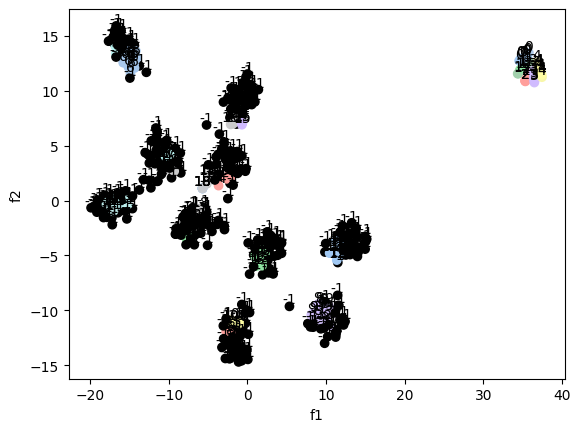

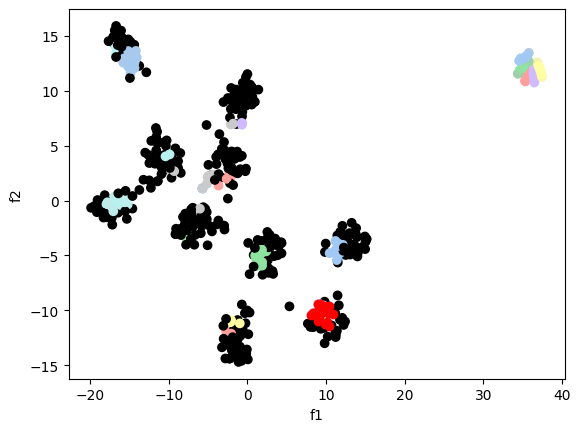

WARNING flwr 2023-09-17 21:46:39,919 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-17 21:46:39,920 | server.py:173 | evaluate_round 1: strategy sampled 50 clients (out of 50)


['36', '16', '43', '22', '38', '12', '44', '8', '24', '18', '7', '13', '48', '26', '30', '34', '27', '9', '41', '5', '46', '2', '25', '1', '28', '14', '29', '11', '23', '10', '47', '32', '45', '19', '15', '20', '4', '37', '17', '6', '21', '31', '33', '0', '39', '40', '3', '42', '35', '49']
0
Not all features are the same. Possible poisoning
Cluster with different features: [461, 462, 463, 465, 466, 467, 468, 469]
[460, 461, 462, 463, 465, 466, 467, 468, 469]
1
Not all features are the same. Possible poisoning
Cluster with different features: [361, 362, 363, 365, 366, 367, 368, 369]
[360, 361, 362, 363, 365, 366, 367, 368, 369]
2
Not all features are the same. Possible poisoning
Cluster with different features: [191, 192, 193, 195, 196, 197, 198, 199]
[190, 191, 192, 193, 195, 196, 197, 198, 199]
3
Not all features are the same. Possible poisoning
Cluster with different features: [211, 212, 213, 215, 216, 217, 218, 219]
[210, 211, 212, 213, 215, 216, 217, 218, 219]
4
Not all features ar

DEBUG flwr 2023-09-17 21:46:51,071 | server.py:187 | evaluate_round 1 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:46:51,073 | server.py:222 | fit_round 2: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:47:03,193 | server.py:236 | fit_round 2 received 50 results and 0 failures


total selecting features


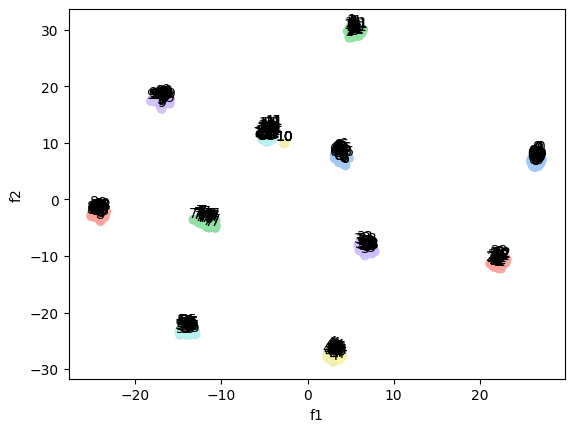

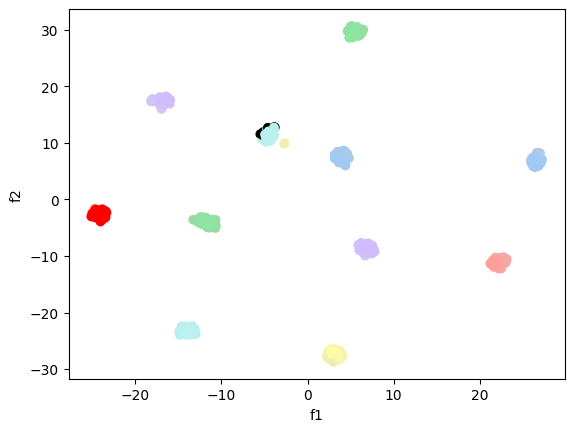

DEBUG flwr 2023-09-17 21:47:42,129 | server.py:173 | evaluate_round 2: strategy sampled 50 clients (out of 50)


['31', '18', '5', '24', '37', '17', '33', '35', '43', '0', '39', '36', '12', '19', '21', '44', '27', '4', '34', '15', '48', '45', '14', '25', '2', '32', '46', '23', '40', '41', '8', '49', '3', '28', '6', '7', '26', '9', '47', '16', '30', '38', '13', '11', '20', '22', '42', '1', '10', '29']
0
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 25, 26, 27, 28, 29, 171, 172, 173, 175, 176, 177, 178, 179, 241, 242, 243, 245, 246, 247, 248, 249, 321, 322, 323, 325, 326, 327, 328, 329, 471, 472, 473, 475, 476, 477, 478, 479]
[20, 21, 22, 23, 25, 26, 27, 28, 29, 170, 171, 172, 173, 175, 176, 177, 178, 179, 240, 241, 242, 243, 245, 246, 247, 248, 249, 320, 321, 322, 323, 325, 326, 327, 328, 329, 470, 471, 472, 473, 475, 476, 477, 478, 479]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:47:54,548 | server.py:187 | evaluate_round 2 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:47:54,551 | server.py:222 | fit_round 3: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:48:06,904 | server.py:236 | fit_round 3 received 50 results and 0 failures


total selecting features


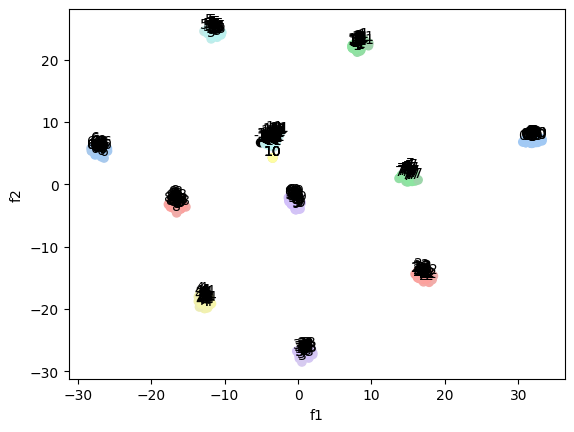

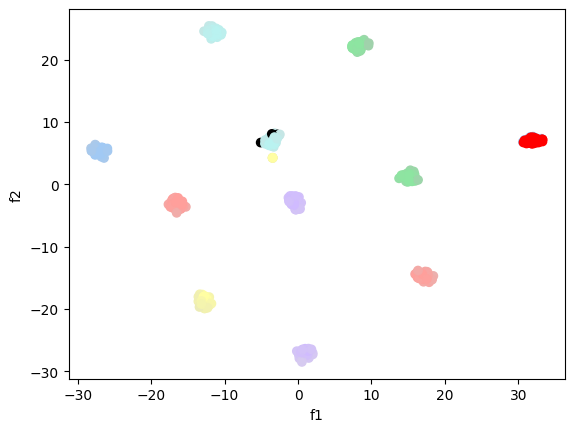

DEBUG flwr 2023-09-17 21:48:47,428 | server.py:173 | evaluate_round 3: strategy sampled 50 clients (out of 50)


['8', '24', '14', '38', '29', '21', '3', '48', '18', '34', '31', '33', '2', '12', '37', '0', '49', '22', '6', '15', '28', '43', '25', '17', '20', '19', '26', '16', '45', '32', '40', '47', '42', '23', '41', '27', '11', '7', '1', '46', '9', '5', '36', '13', '35', '44', '39', '10', '30', '4']
0
Not all features are the same. Possible poisoning
Cluster with different features: [61, 62, 63, 65, 66, 67, 68, 69, 121, 122, 123, 125, 126, 127, 128, 129, 381, 382, 383, 385, 386, 387, 388, 389, 411, 412, 413, 415, 416, 417, 418, 419, 491, 492, 493, 495, 496, 497, 498, 499]
[60, 61, 62, 63, 65, 66, 67, 68, 69, 120, 121, 122, 123, 125, 126, 127, 128, 129, 380, 381, 382, 383, 385, 386, 387, 388, 389, 410, 411, 412, 413, 415, 416, 417, 418, 419, 490, 491, 492, 493, 495, 496, 497, 498, 499]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:48:59,294 | server.py:187 | evaluate_round 3 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:48:59,296 | server.py:222 | fit_round 4: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:49:10,936 | server.py:236 | fit_round 4 received 50 results and 0 failures


total selecting features


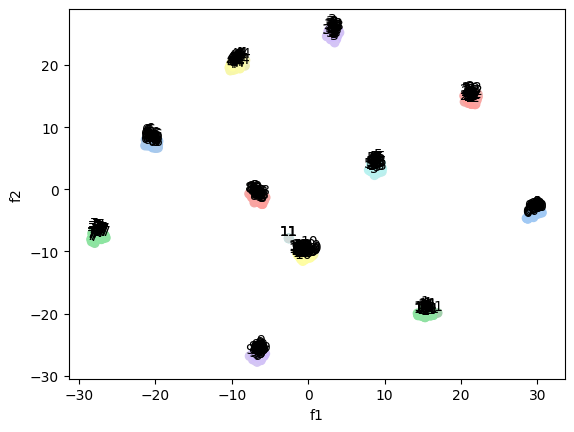

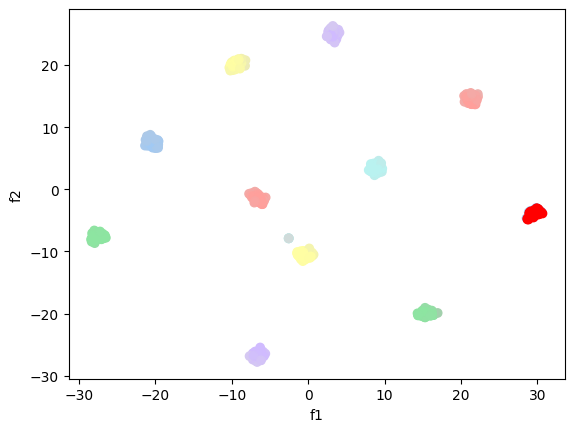

DEBUG flwr 2023-09-17 21:49:51,488 | server.py:173 | evaluate_round 4: strategy sampled 50 clients (out of 50)


['8', '30', '41', '4', '24', '49', '16', '31', '39', '17', '36', '14', '44', '21', '34', '25', '43', '27', '12', '37', '20', '5', '26', '18', '1', '3', '15', '19', '35', '38', '6', '40', '7', '10', '0', '45', '33', '22', '32', '13', '48', '9', '42', '46', '2', '47', '29', '28', '11', '23']
0
Not all features are the same. Possible poisoning
Cluster with different features: [31, 32, 33, 35, 36, 37, 38, 39, 211, 212, 213, 215, 216, 217, 218, 219, 241, 242, 243, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259, 441, 442, 443, 445, 446, 447, 448, 449]
[30, 31, 32, 33, 35, 36, 37, 38, 39, 210, 211, 212, 213, 215, 216, 217, 218, 219, 240, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 440, 441, 442, 443, 445, 446, 447, 448, 449]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:50:03,353 | server.py:187 | evaluate_round 4 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:50:03,355 | server.py:222 | fit_round 5: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:50:15,498 | server.py:236 | fit_round 5 received 50 results and 0 failures


total selecting features


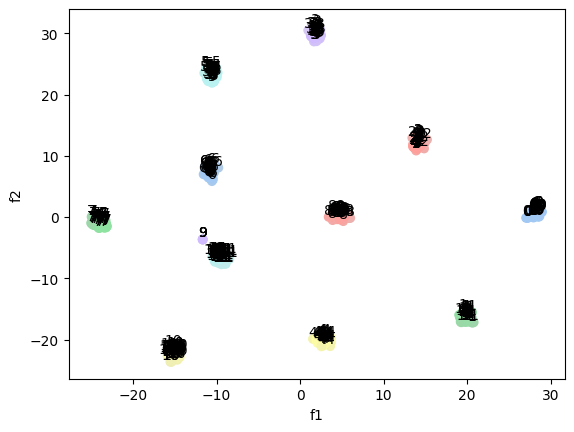

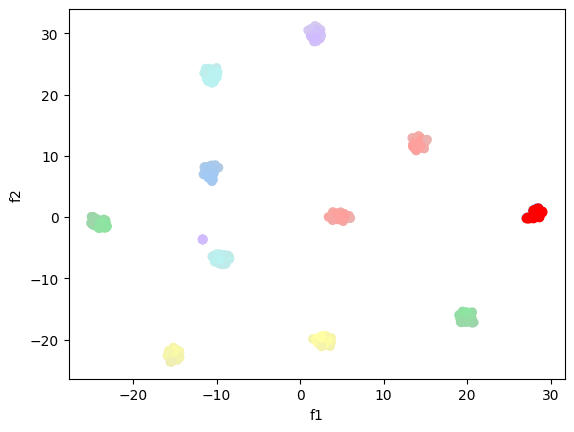

DEBUG flwr 2023-09-17 21:50:57,826 | server.py:173 | evaluate_round 5: strategy sampled 50 clients (out of 50)


['39', '23', '13', '47', '32', '46', '14', '2', '6', '33', '16', '40', '41', '27', '7', '0', '19', '24', '10', '38', '17', '44', '30', '18', '20', '9', '15', '35', '1', '8', '11', '28', '25', '3', '43', '21', '22', '5', '36', '45', '37', '29', '26', '48', '4', '42', '34', '49', '31', '12']
0
Not all features are the same. Possible poisoning
Cluster with different features: [71, 72, 73, 75, 76, 77, 78, 79, 281, 282, 283, 285, 286, 287, 288, 289, 331, 332, 333, 335, 336, 337, 338, 339, 371, 372, 373, 375, 376, 377, 378, 379, 441, 442, 443, 445, 446, 447, 448, 449]
[70, 71, 72, 73, 75, 76, 77, 78, 79, 280, 281, 282, 283, 285, 286, 287, 288, 289, 330, 331, 332, 333, 335, 336, 337, 338, 339, 370, 371, 372, 373, 375, 376, 377, 378, 379, 440, 441, 442, 443, 445, 446, 447, 448, 449]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:51:09,785 | server.py:187 | evaluate_round 5 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:51:09,787 | server.py:222 | fit_round 6: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:51:22,212 | server.py:236 | fit_round 6 received 50 results and 0 failures


total selecting features


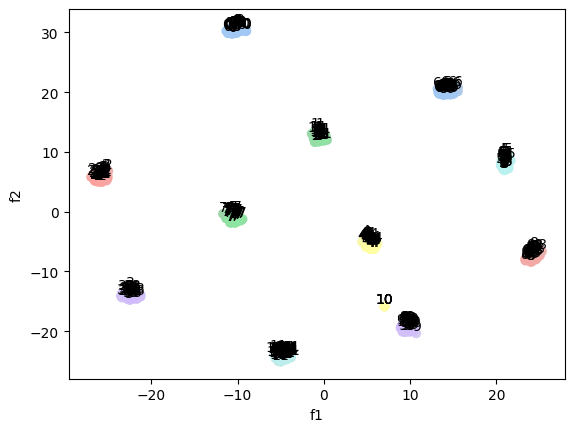

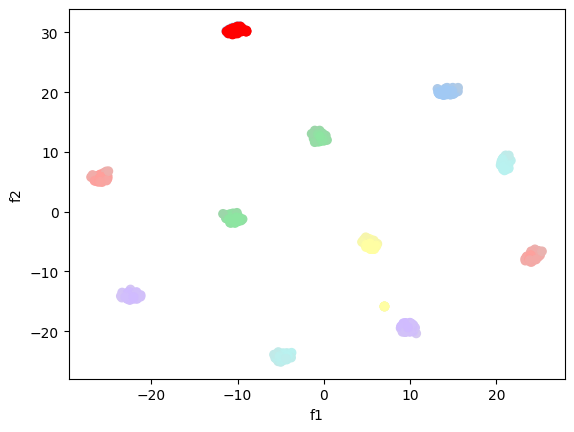

DEBUG flwr 2023-09-17 21:52:02,007 | server.py:173 | evaluate_round 6: strategy sampled 50 clients (out of 50)


['23', '24', '39', '33', '42', '20', '35', '25', '15', '43', '17', '22', '31', '2', '44', '21', '36', '10', '8', '37', '19', '0', '13', '41', '14', '1', '11', '3', '28', '48', '45', '7', '34', '49', '29', '30', '18', '16', '12', '46', '38', '6', '4', '40', '9', '5', '32', '27', '26', '47']
0
Not all features are the same. Possible poisoning
Cluster with different features: [131, 132, 133, 135, 136, 137, 138, 139, 251, 252, 253, 255, 256, 257, 258, 259, 271, 272, 273, 275, 276, 277, 278, 279, 421, 422, 423, 425, 426, 427, 428, 429, 451, 452, 453, 455, 456, 457, 458, 459]
[130, 131, 132, 133, 135, 136, 137, 138, 139, 250, 251, 252, 253, 255, 256, 257, 258, 259, 270, 271, 272, 273, 275, 276, 277, 278, 279, 420, 421, 422, 423, 425, 426, 427, 428, 429, 450, 451, 452, 453, 455, 456, 457, 458, 459]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6


DEBUG flwr 2023-09-17 21:52:13,523 | server.py:187 | evaluate_round 6 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:52:13,525 | server.py:222 | fit_round 7: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:52:25,524 | server.py:236 | fit_round 7 received 50 results and 0 failures


total selecting features


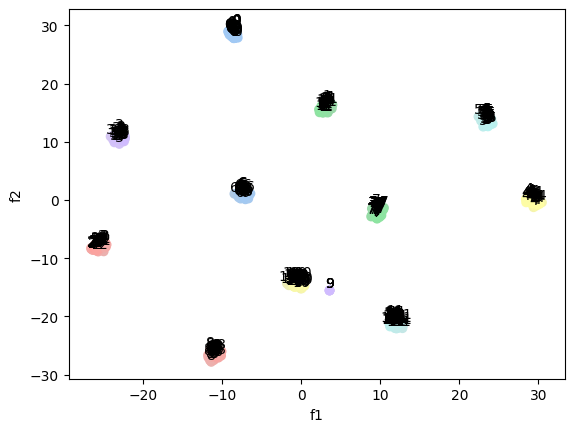

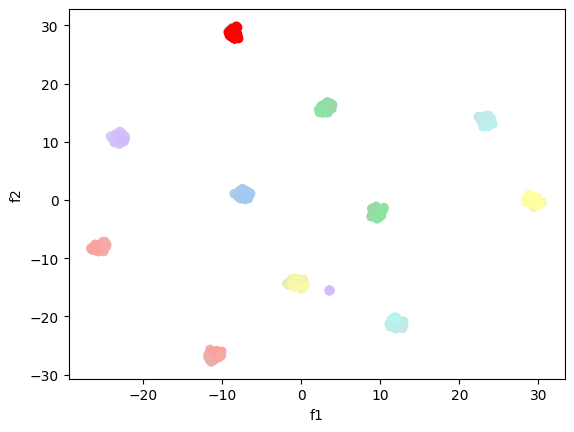

DEBUG flwr 2023-09-17 21:53:06,153 | server.py:173 | evaluate_round 7: strategy sampled 50 clients (out of 50)


['43', '11', '46', '3', '2', '1', '7', '42', '40', '19', '29', '28', '25', '6', '9', '18', '22', '27', '37', '15', '14', '48', '33', '24', '34', '41', '38', '35', '0', '16', '26', '17', '12', '36', '5', '20', '10', '21', '4', '32', '30', '39', '23', '13', '31', '49', '45', '44', '8', '47']
0
Not all features are the same. Possible poisoning
Cluster with different features: [31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 341, 342, 343, 345, 346, 347, 348, 349, 381, 382, 383, 385, 386, 387, 388, 389]
[30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 340, 341, 342, 343, 345, 346, 347, 348, 349, 380, 381, 382, 383, 385, 386, 387, 388, 389]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster 

DEBUG flwr 2023-09-17 21:53:18,119 | server.py:187 | evaluate_round 7 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:53:18,121 | server.py:222 | fit_round 8: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:53:30,421 | server.py:236 | fit_round 8 received 50 results and 0 failures


total selecting features


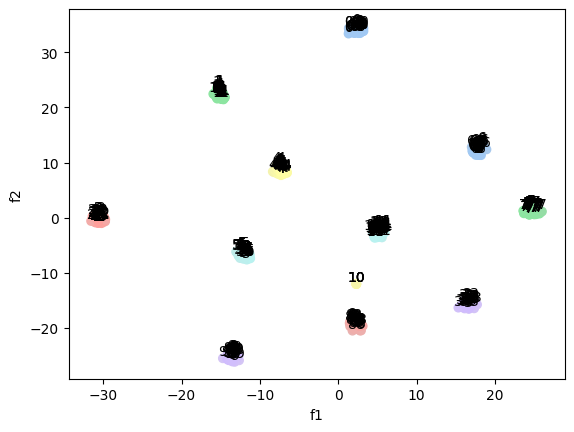

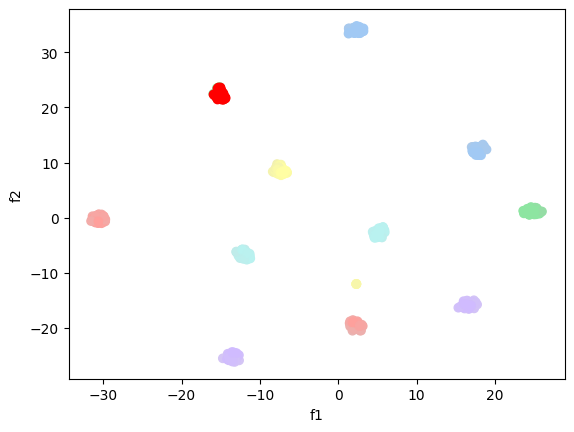

DEBUG flwr 2023-09-17 21:54:08,962 | server.py:173 | evaluate_round 8: strategy sampled 50 clients (out of 50)


['34', '32', '31', '38', '18', '11', '21', '47', '40', '10', '6', '20', '48', '33', '1', '28', '5', '4', '8', '26', '49', '35', '3', '12', '24', '25', '39', '36', '7', '42', '9', '41', '37', '29', '14', '22', '0', '27', '13', '43', '16', '44', '45', '23', '19', '46', '2', '30', '15', '17']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [141, 142, 143, 145, 146, 147, 148, 149, 161, 162, 163, 165, 166, 167, 168, 169, 171, 172, 173, 175, 176, 177, 178, 179, 221, 222, 223, 225, 226, 227, 228, 229, 461, 462, 463, 465, 466, 467, 468, 469]
[140, 141, 142, 143, 145, 146, 147, 148, 149, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 220, 221, 222, 223, 225, 226, 227, 228, 229, 460, 461, 462, 463, 465, 466, 467, 468, 469]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6


DEBUG flwr 2023-09-17 21:54:20,930 | server.py:187 | evaluate_round 8 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:54:20,932 | server.py:222 | fit_round 9: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:54:32,892 | server.py:236 | fit_round 9 received 50 results and 0 failures


total selecting features


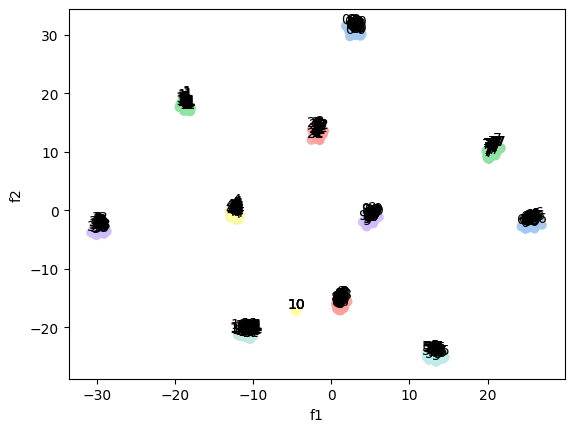

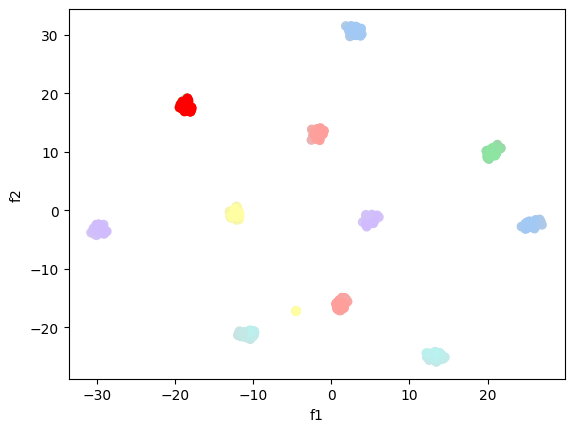

['42', '29', '43', '11', '46', '9', '32', '40', '4', '6', '5', '31', '34', '15', '7', '2', '13', '18', '39', '36', '24', '27', '26', '0', '45', '8', '28', '14', '22', '23', '48', '17', '1', '3', '21', '25', '33', '12', '44', '16', '38', '20', '49', '35', '10', '37', '19', '41', '47', '30']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [81, 82, 83, 85, 86, 87, 88, 89, 101, 102, 103, 105, 106, 107, 108, 109, 151, 152, 153, 155, 156, 157, 158, 159, 321, 322, 323, 325, 326, 327, 328, 329, 331, 332, 333, 335, 336, 337, 338, 339]
[80, 81, 82, 83, 85, 86, 87, 88, 89, 100, 101, 102, 103, 105, 106, 107, 108, 109, 150, 151, 152, 153, 155, 156, 157, 158, 159, 320, 321, 322, 323, 325, 326, 327, 328, 329, 330, 331, 332, 333, 335, 336, 337, 338, 339]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:55:11,489 | server.py:173 | evaluate_round 9: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:55:23,551 | server.py:187 | evaluate_round 9 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:55:23,553 | server.py:222 | fit_round 10: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:55:35,648 | server.py:236 | fit_round 10 received 50 results and 0 failures


total selecting features


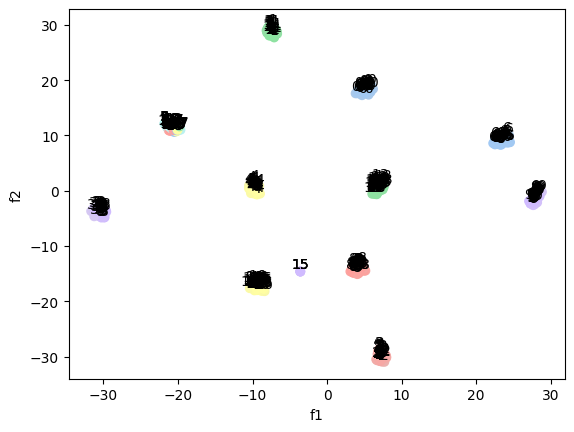

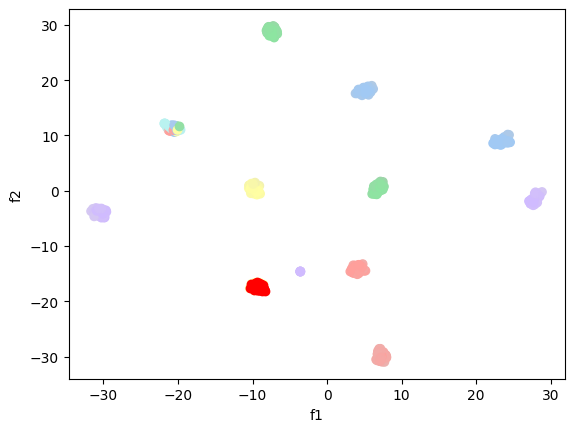

DEBUG flwr 2023-09-17 21:56:17,615 | server.py:173 | evaluate_round 10: strategy sampled 50 clients (out of 50)


['28', '39', '10', '8', '6', '43', '16', '36', '49', '21', '47', '20', '40', '25', '33', '38', '24', '18', '44', '5', '14', '35', '11', '31', '46', '22', '34', '48', '42', '17', '26', '32', '41', '0', '15', '3', '13', '9', '1', '30', '37', '27', '45', '19', '7', '23', '29', '12', '4', '2']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
Not all features are the same. Possible poisoning
Cluster with different features: [192, 352, 382, 482, 492]
[190, 192, 350, 352, 380, 382, 480, 482, 490, 492]
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the s

DEBUG flwr 2023-09-17 21:56:29,366 | server.py:187 | evaluate_round 10 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:56:29,368 | server.py:222 | fit_round 11: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:56:41,464 | server.py:236 | fit_round 11 received 50 results and 0 failures


total selecting features


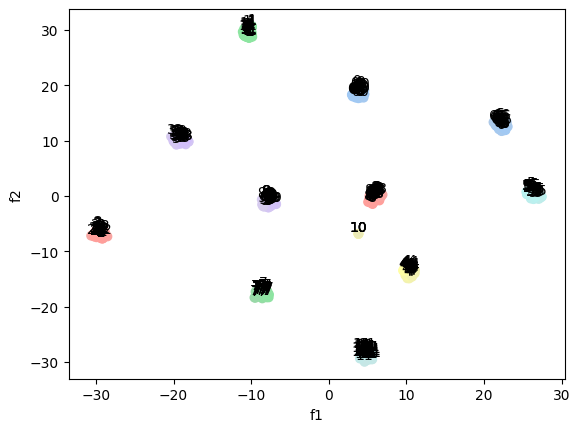

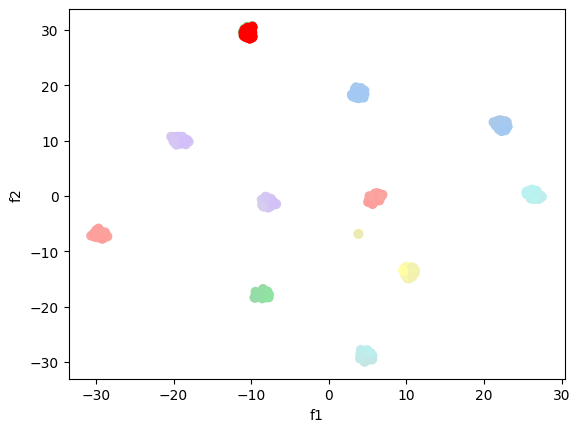

['30', '28', '6', '12', '8', '18', '21', '22', '34', '27', '39', '4', '35', '20', '36', '47', '38', '11', '17', '42', '13', '16', '43', '19', '23', '46', '3', '7', '48', '5', '1', '31', '49', '15', '29', '0', '10', '2', '25', '41', '44', '40', '14', '24', '33', '45', '26', '32', '9', '37']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [111, 112, 113, 115, 116, 117, 118, 119, 261, 262, 263, 265, 266, 267, 268, 269, 291, 292, 293, 295, 296, 297, 298, 299, 301, 302, 303, 305, 306, 307, 308, 309, 371, 372, 373, 375, 376, 377, 378, 379]
[110, 111, 112, 113, 115, 116, 117, 118, 119, 260, 261, 262, 263, 265, 266, 267, 268, 269, 290, 291, 292, 293, 295, 296, 297, 298, 299, 300, 301, 302, 303, 305, 306, 307, 308, 309, 370, 371, 372, 373, 375, 376, 377, 378, 379]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6


DEBUG flwr 2023-09-17 21:57:22,207 | server.py:173 | evaluate_round 11: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:57:34,004 | server.py:187 | evaluate_round 11 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:57:34,006 | server.py:222 | fit_round 12: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:57:46,350 | server.py:236 | fit_round 12 received 50 results and 0 failures


total selecting features


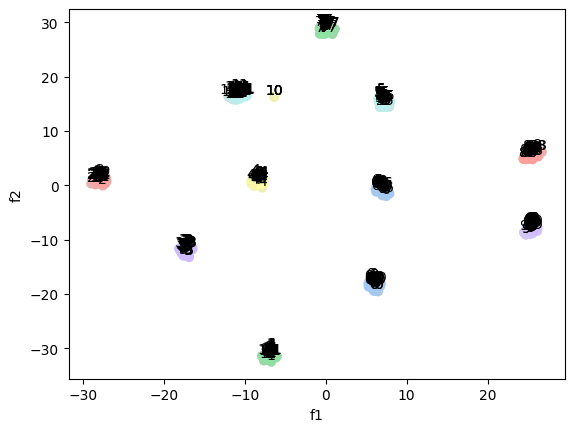

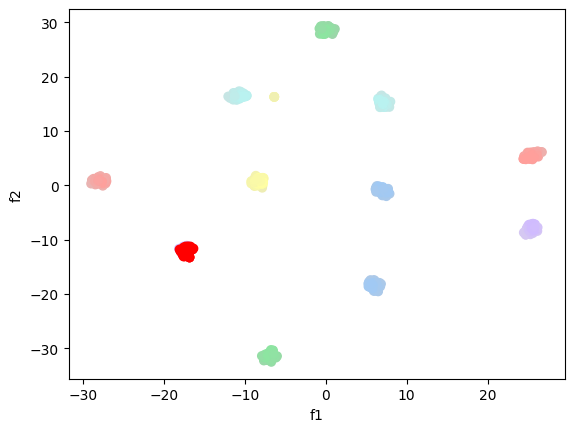

DEBUG flwr 2023-09-17 21:58:28,022 | server.py:173 | evaluate_round 12: strategy sampled 50 clients (out of 50)


['16', '14', '28', '39', '34', '47', '42', '2', '11', '24', '15', '10', '0', '41', '1', '6', '13', '17', '12', '25', '27', '4', '45', '29', '36', '9', '5', '37', '30', '19', '26', '33', '31', '22', '32', '40', '38', '3', '46', '44', '21', '43', '35', '48', '18', '23', '8', '20', '7', '49']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
Not all features are the same. Possible poisoning
Cluster with different features: [71, 72, 73, 75, 76, 77, 78, 79, 141, 142, 143, 145, 146, 147, 148, 149, 211, 212, 213, 215, 216, 217, 218, 219, 261, 262, 263, 265, 266, 267, 268, 269, 371, 372, 373, 375, 376, 377, 378, 379]
[70, 71, 72, 73, 75, 76, 77, 78, 79, 140, 141, 142, 143, 145, 146, 147, 148, 149, 210, 211, 212, 213, 215, 216, 217, 218, 219, 260, 261, 262, 263, 265, 266, 267, 268, 269, 370, 371, 372, 373, 375, 376, 377, 378, 379]
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster featu

DEBUG flwr 2023-09-17 21:58:39,895 | server.py:187 | evaluate_round 12 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:58:39,897 | server.py:222 | fit_round 13: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:58:51,883 | server.py:236 | fit_round 13 received 50 results and 0 failures


total selecting features


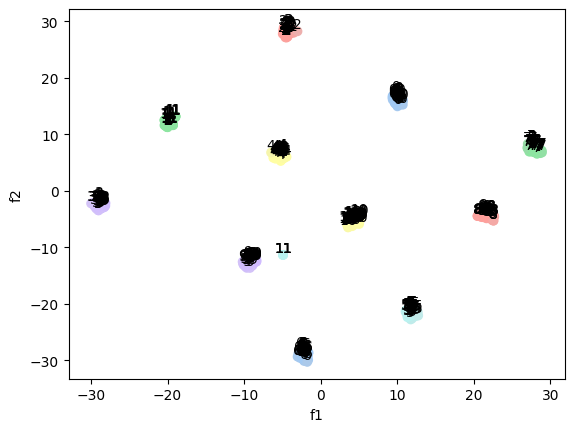

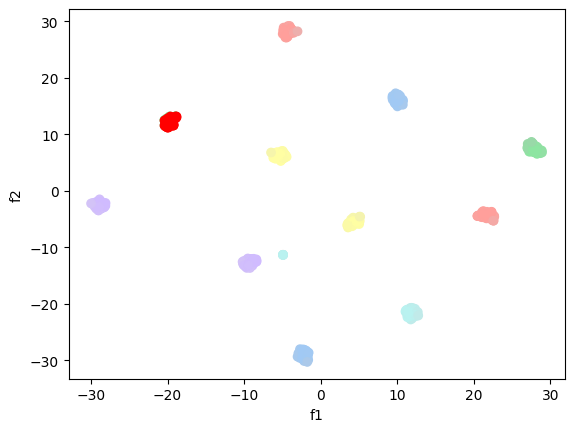

DEBUG flwr 2023-09-17 21:59:31,249 | server.py:173 | evaluate_round 13: strategy sampled 50 clients (out of 50)


['35', '29', '20', '34', '44', '25', '28', '13', '8', '22', '32', '17', '2', '18', '40', '21', '5', '38', '31', '4', '47', '11', '16', '39', '7', '37', '1', '26', '9', '3', '27', '48', '12', '43', '14', '15', '45', '33', '6', '0', '49', '24', '30', '36', '42', '41', '10', '23', '19', '46']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [121, 122, 123, 125, 126, 127, 128, 129, 161, 162, 163, 165, 166, 167, 168, 169, 191, 192, 193, 195, 196, 197, 198, 199, 261, 262, 263, 265, 266, 267, 268, 269, 291, 292, 293, 295, 296, 297, 298, 299]
[120, 121, 122, 123, 125, 126, 127, 128, 129, 160, 161, 162, 163, 165, 166, 167, 168, 169, 190, 191, 192, 193, 195, 196, 197, 198, 199, 260, 261, 262, 263, 265, 266, 267, 268, 269, 290, 291, 292, 293, 295, 296, 297, 298, 299]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6


DEBUG flwr 2023-09-17 21:59:43,341 | server.py:187 | evaluate_round 13 received 50 results and 0 failures
DEBUG flwr 2023-09-17 21:59:43,343 | server.py:222 | fit_round 14: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 21:59:55,268 | server.py:236 | fit_round 14 received 50 results and 0 failures


total selecting features


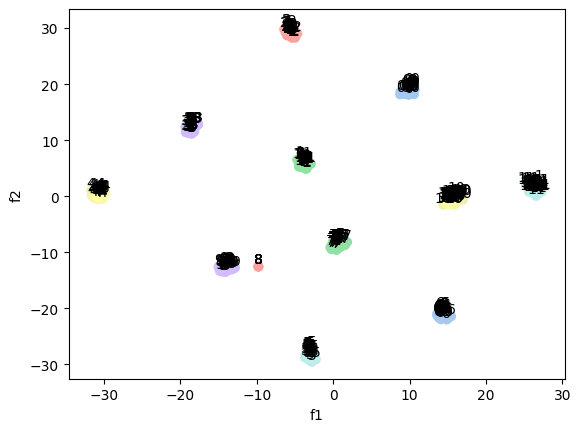

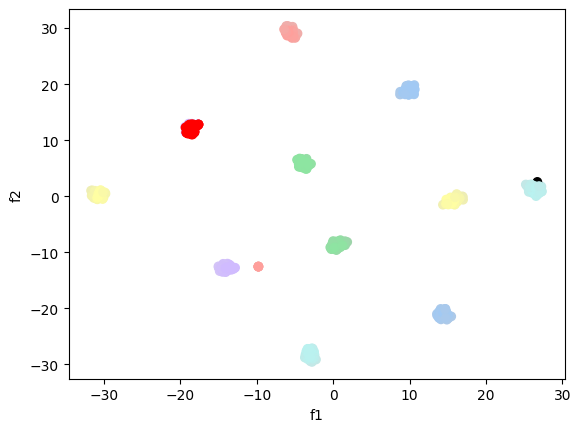

DEBUG flwr 2023-09-17 22:00:35,867 | server.py:173 | evaluate_round 14: strategy sampled 50 clients (out of 50)


['31', '3', '1', '46', '45', '28', '43', '44', '41', '10', '49', '16', '15', '42', '32', '39', '22', '4', '14', '47', '2', '9', '21', '36', '34', '29', '33', '27', '17', '8', '7', '19', '37', '5', '13', '24', '12', '38', '48', '25', '26', '11', '30', '18', '40', '35', '6', '23', '0', '20']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 171, 172, 173, 175, 176, 177, 178, 179, 201, 202, 203, 205, 206, 207, 208, 209, 331, 332, 333, 335, 336, 337, 338, 339]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 170, 171, 172, 173, 175, 176, 177, 178, 179, 200, 201, 202, 203, 205, 206, 207, 208, 209, 330, 331, 332, 333, 335, 336, 337, 338, 339]
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same:

DEBUG flwr 2023-09-17 22:00:47,361 | server.py:187 | evaluate_round 14 received 50 results and 0 failures
DEBUG flwr 2023-09-17 22:00:47,364 | server.py:222 | fit_round 15: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 22:00:59,422 | server.py:236 | fit_round 15 received 50 results and 0 failures


total selecting features


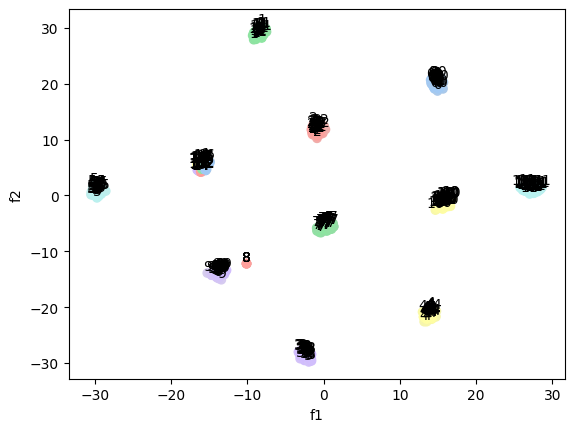

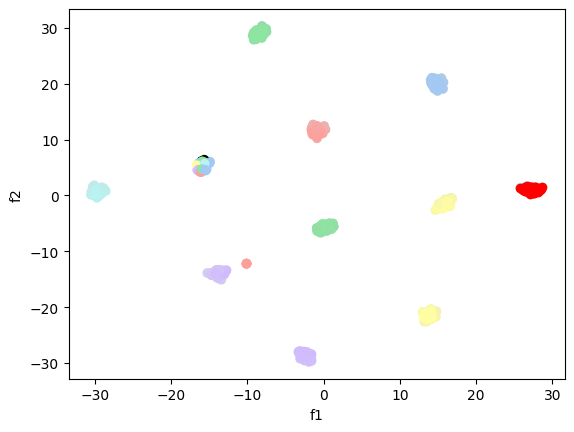

['7', '4', '42', '34', '14', '17', '3', '30', '8', '22', '35', '24', '37', '16', '28', '11', '49', '9', '41', '20', '25', '44', '23', '48', '18', '47', '21', '13', '39', '27', '31', '10', '38', '43', '45', '1', '29', '0', '36', '12', '15', '19', '5', '6', '40', '2', '32', '46', '33', '26']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
All cluster features are the 

DEBUG flwr 2023-09-17 22:01:39,587 | server.py:173 | evaluate_round 15: strategy sampled 50 clients (out of 50)
DEBUG flwr 2023-09-17 22:01:51,753 | server.py:187 | evaluate_round 15 received 50 results and 0 failures
INFO flwr 2023-09-17 22:01:51,755 | server.py:153 | FL finished in 964.4605081779882
INFO flwr 2023-09-17 22:01:51,756 | app.py:225 | app_fit: losses_distributed [(1, 0.10974119544029232), (2, 0.058096771895885475), (3, 0.03800127825140954), (4, 0.027614812225103372), (5, 0.022135145962238312), (6, 0.018591594517230987), (7, 0.01615910887718201), (8, 0.01459739451855421), (9, 0.012724144380539657), (10, 0.015129722028970716), (11, 0.010808300890028478), (12, 0.009936646617949008), (13, 0.008955079048871993), (14, 0.008540846253745255), (15, 0.009520205561071636)]
INFO flwr 2023-09-17 22:01:51,757 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-17 22:01:51,758 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.40599999999999986), (2, 0.732

Elapsed time: 978.351331949234 seconds


In [62]:
start2 = time.time()
sim2, cli_list, poison_list, poison_ids,_,_ = run_exp_type_num_rounds(num_rounds=15, trainloaders=trainloaders, valloaders=valloaders, 
                                                                 is_eliminating_clients=True, show_tsne_graphs=True)
end2 = time.time()
elapsed_time = end2 - start2
print(f"Elapsed time: {elapsed_time} seconds")

In [63]:
sim2.losses_distributed

[(1, 0.10974119544029232),
 (2, 0.058096771895885475),
 (3, 0.03800127825140954),
 (4, 0.027614812225103372),
 (5, 0.022135145962238312),
 (6, 0.018591594517230987),
 (7, 0.01615910887718201),
 (8, 0.01459739451855421),
 (9, 0.012724144380539657),
 (10, 0.015129722028970716),
 (11, 0.010808300890028478),
 (12, 0.009936646617949008),
 (13, 0.008955079048871993),
 (14, 0.008540846253745255),
 (15, 0.009520205561071636)]

In [65]:
# Your list of tuples
data2 = sim2.metrics_distributed['accuracy']

# Extract the second values from each tuple using a list comprehension
second_values = [t[1] for t in data2]

# Print the list of second values
print(second_values)

[0.40599999999999986, 0.7320000000000002, 0.8200000000000002, 0.8640000000000001, 0.8969999999999999, 0.912, 0.922, 0.9289999999999999, 0.9349999999999997, 0.912, 0.9420000000000001, 0.9420000000000001, 0.9449999999999998, 0.9479999999999998, 0.9420000000000001]


### Exp2: eval. accuracy of defence mechanism with poison ratios

In [66]:
set_constants(num_clients=10, selected_dataset='MNIST')
kwargs_train = {'poison_type': 'target_poison', 'poison_ratio': 1, 'target_label': 4, 'target_clients': [1,2,3,4,5]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = get_dataset(kwargs_train=kwargs_train, kwargs_val=kwargs_val, 
                                                    len_train_data=10000, len_test_data=1000, random_iid_ratio=1, 
                                                    is_visualize=False)

10000
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
performing targeted poisoning of labels
processing client:  2
performing targeted poisoning of labels
processing client:  3
performing targeted poisoning of labels
processing client:  4
performing targeted poisoning of labels
processing client:  5
performing targeted poisoning of labels
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning fo

INFO flwr 2023-09-17 22:40:14,569 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-09-17 22:40:21,971	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-09-17 22:40:23,017 | app.py:210 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:__internal_head__': 1.0, 'memory': 48842664347.0, 'CPU': 10.0, 'object_store_memory': 24421332172.0, 'accelerator_type:RTX': 1.0, 'node:193.1.133.164': 1.0}
INFO flwr 2023-09-17 22:40:23,019 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.1}
INFO flwr 2023-09-17 22:40:23,060 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO flwr 2023-09-17 22:40:23,062 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-17 22:40:23,063 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-09-17 22:40:23,064 | server.py:276 | Reques

Attempting to initialize parameters


INFO flwr 2023-09-17 22:40:28,696 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-09-17 22:40:28,697 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-17 22:40:28,699 | server.py:104 | FL starting
DEBUG flwr 2023-09-17 22:40:28,700 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:40:39,756 | server.py:236 | fit_round 1 received 10 results and 0 failures


total selecting features


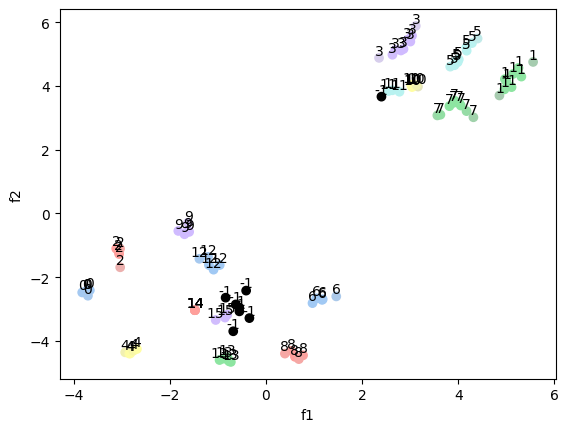

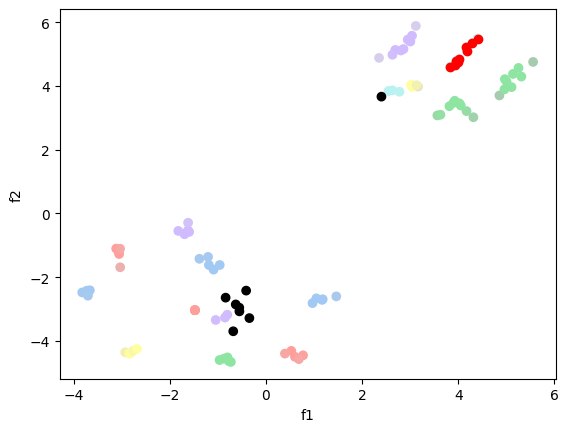

WARNING flwr 2023-09-17 22:40:49,637 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-17 22:40:49,638 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


['6', '8', '0', '7', '5', '3', '4', '1', '2', '9']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [51, 52, 53, 55, 56, 57, 58, 59]
[50, 51, 52, 53, 55, 56, 57, 58, 59]
2
All cluster features are the same: 2
3
Not all features are the same. Possible poisoning
Cluster with different features: [61, 62, 63, 65, 66, 67, 68, 69]
[60, 61, 62, 63, 65, 66, 67, 68, 69]
4
All cluster features are the same: 4
5
Not all features are the same. Possible poisoning
Cluster with different features: [81, 82, 83, 85, 86, 87, 88, 89]
[80, 81, 82, 83, 85, 86, 87, 88, 89]
6
All cluster features are the same: 6
7
Not all features are the same. Possible poisoning
Cluster with different features: [41, 42, 43, 45, 46, 47, 48, 49]
[40, 41, 42, 43, 45, 46, 47, 48, 49]
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
Not all features are the same. Possible poisoning
Cluster with different features: [73, 75, 

DEBUG flwr 2023-09-17 22:40:56,306 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:40:56,308 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:41:03,142 | server.py:236 | fit_round 2 received 10 results and 0 failures


total selecting features


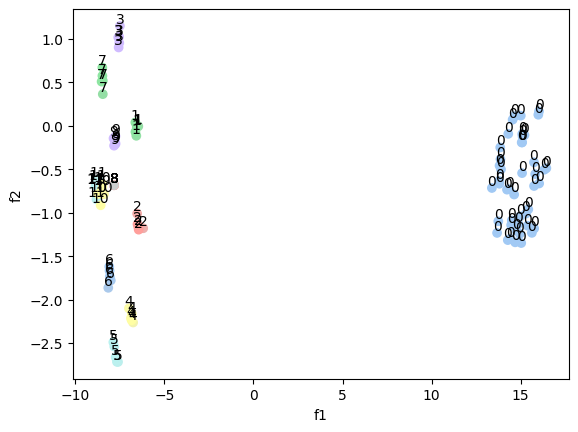

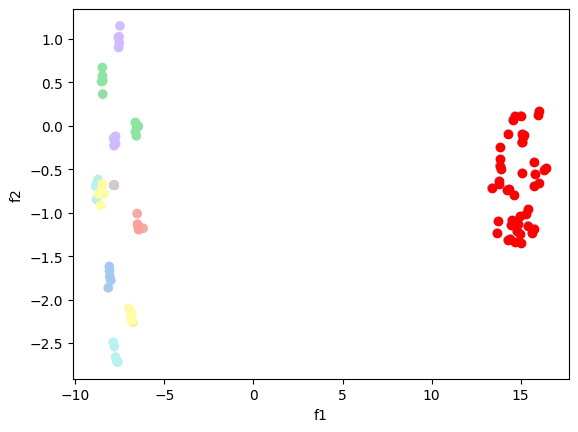

DEBUG flwr 2023-09-17 22:41:12,480 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)


['4', '7', '2', '1', '5', '8', '0', '3', '6', '9']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 71, 72, 73, 75, 76, 77, 78, 79]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 70, 71, 72, 73, 75, 76, 77, 78, 79]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'4': 9, '7': 0, '2': 9, '1': 9, '5': 9, '8': 0, '0': 0, '3': 9, '6': 0, '9': 0}
poison client ids:  [0, 2

DEBUG flwr 2023-09-17 22:41:19,064 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:41:19,066 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:41:25,870 | server.py:236 | fit_round 3 received 10 results and 0 failures


total selecting features


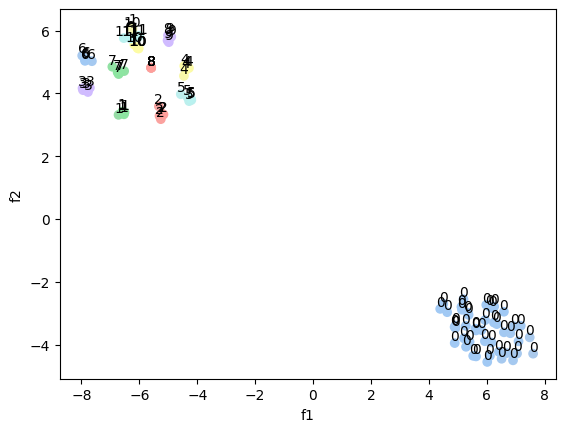

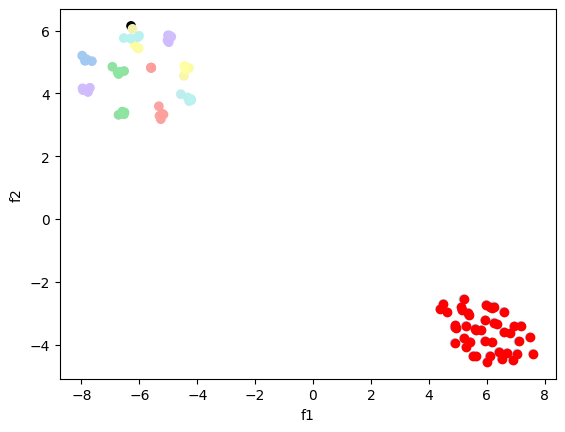

DEBUG flwr 2023-09-17 22:41:34,611 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)


['8', '3', '1', '6', '4', '0', '7', '2', '9', '5']
0
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 71, 72, 73, 75, 76, 77, 78, 79, 91, 92, 93, 95, 96, 97, 98, 99]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 70, 71, 72, 73, 75, 76, 77, 78, 79, 90, 91, 92, 93, 95, 96, 97, 98, 99]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'8': 0, '3': 9, '1': 9, '6': 0, '4': 9, '0': 0, '7': 0, '2': 9, '9': 0, '5': 9}
poison c

DEBUG flwr 2023-09-17 22:41:40,891 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:41:40,893 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:41:47,978 | server.py:236 | fit_round 4 received 10 results and 0 failures


total selecting features


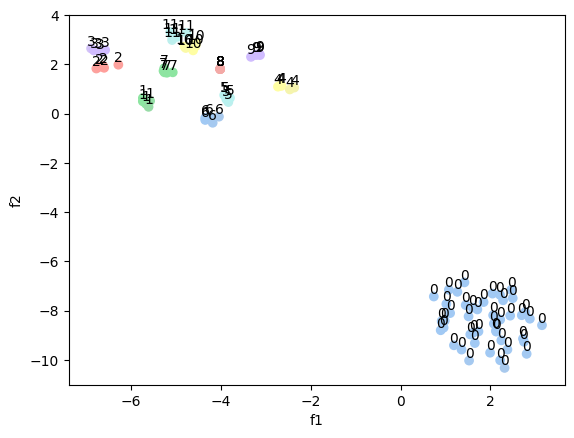

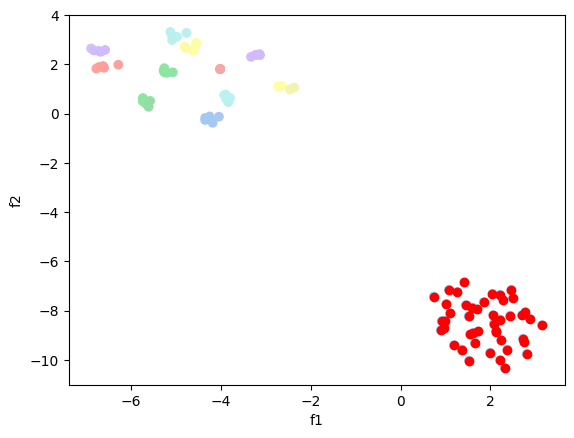

DEBUG flwr 2023-09-17 22:41:56,257 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)


['9', '6', '2', '7', '1', '8', '0', '3', '4', '5']
0
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 98, 99]
[20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'9': 0, '6': 0, '2': 9, '7': 0, '1': 9, '8': 0, '0': 0, '3': 9, '4': 9, '5': 9}
poison c

DEBUG flwr 2023-09-17 22:42:02,905 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:42:02,908 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:42:09,956 | server.py:236 | fit_round 5 received 10 results and 0 failures


total selecting features


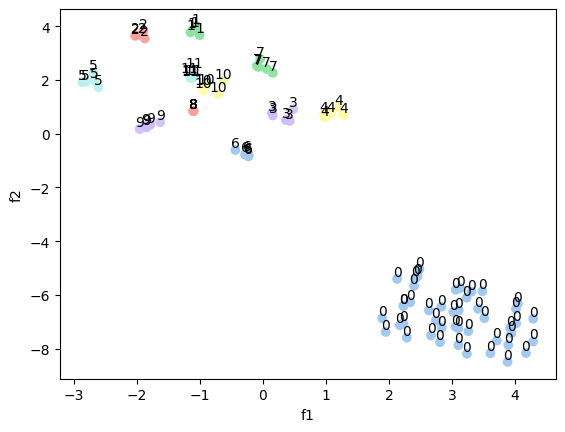

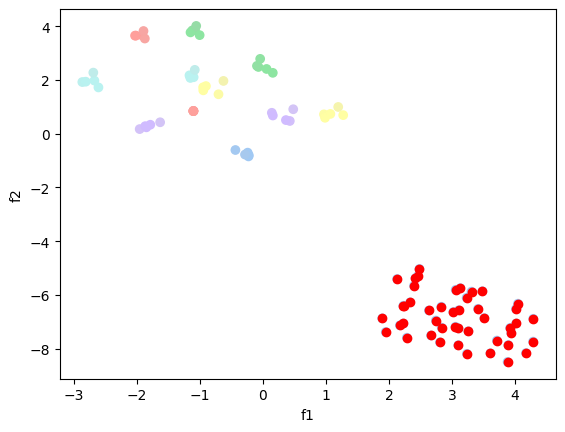

DEBUG flwr 2023-09-17 22:42:18,290 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)


['6', '1', '3', '8', '4', '5', '9', '0', '2', '7']
0
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 81, 82, 83, 85, 86, 87, 88, 89]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'6': 0, '1': 9, '3': 9, '8': 0, '4': 9, '5': 9, '9': 0, '0': 0, '2': 9, '7': 0}
poison c

DEBUG flwr 2023-09-17 22:42:24,927 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:42:24,930 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:42:31,680 | server.py:236 | fit_round 6 received 10 results and 0 failures


total selecting features


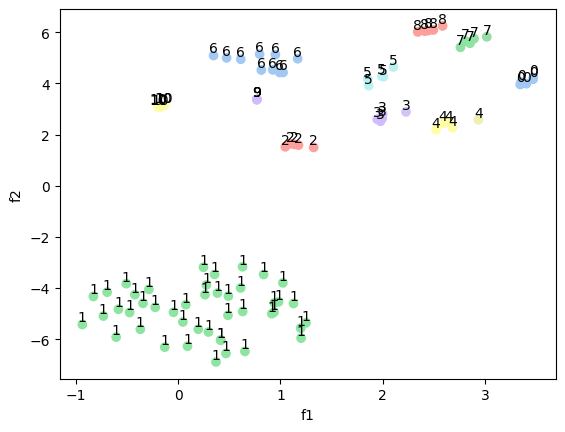

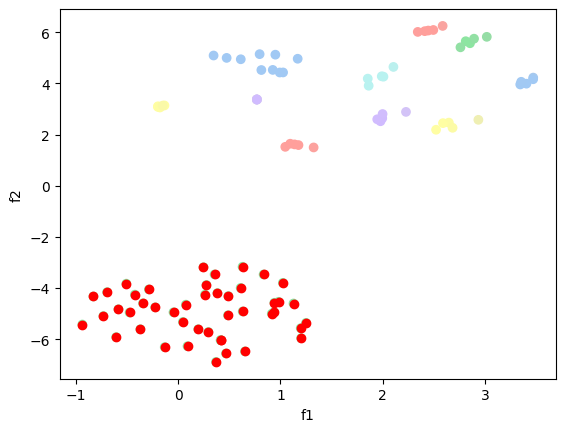

DEBUG flwr 2023-09-17 22:42:40,604 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)


['8', '1', '4', '0', '2', '9', '3', '5', '7', '6']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 77, 78, 79]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
Not all features are the same. Possible poisoning
Cluster with different features: [8, 38, 58, 88, 98]
[5, 8, 35, 38, 55, 58, 85, 88, 95, 98]
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
{'8': 2, '1': 9, '4': 9, 

DEBUG flwr 2023-09-17 22:42:47,243 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:42:47,245 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:42:54,508 | server.py:236 | fit_round 7 received 10 results and 0 failures


total selecting features


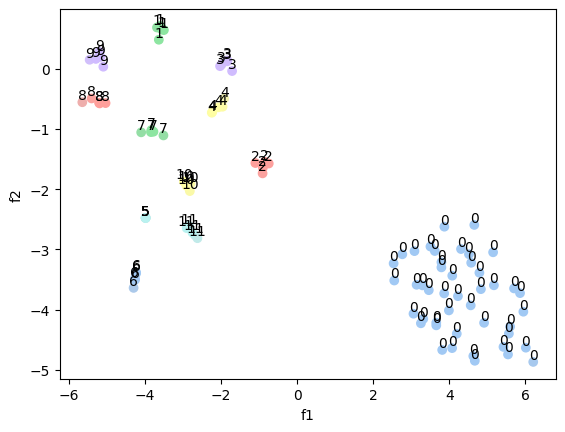

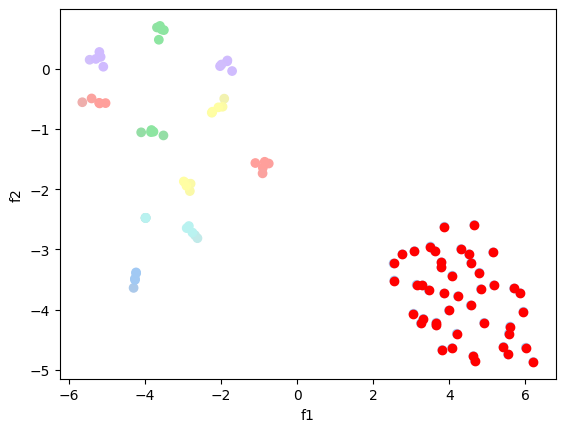

DEBUG flwr 2023-09-17 22:43:02,863 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)


['3', '1', '8', '0', '4', '9', '6', '2', '5', '7']
0
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 41, 42, 43, 45, 46, 47, 48, 49, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 40, 41, 42, 43, 45, 46, 47, 48, 49, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'3': 9, '1': 9, '8': 0, '0': 0, '4': 9, '9': 0, '6': 0, '2': 9, '5': 9, '7': 0}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 22:43:09,526 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:43:09,529 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:43:16,035 | server.py:236 | fit_round 8 received 10 results and 0 failures


total selecting features


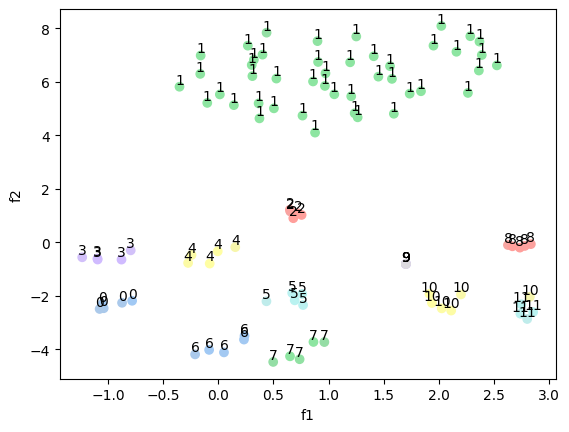

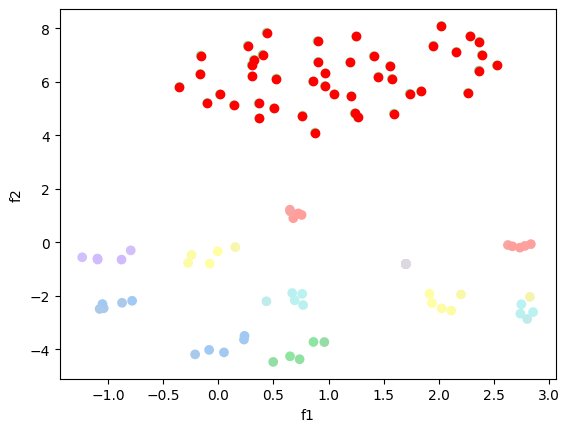

DEBUG flwr 2023-09-17 22:43:24,767 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)


['4', '5', '9', '6', '0', '1', '7', '3', '2', '8']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 51, 52, 53, 55, 56, 57, 58, 59, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 50, 51, 52, 53, 55, 56, 57, 58, 59, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
Not all features are the same. Possible poisoning
Cluster with different features: [45]
[28, 38, 45, 48, 68, 98]
11
All cluster features are the same: 11
{'4': 9, '5': 9, '9': 1, '6': 1

DEBUG flwr 2023-09-17 22:43:31,088 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:43:31,089 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:43:37,924 | server.py:236 | fit_round 9 received 10 results and 0 failures


total selecting features


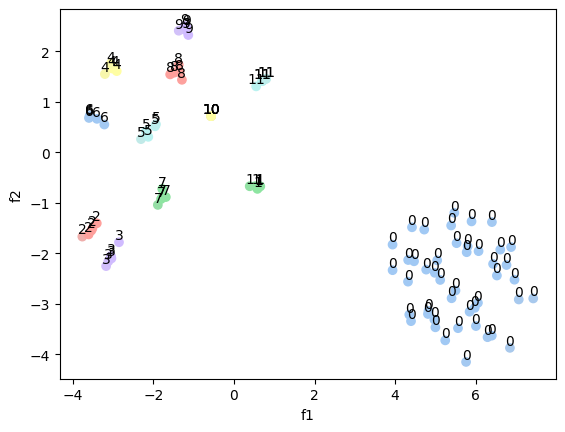

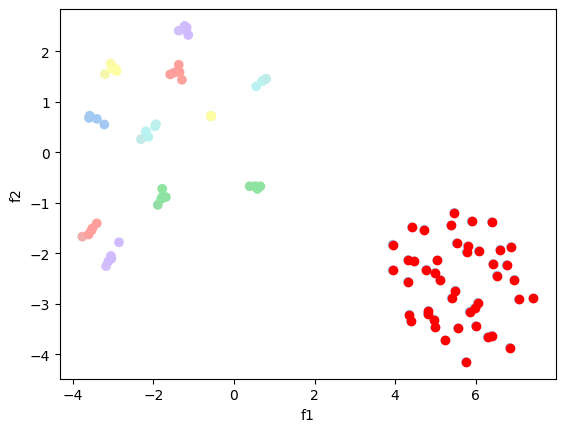

DEBUG flwr 2023-09-17 22:43:46,541 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)


['9', '5', '2', '6', '1', '0', '8', '4', '3', '7']
0
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89]
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'9': 0, '5': 9, '2': 9, '6': 0, '1': 9, '0': 0, '8': 0, '4': 9, '3': 9, '7': 0}
poison c

DEBUG flwr 2023-09-17 22:43:53,223 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:43:53,225 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:44:00,490 | server.py:236 | fit_round 10 received 10 results and 0 failures


total selecting features


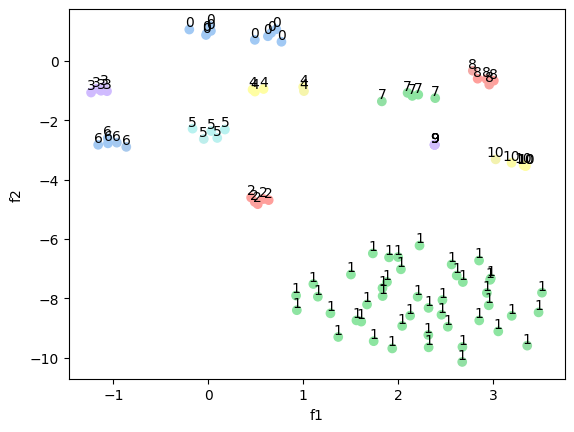

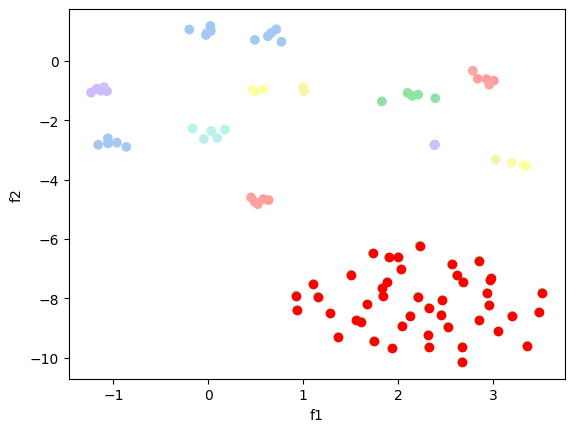

DEBUG flwr 2023-09-17 22:44:09,859 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)


['6', '4', '3', '7', '1', '2', '5', '8', '9', '0']
0
Not all features are the same. Possible poisoning
Cluster with different features: [6, 36, 76, 86, 96]
[4, 6, 34, 36, 74, 76, 84, 86, 94, 96]
1
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
{'6': 2, '4': 9, '3': 9, 

DEBUG flwr 2023-09-17 22:44:16,131 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:44:16,133 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:44:22,935 | server.py:236 | fit_round 11 received 10 results and 0 failures


total selecting features


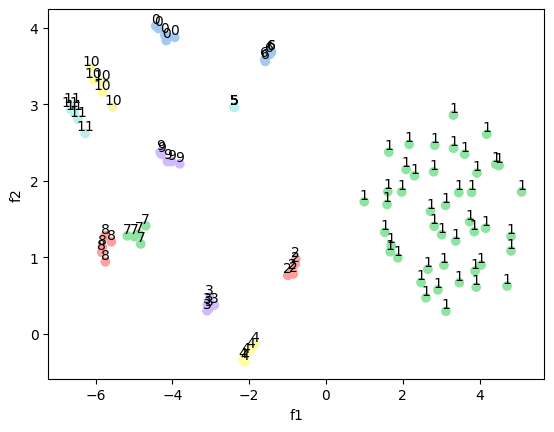

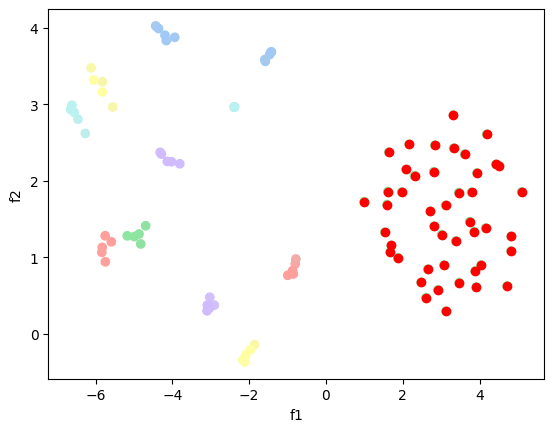

DEBUG flwr 2023-09-17 22:44:31,748 | server.py:173 | evaluate_round 11: strategy sampled 10 clients (out of 10)


['0', '7', '1', '4', '3', '9', '5', '6', '2', '8']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 61, 62, 63, 65, 66, 67, 68, 69, 81, 82, 83, 85, 86, 87, 88, 89]
[20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 60, 61, 62, 63, 65, 66, 67, 68, 69, 80, 81, 82, 83, 85, 86, 87, 88, 89]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'0': 0, '7': 0, '1': 9, '4': 9, '3': 9, '9': 0, '5': 9, '6': 0, '2': 9, '8': 0}
poison c

DEBUG flwr 2023-09-17 22:44:38,658 | server.py:187 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:44:38,660 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:44:45,375 | server.py:236 | fit_round 12 received 10 results and 0 failures


total selecting features


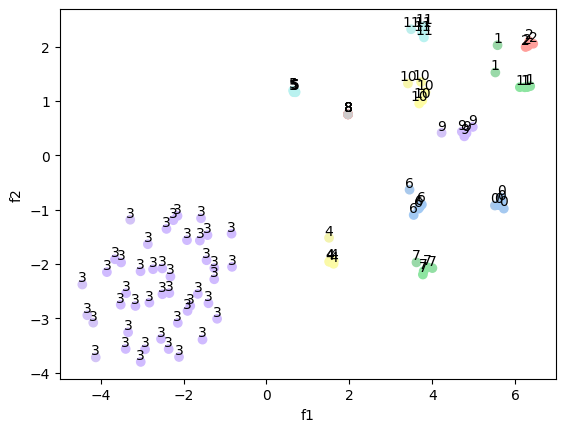

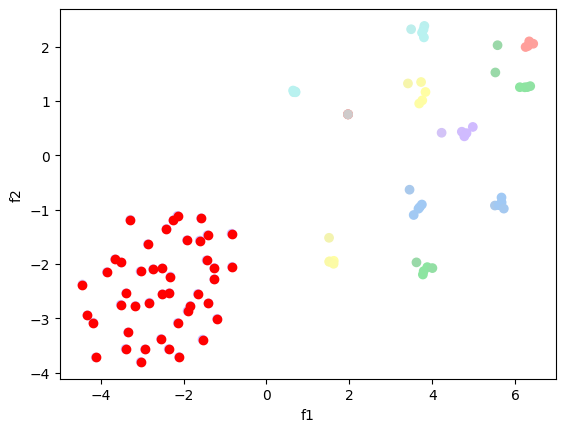

DEBUG flwr 2023-09-17 22:44:53,758 | server.py:173 | evaluate_round 12: strategy sampled 10 clients (out of 10)


['6', '4', '0', '8', '3', '2', '1', '9', '5', '7']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [26]
[4, 24, 26, 34, 74, 94]
2
All cluster features are the same: 2
3
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 81, 82, 83, 85, 86, 87, 88, 89]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 80, 81, 82, 83, 85, 86, 87, 88, 89]
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'6': 1, '4': 

DEBUG flwr 2023-09-17 22:45:00,396 | server.py:187 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:45:00,398 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:45:06,885 | server.py:236 | fit_round 13 received 10 results and 0 failures


total selecting features


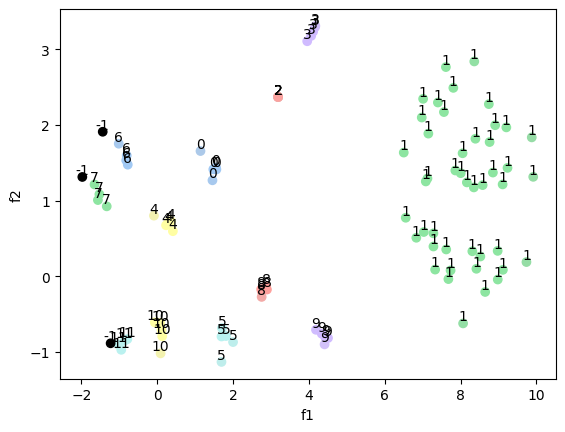

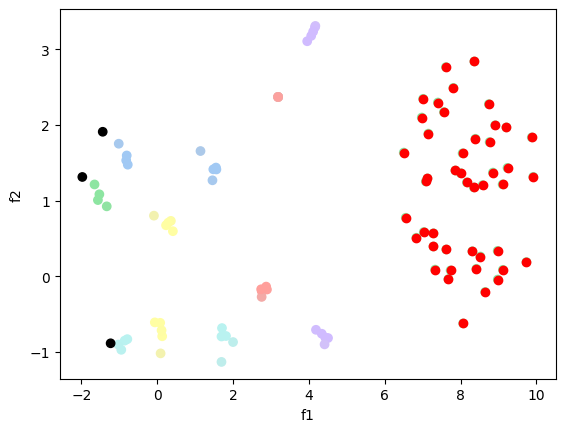

DEBUG flwr 2023-09-17 22:45:15,191 | server.py:173 | evaluate_round 13: strategy sampled 10 clients (out of 10)


['4', '2', '6', '3', '7', '8', '5', '0', '9', '1']
0
All cluster features are the same: 0
1
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 31, 32, 33, 35, 36, 37, 38, 39, 61, 62, 63, 65, 66, 67, 68, 69, 91, 92, 93, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 30, 31, 32, 33, 35, 36, 37, 38, 39, 60, 61, 62, 63, 65, 66, 67, 68, 69, 90, 91, 92, 93, 95, 96, 97, 98, 99]
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'4': 9, '2': 9, '6': 0, '3': 9, '7': 0, '8': 0, '5': 9, '0': 0, '9': 0, '1': 9}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 22:45:21,942 | server.py:187 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:45:21,943 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:45:28,713 | server.py:236 | fit_round 14 received 10 results and 0 failures


total selecting features


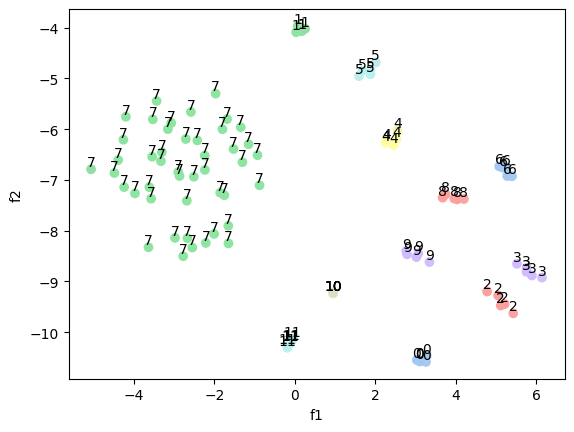

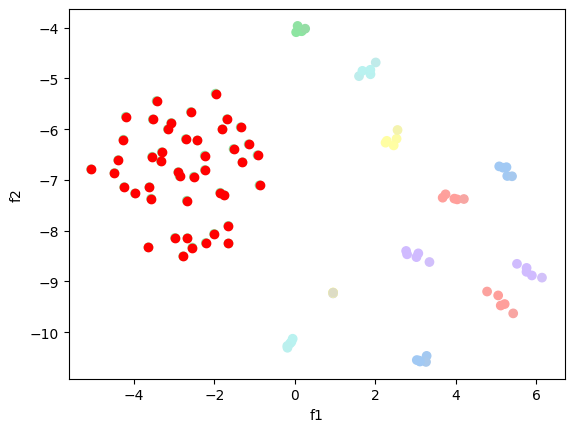

DEBUG flwr 2023-09-17 22:45:37,465 | server.py:173 | evaluate_round 14: strategy sampled 10 clients (out of 10)


['9', '1', '0', '7', '8', '3', '5', '4', '6', '2']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 15, 16, 17, 18, 19, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 75, 76, 77, 78, 79, 91, 92, 93, 95, 96, 97, 98, 99]
[10, 11, 12, 13, 15, 16, 17, 18, 19, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 90, 91, 92, 93, 95, 96, 97, 98, 99]
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'9': 0, '1': 9, '0': 0, '7': 0, '8': 0, '3': 9, '5': 9, '4': 9, '6': 0, '2': 9}
poison c

DEBUG flwr 2023-09-17 22:45:43,983 | server.py:187 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-09-17 22:45:43,985 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-17 22:45:50,480 | server.py:236 | fit_round 15 received 10 results and 0 failures


total selecting features


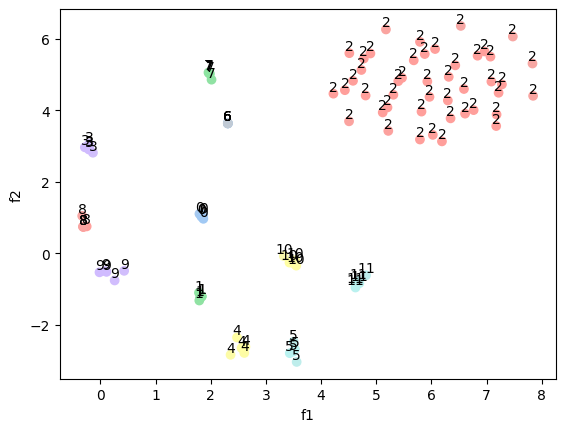

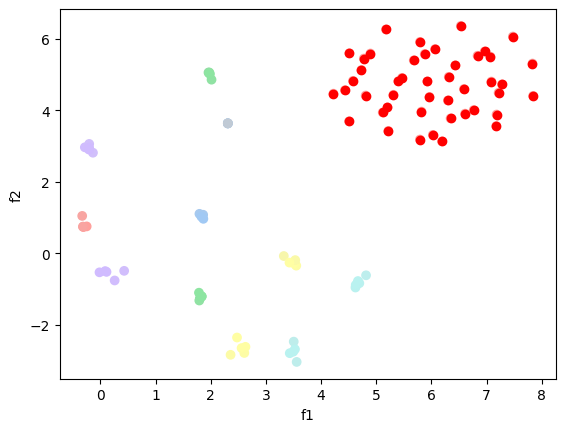

DEBUG flwr 2023-09-17 22:45:58,647 | server.py:173 | evaluate_round 15: strategy sampled 10 clients (out of 10)


['3', '5', '8', '2', '1', '6', '9', '0', '7', '4']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 91, 92, 93, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 90, 91, 92, 93, 95, 96, 97, 98, 99]
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
{'3': 9, '5': 9, '8': 0, '2': 9, '1': 9, '6': 0, '9': 0, '0': 0, '7': 0, '4': 9}
poison client ids:  [0, 1

DEBUG flwr 2023-09-17 22:46:05,205 | server.py:187 | evaluate_round 15 received 10 results and 0 failures
INFO flwr 2023-09-17 22:46:05,208 | server.py:153 | FL finished in 336.50809955457225
INFO flwr 2023-09-17 22:46:05,209 | app.py:225 | app_fit: losses_distributed [(1, 0.04593284499645234), (2, 0.01345579630881548), (3, 0.009241479231044649), (4, 0.007210609316360206), (5, 0.005625545925693587), (6, 0.005282819961430504), (7, 0.004800437291152775), (8, 0.0047390180903021245), (9, 0.004787340991068049), (10, 0.004536798822111451), (11, 0.0040160676614468685), (12, 0.004038576888058742), (13, 0.0037574676209405885), (14, 0.004056161927957875), (15, 0.004235162052886153)]
INFO flwr 2023-09-17 22:46:05,210 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-17 22:46:05,211 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.782), (2, 0.905), (3, 0.9329999999999998), (4, 0.9429999999999998), (5, 0.9570000000000001), (6, 0.9599999999999997), (7, 0.96100000000

Elapsed time: 350.68226528167725 seconds


In [67]:
start2 = time.time()
sim2, cli_list, poison_list, poison_ids,_,_ = run_exp_type_num_rounds(num_rounds=10, trainloaders=trainloaders, valloaders=valloaders, 
                                                                 is_eliminating_clients=True, show_tsne_graphs=True)
end2 = time.time()
elapsed_time = end2 - start2
print(f"Elapsed time: {elapsed_time} seconds")

In [106]:
def calc_acc_per_round(predicted_poisoners, actual_poisoners = ['1', '2', '3', '4', '5'], 
                       actual_benign = ['6','7','8','9','0']):
    # Sample lists
    all_cli = actual_poisoners + actual_benign
    predicted_benign = [val for val in all_cli if val not in predicted_poisoners]
    
    # Convert the lists to sets for efficient comparison
    poison_set = set(actual_poisoners)
    benign_set = set(actual_benign)
    predicted_poison_set = set(predicted_poisoners)
    predicted_benign_set = set(predicted_benign)
    
    # Identify common values (intersection)
    tp_items = actual_set.intersection(predicted_poison_set)
    fp_items = benign_set.intersection(predicted_poison_set)
    tn_items = benign_set.intersection(predicted_benign_set)
    fn_items = actual_set.intersection(predicted_benign_set)
    
    # Print the results
    # print("tp values:", tp_items)
    # print("fp values:", fp_items)
    # print("tn values:", tn_items)
    # print("fn values:", fn_items)
    return len(tp_items), len(fp_items), len(tn_items), len(fn_items)

In [134]:
def calc_acc_all_rounds(cli_list, poison_ids):
    tp_all=0 # classifier correctly detects poisoners
    tn_all=0 # classifier correctly detects benign clients
    fp_all=0 # classifier misclassifies benign as poisoners
    fn_all=0 # classifier misclassifies poisoners as benign
    
    tp_list=[]
    tn_list=[]
    fp_list=[]
    fn_list=[]
    
    for i in range(len(cli_list)):
        all_client_positions = list(cli_list[i].keys())
        predicted_poison_positions = poison_ids[i]
        predicted_poisoners = []
        for i in predicted_poison_positions:
            predicted_poisoners.append(all_client_positions[i])
        
        tp, fp, tn, fn = calc_acc_per_round(predicted_poisoners)
        tp_all+=tp
        fp_all+=fp
        tn_all+=tn
        fn_all+=fn
        tp_list.append(tp)
        fp_list.append(fp)
        tn_list.append(tn)
        fn_list.append(fn)
        
    list_all = [tp_all, tn_all, fp_all, fn_all]
    
    print(list_all)

    return list_all, tp_list, tn_list, fp_list, fn_list

In [135]:
calc_acc_all_rounds(cli_list, poison_ids)

[75, 75, 0, 0]


([75, 75, 0, 0],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [145]:
set_constants(num_clients=10, selected_dataset='MNIST')
kwargs_train = {'poison_type': 'target_poison', 'poison_ratio': 0.5, 'target_label': 4, 'target_clients': [1,2,3,4,5]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = get_dataset(kwargs_train=kwargs_train, kwargs_val=kwargs_val, 
                                                    len_train_data=10000, len_test_data=1000, random_iid_ratio=1, 
                                                    is_visualize=False)

10000
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
performing targeted poisoning of labels
processing client:  2
performing targeted poisoning of labels
processing client:  3
performing targeted poisoning of labels
processing client:  4
performing targeted poisoning of labels
processing client:  5
performing targeted poisoning of labels
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning fo

INFO flwr 2023-09-18 01:08:54,060 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-18 01:09:02,219	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-09-18 01:09:03,310 | app.py:210 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:193.1.133.164': 1.0, 'accelerator_type:RTX': 1.0, 'memory': 47509057536.0, 'CPU': 10.0, 'object_store_memory': 23754528768.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-09-18 01:09:03,312 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.1}
INFO flwr 2023-09-18 01:09:03,356 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO flwr 2023-09-18 01:09:03,358 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-18 01:09:03,359 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-09-18 01:09:03,360 | server.py:276 | Reques

Attempting to initialize parameters


INFO flwr 2023-09-18 01:09:09,875 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-09-18 01:09:09,877 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-18 01:09:09,878 | server.py:104 | FL starting
DEBUG flwr 2023-09-18 01:09:09,879 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:09:20,947 | server.py:236 | fit_round 1 received 10 results and 0 failures


total selecting features


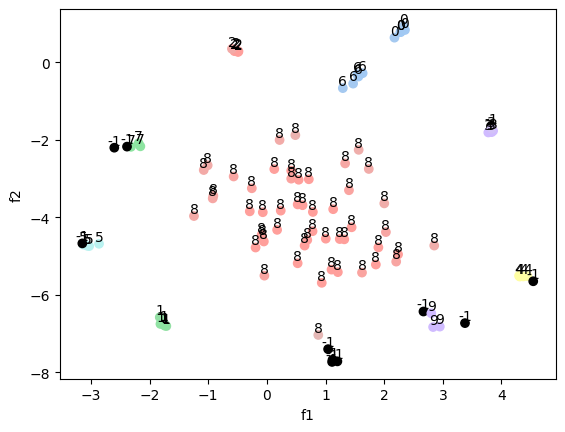

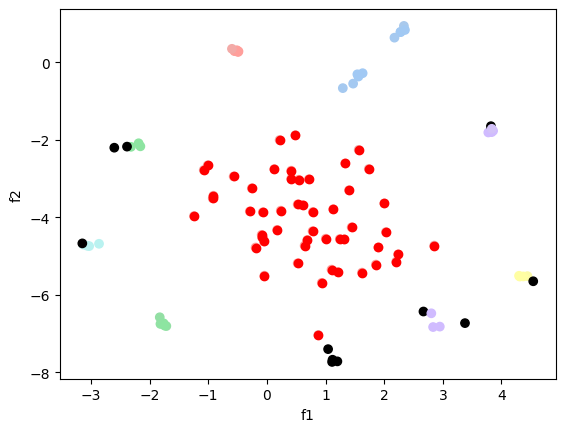

WARNING flwr 2023-09-18 01:09:29,911 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-18 01:09:29,912 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


['1', '0', '2', '6', '7', '5', '9', '4', '8', '3']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 21, 22, 23, 24, 25, 26, 27, 28, 29, 51, 52, 53, 54, 55, 56, 57, 58, 59, 71, 72, 73, 74, 75, 76, 77, 78, 79, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
9
All cluster features are the same: 9
{'1': 10, '0': 1, '2': 10, '6': 0, '7': 0, '5': 10, '9': 0, '4': 10, '8': 0, '3': 10}
poison client ids:  [0, 2, 5, 7, 9]
10
before update
rem

DEBUG flwr 2023-09-18 01:09:36,619 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:09:36,621 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:09:43,088 | server.py:236 | fit_round 2 received 10 results and 0 failures


total selecting features


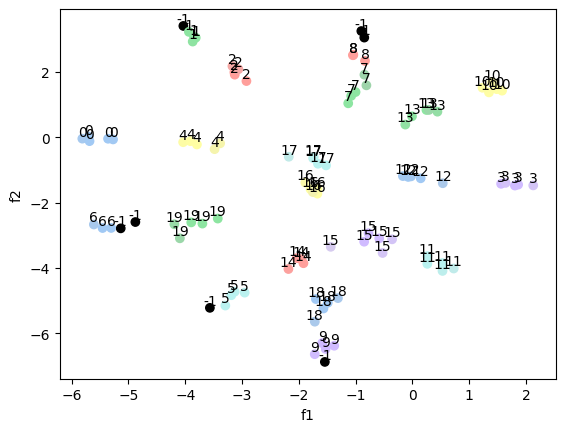

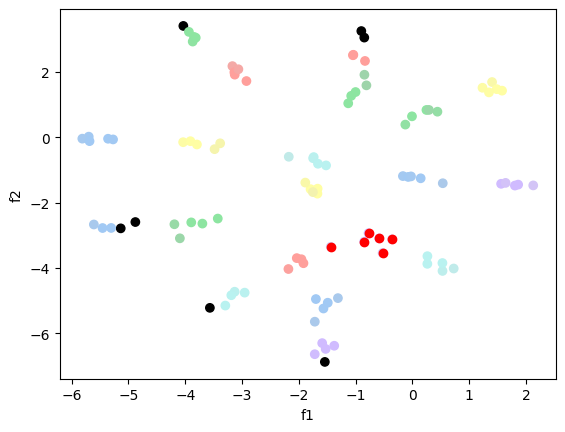

DEBUG flwr 2023-09-18 01:09:51,301 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)


['7', '4', '1', '5', '8', '6', '2', '9', '3', '0']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
Not all features are the same. Possible poisoning
Cluster with different features: [65]
[13, 23, 33, 63, 65, 83]
16
All cluster features are the same: 16
17
All cluster features are the same: 17
18
All cluster features are the same: 18
19
All cluster features are the same: 19
{'7': 0, '4': 1, '1': 1, '5': 1, '8': 0, '6': 0, '2': 2, '9': 0, '3': 1, '

DEBUG flwr 2023-09-18 01:09:58,084 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:09:58,086 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:10:05,012 | server.py:236 | fit_round 3 received 10 results and 0 failures


total selecting features


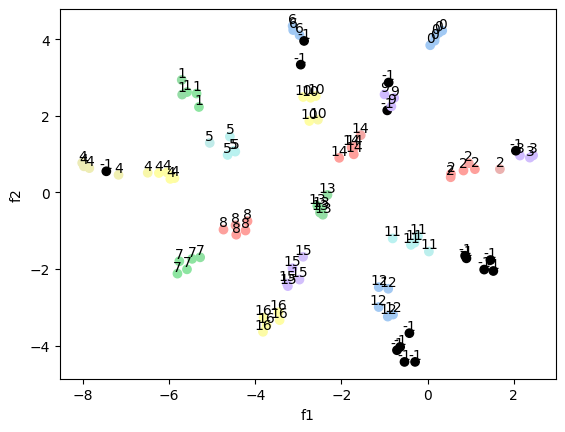

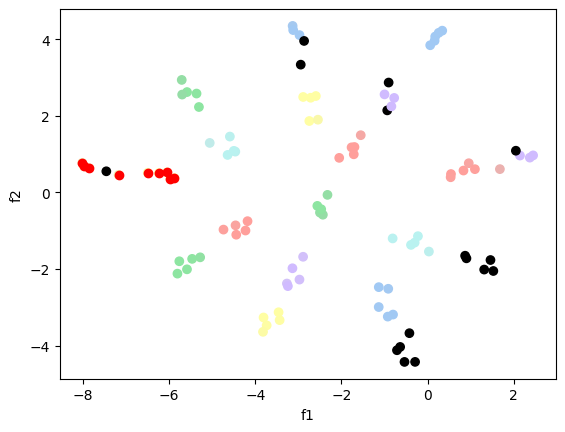

DEBUG flwr 2023-09-18 01:10:13,105 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)


['1', '2', '5', '4', '7', '8', '3', '0', '9', '6']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
{'1': 0, '2': 0, '5': 0, '4': 0, '7': 0, '8': 0, '3': 0, '0': 0, '9': 0, '6': 0}
poison client ids:  []
10
before update
10
after update


DEBUG flwr 2023-09-18 01:10:19,894 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:10:19,896 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:10:26,644 | server.py:236 | fit_round 4 received 10 results and 0 failures


total selecting features


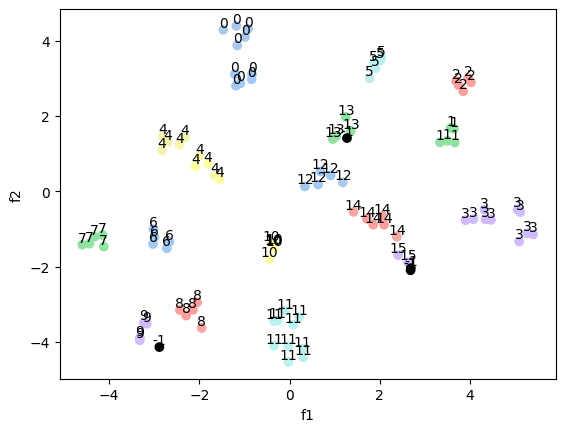

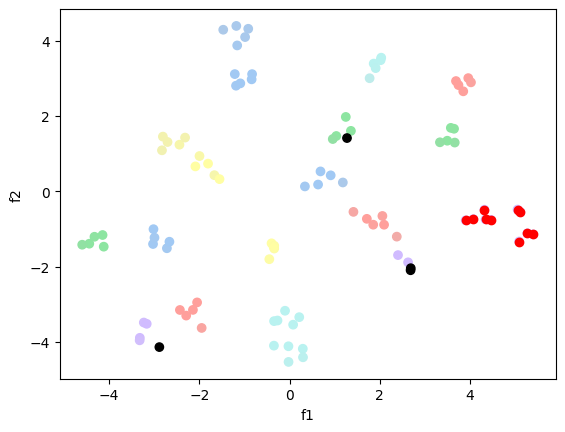

DEBUG flwr 2023-09-18 01:10:34,833 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)


['5', '3', '4', '7', '0', '2', '8', '1', '6', '9']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
{'5': 0, '3': 0, '4': 0, '7': 0, '0': 0, '2': 0, '8': 0, '1': 0, '6': 0, '9': 0}
poison client ids:  []
10
before update
10
after update


DEBUG flwr 2023-09-18 01:10:41,751 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:10:41,753 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:10:48,932 | server.py:236 | fit_round 5 received 10 results and 0 failures


total selecting features


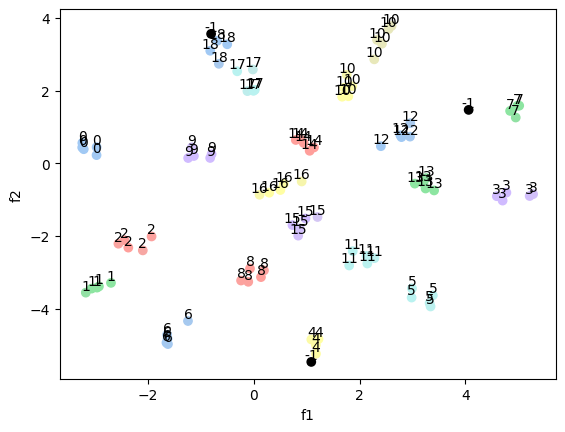

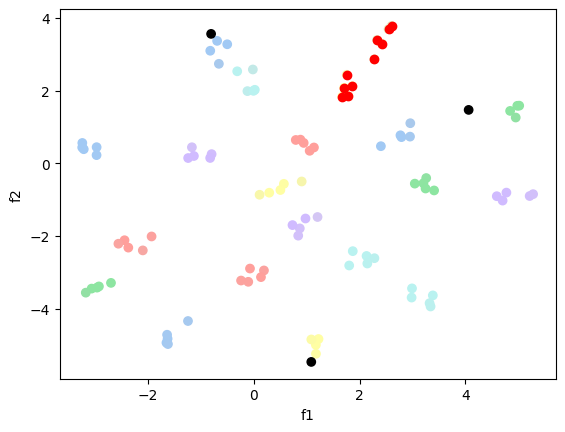

DEBUG flwr 2023-09-18 01:10:57,006 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)


['1', '6', '2', '8', '9', '4', '3', '5', '7', '0']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
All cluster features are the same: 17
18
All cluster features are the same: 18
{'1': 0, '6': 0, '2': 0, '8': 0, '9': 0, '4': 0, '3': 0, '5': 0, '7': 0, '0': 0}
poison client ids:  []
10
before update
10
after update


DEBUG flwr 2023-09-18 01:11:03,550 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:11:03,552 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:11:10,693 | server.py:236 | fit_round 6 received 10 results and 0 failures


total selecting features


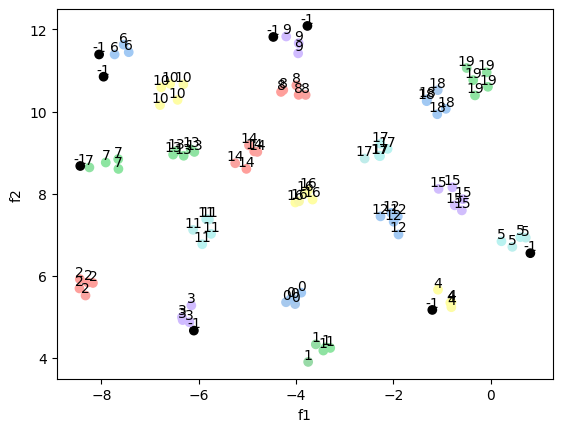

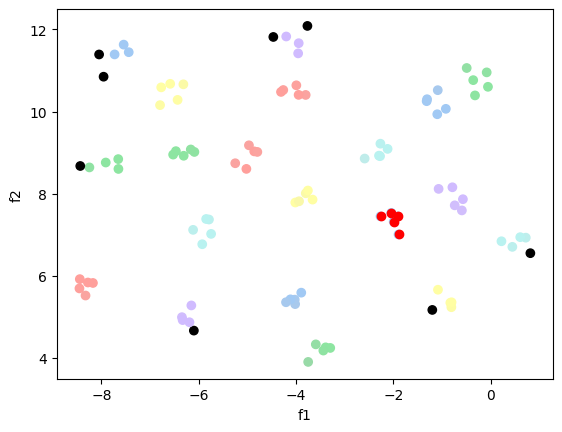

DEBUG flwr 2023-09-18 01:11:19,508 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)


['9', '6', '0', '2', '5', '7', '8', '1', '4', '3']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
All cluster features are the same: 17
18
All cluster features are the same: 18
19
All cluster features are the same: 19
{'9': 0, '6': 0, '0': 0, '2': 0, '5': 0, '7': 0, '8': 0, '1': 0, '4': 0, '3': 0}
poison client ids:  []
10
before update
10
after update


DEBUG flwr 2023-09-18 01:11:26,217 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:11:26,219 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:11:33,239 | server.py:236 | fit_round 7 received 10 results and 0 failures


total selecting features


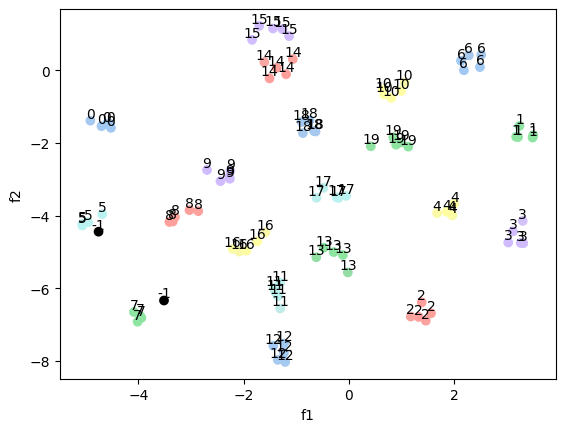

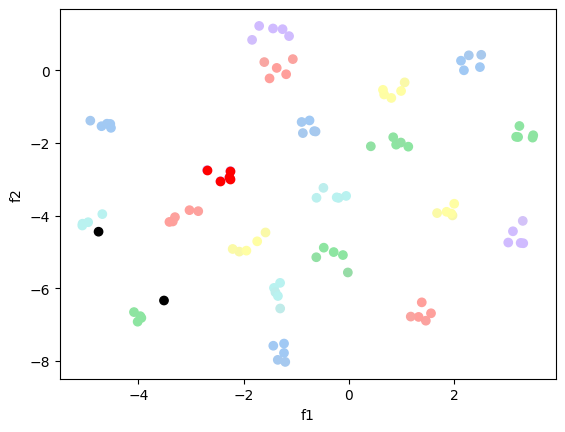

DEBUG flwr 2023-09-18 01:11:41,971 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)


['5', '6', '7', '8', '9', '2', '1', '4', '3', '0']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
All cluster features are the same: 17
18
All cluster features are the same: 18
19
All cluster features are the same: 19
{'5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '2': 0, '1': 0, '4': 0, '3': 0, '0': 0}
poison client ids:  []
10
before update
10
after update


DEBUG flwr 2023-09-18 01:11:48,248 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:11:48,250 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:11:55,277 | server.py:236 | fit_round 8 received 10 results and 0 failures


total selecting features


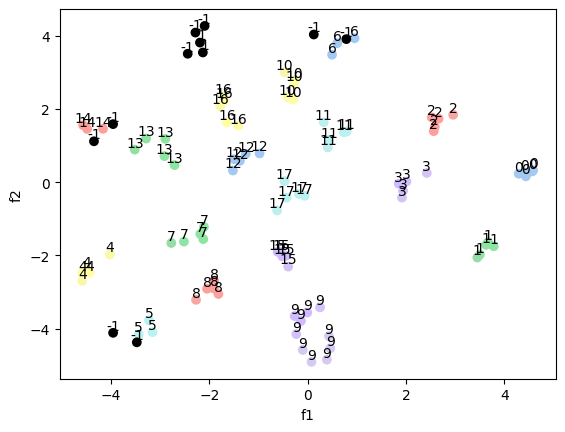

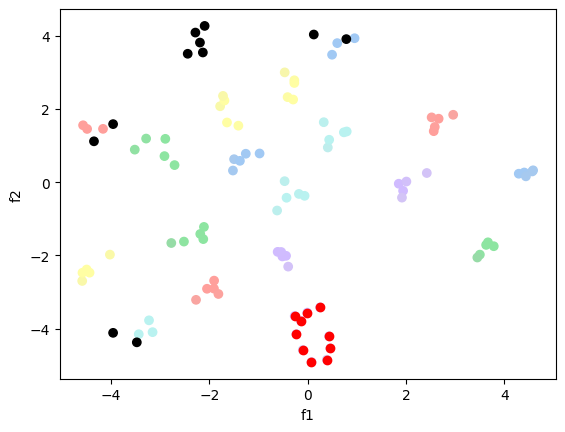

DEBUG flwr 2023-09-18 01:12:04,393 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)


['9', '4', '0', '5', '6', '3', '1', '2', '8', '7']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
All cluster features are the same: 17
{'9': 0, '4': 0, '0': 0, '5': 0, '6': 0, '3': 0, '1': 0, '2': 0, '8': 0, '7': 0}
poison client ids:  []
10
before update
10
after update


DEBUG flwr 2023-09-18 01:12:11,079 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:12:11,081 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:12:18,224 | server.py:236 | fit_round 9 received 10 results and 0 failures


total selecting features


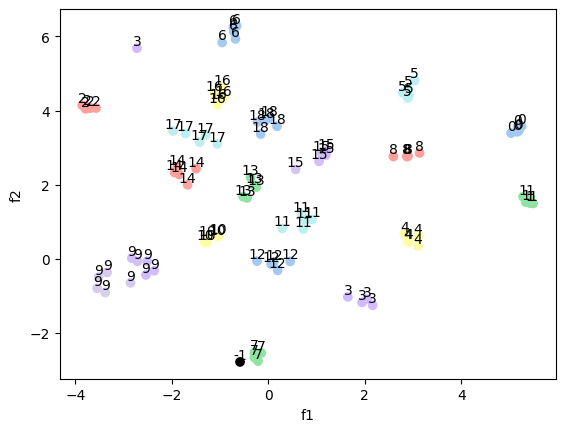

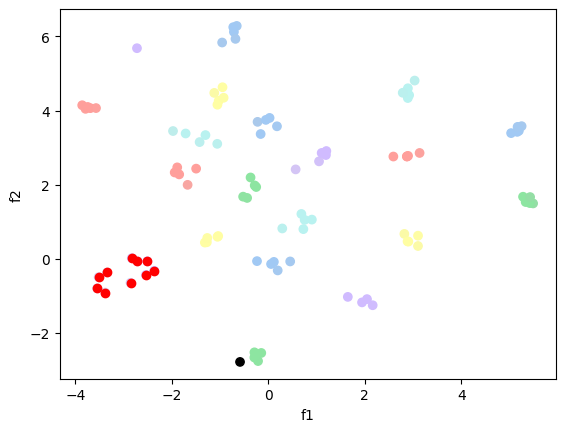

DEBUG flwr 2023-09-18 01:12:26,877 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)


['5', '9', '2', '0', '6', '7', '8', '4', '1', '3']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
All cluster features are the same: 17
18
All cluster features are the same: 18
{'5': 0, '9': 0, '2': 0, '0': 0, '6': 0, '7': 0, '8': 0, '4': 0, '1': 0, '3': 0}
poison client ids:  []
10
before update
10
after update


DEBUG flwr 2023-09-18 01:12:33,113 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:12:33,115 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:12:39,968 | server.py:236 | fit_round 10 received 10 results and 0 failures


total selecting features


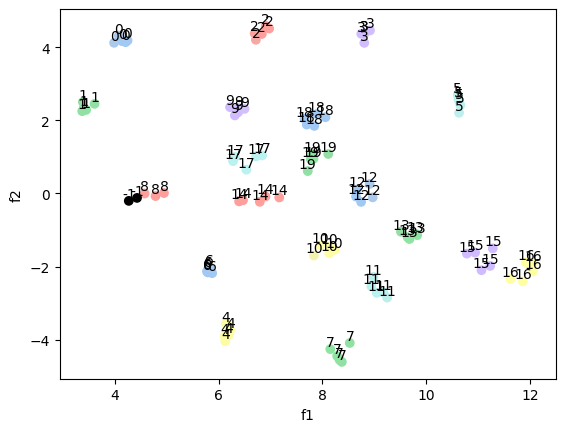

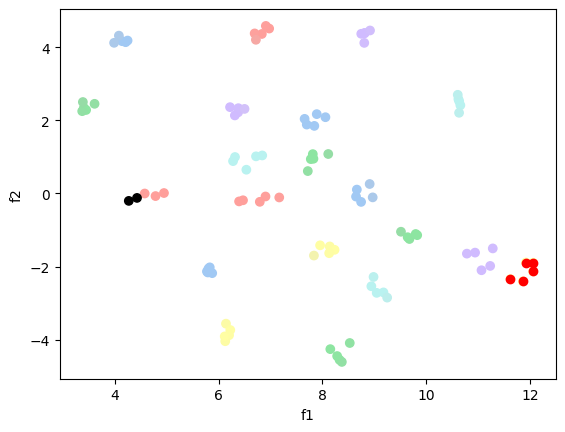

DEBUG flwr 2023-09-18 01:12:48,172 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)


['0', '4', '3', '9', '8', '6', '5', '1', '7', '2']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
All cluster features are the same: 17
18
All cluster features are the same: 18
19
All cluster features are the same: 19
{'0': 0, '4': 0, '3': 0, '9': 0, '8': 0, '6': 0, '5': 0, '1': 0, '7': 0, '2': 0}
poison client ids:  []
10
before update
10
after update


DEBUG flwr 2023-09-18 01:12:54,868 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-18 01:12:54,870 | server.py:153 | FL finished in 224.9910378260538
INFO flwr 2023-09-18 01:12:54,871 | app.py:225 | app_fit: losses_distributed [(1, 0.045790170788764954), (2, 0.03486816602945328), (3, 0.022363649010658265), (4, 0.01770946004986763), (5, 0.01442566294968128), (6, 0.012608718149363995), (7, 0.010494988851249217), (8, 0.01022568555921316), (9, 0.009680581234395505), (10, 0.009917759269475936)]
INFO flwr 2023-09-18 01:12:54,872 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-18 01:12:54,873 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.751), (2, 0.692), (3, 0.868), (4, 0.8920000000000001), (5, 0.917), (6, 0.913), (7, 0.9390000000000001), (8, 0.933), (9, 0.9330000000000002), (10, 0.9360000000000002)]}
INFO flwr 2023-09-18 01:12:54,874 | app.py:228 | app_fit: losses_centralized []
INFO flwr 2023-09-18 01:12:54,875

Elapsed time: 240.8269190788269 seconds


In [146]:
start2 = time.time()
sim2, cli_list, poison_list, poison_ids,_,_ = run_exp_type_num_rounds(num_rounds=10, trainloaders=trainloaders, valloaders=valloaders, 
                                                                 is_eliminating_clients=True, show_tsne_graphs=True)
end2 = time.time()
elapsed_time = end2 - start2
print(f"Elapsed time: {elapsed_time} seconds")

In [147]:
calc_acc_all_rounds(cli_list, poison_ids)

[5, 50, 0, 45]


([5, 50, 0, 45],
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [140]:
poison_ids

[[1, 2, 6, 8, 9], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

In [142]:
set_constants(num_clients=10, selected_dataset='MNIST')
kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 0.5, 'target_label': 4, 'target_clients': [1,2,3,4,5]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = get_dataset(kwargs_train=kwargs_train, kwargs_val=kwargs_val, 
                                                    len_train_data=10000, len_test_data=1000, random_iid_ratio=1, 
                                                    is_visualize=False)

10000
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
performing random poisoning of labels
processing client:  2
performing random poisoning of labels
processing client:  3
performing random poisoning of labels
processing client:  4
performing random poisoning of labels
processing client:  5
performing random poisoning of labels
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client: 

INFO flwr 2023-09-18 01:01:28,488 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-18 01:01:35,864	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO flwr 2023-09-18 01:01:36,936 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'CPU': 10.0, 'memory': 47519106663.0, 'accelerator_type:RTX': 1.0, 'node:193.1.133.164': 1.0, 'object_store_memory': 23759553331.0}
INFO flwr 2023-09-18 01:01:36,938 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.1}
INFO flwr 2023-09-18 01:01:36,979 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO flwr 2023-09-18 01:01:36,981 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-18 01:01:36,982 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-09-18 01:01:36,983 | server.py:276 | Reques

Attempting to initialize parameters


INFO flwr 2023-09-18 01:01:42,819 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-09-18 01:01:42,820 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-18 01:01:42,821 | server.py:104 | FL starting
DEBUG flwr 2023-09-18 01:01:42,822 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:01:53,514 | server.py:236 | fit_round 1 received 10 results and 0 failures


total selecting features


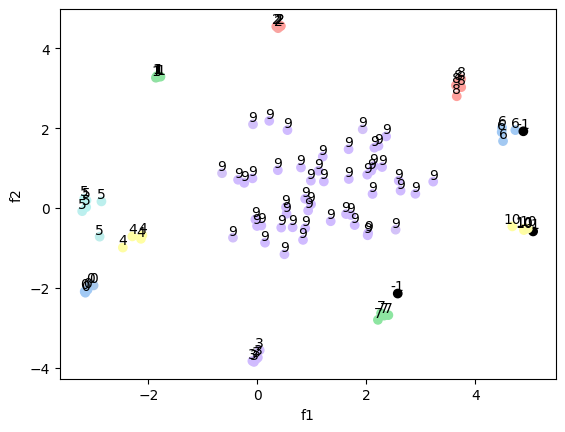

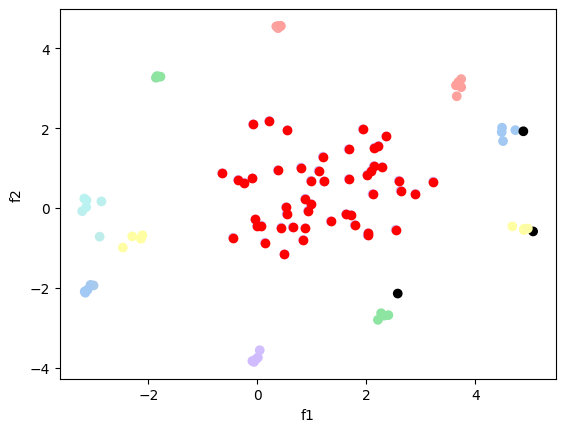

WARNING flwr 2023-09-18 01:02:02,369 | CustomFedAvg.py:143 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-18 01:02:02,371 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)


['5', '3', '7', '4', '1', '2', '8', '6', '9', '0']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
Not all features are the same. Possible poisoning
Cluster with different features: [29]
[24, 29, 64, 74, 84, 94]
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
10
All cluster features are the same: 10
{'5': 10, '3': 10, '7': 2, '4': 1

DEBUG flwr 2023-09-18 01:02:09,110 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:02:09,112 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:02:16,302 | server.py:236 | fit_round 2 received 10 results and 0 failures


total selecting features


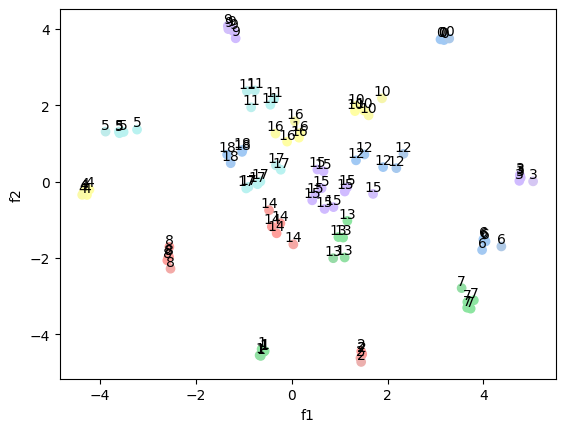

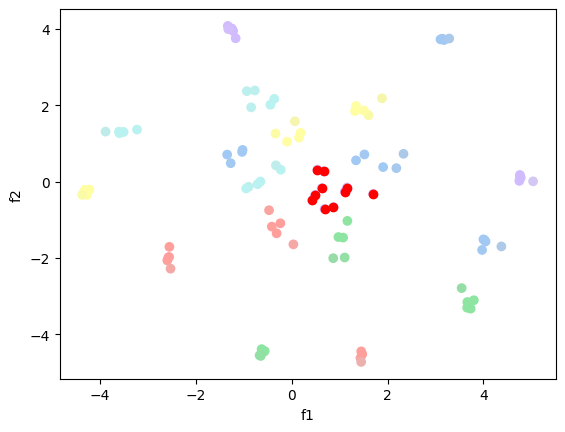

DEBUG flwr 2023-09-18 01:02:25,062 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)


['3', '8', '4', '6', '7', '5', '2', '0', '9', '1']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
Not all features are the same. Possible poisoning
Cluster with different features: [9, 29, 59, 69, 99]
[4, 9, 24, 29, 54, 59, 64, 69, 94, 99]
16
All cluster features are the same: 16
17
Not all features are the same. Possible poisoning
Cluster with different features: [65]
[0, 20, 50, 60, 65, 90]
18
All cluster features are the same: 18
{'3': 3, '8'

DEBUG flwr 2023-09-18 01:02:31,317 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:02:31,319 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:02:38,176 | server.py:236 | fit_round 3 received 10 results and 0 failures


total selecting features


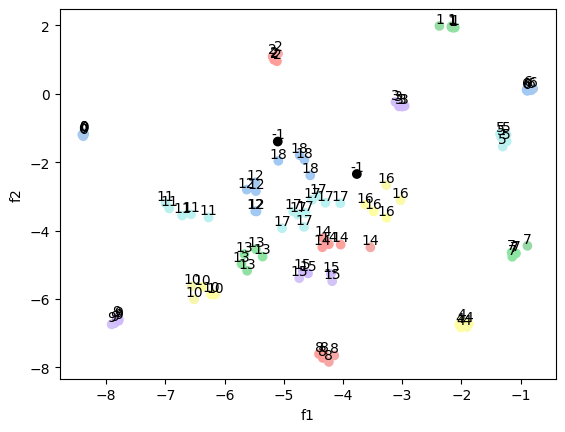

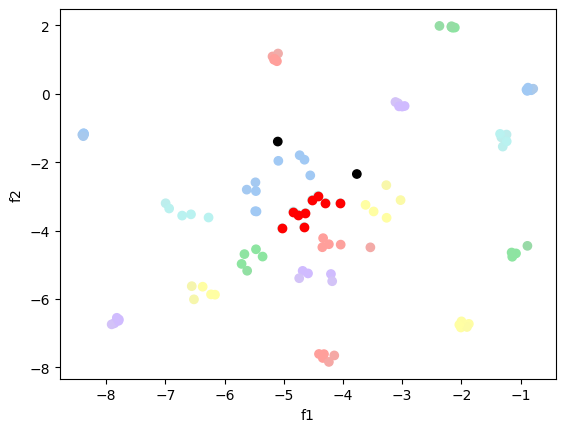

DEBUG flwr 2023-09-18 01:02:46,261 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)


['3', '0', '9', '8', '1', '7', '2', '6', '5', '4']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
11
All cluster features are the same: 11
12
All cluster features are the same: 12
13
All cluster features are the same: 13
14
All cluster features are the same: 14
15
All cluster features are the same: 15
16
All cluster features are the same: 16
17
Not all features are the same. Possible poisoning
Cluster with different features: [9, 49, 69, 89, 99]
[4, 9, 44, 49, 64, 69, 89, 94, 99]
18
All cluster features are the same: 18
{'3': 2, '0': 0, '9': 0, '8': 0, '1': 2, '7': 0, '2': 2, '6': 0, '5': 1, '4': 2}
poison cl

DEBUG flwr 2023-09-18 01:02:52,958 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:02:52,961 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:03:00,155 | server.py:236 | fit_round 4 received 10 results and 0 failures


total selecting features


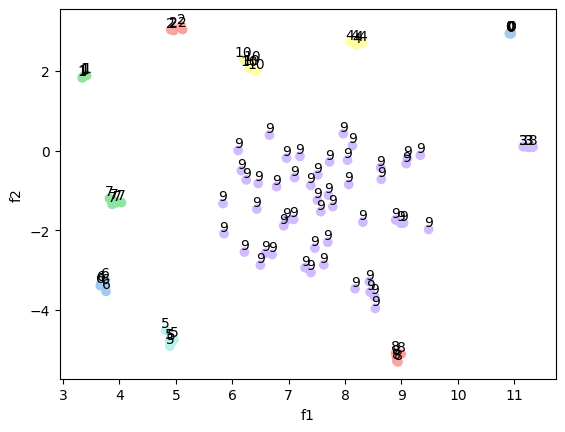

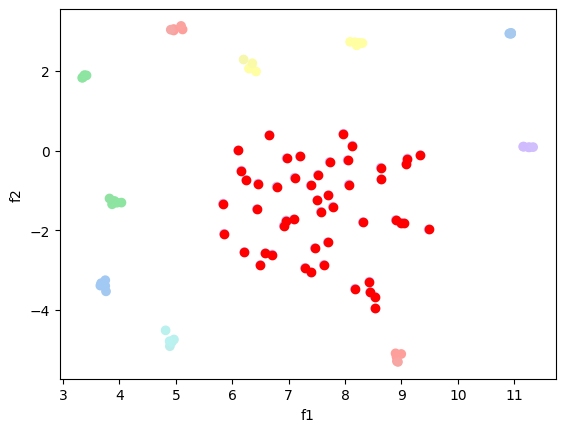

DEBUG flwr 2023-09-18 01:03:09,189 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)


['9', '2', '1', '0', '6', '7', '8', '3', '5', '4']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
10
All cluster features are the same: 10
{'9': 0, '2': 10, '1': 10, '0': 0, '6': 0, '7': 0, '8': 0, '3': 10, '5': 10, '4': 10}
pois

DEBUG flwr 2023-09-18 01:03:15,542 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:03:15,543 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:03:22,957 | server.py:236 | fit_round 5 received 10 results and 0 failures


total selecting features


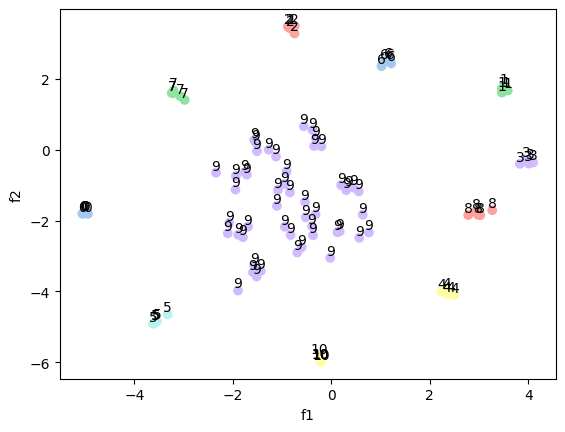

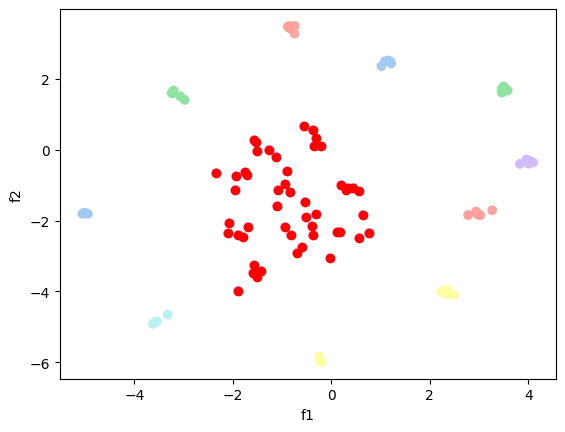

DEBUG flwr 2023-09-18 01:03:31,356 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)


['1', '5', '6', '9', '8', '4', '3', '2', '0', '7']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
10
All cluster features are the same: 10
{'1': 10, '5': 10, '6': 0, '9': 0, '8': 0, '4': 10, '3': 10, '2': 10, '0': 0, '7': 0}
poison client ids:  [0,

DEBUG flwr 2023-09-18 01:03:38,062 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:03:38,065 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:03:44,804 | server.py:236 | fit_round 6 received 10 results and 0 failures


total selecting features


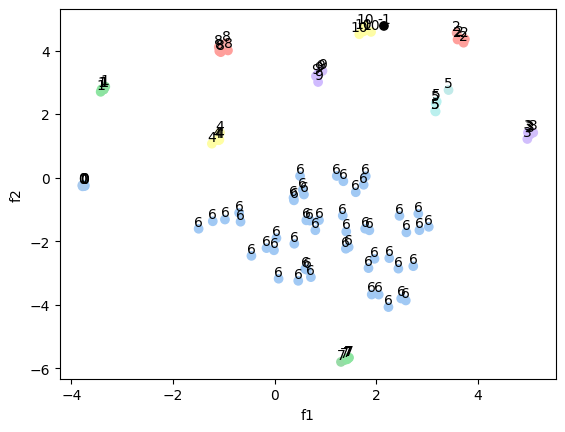

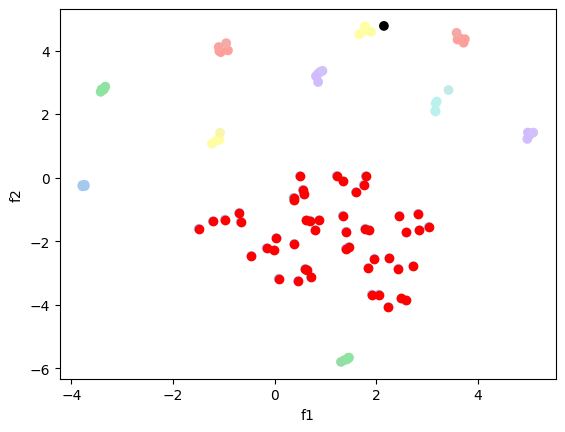

DEBUG flwr 2023-09-18 01:03:53,138 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)


['9', '6', '1', '3', '4', '2', '7', '5', '8', '0']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
{'9': 0, '6': 0, '1': 10, '3': 10, '4': 10, '2': 10, '7': 0, '5': 10, '8': 0, '0': 0}
pois

DEBUG flwr 2023-09-18 01:03:59,409 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:03:59,411 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:04:06,287 | server.py:236 | fit_round 7 received 10 results and 0 failures


total selecting features


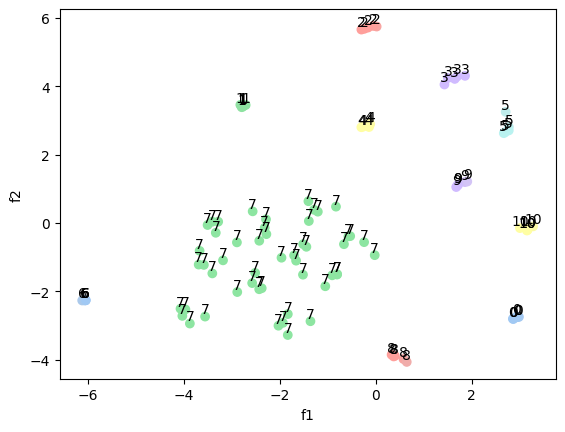

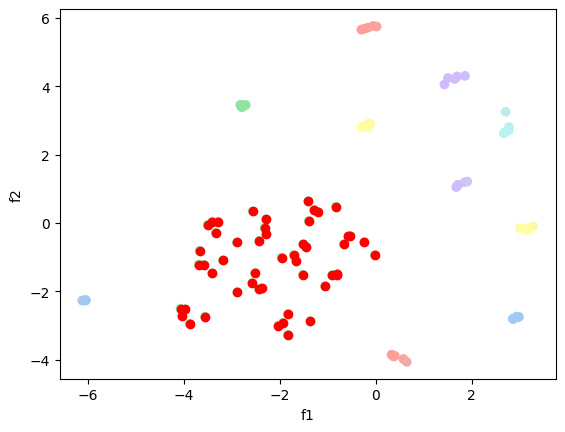

DEBUG flwr 2023-09-18 01:04:14,770 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)


['6', '1', '7', '9', '4', '0', '2', '3', '5', '8']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
Not all features are the same. Possible poisoning
Cluster with different features: [11, 12, 13, 14, 15, 16, 17, 18, 19, 41, 42, 43, 44, 45, 46, 47, 48, 49, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
{'6': 0, '1': 10, '7': 0, '9': 0, '4': 10, '0': 0, '2': 10, '3': 10, '5': 10, '8': 0}
pois

DEBUG flwr 2023-09-18 01:04:21,475 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:04:21,477 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:04:28,141 | server.py:236 | fit_round 8 received 10 results and 0 failures


total selecting features


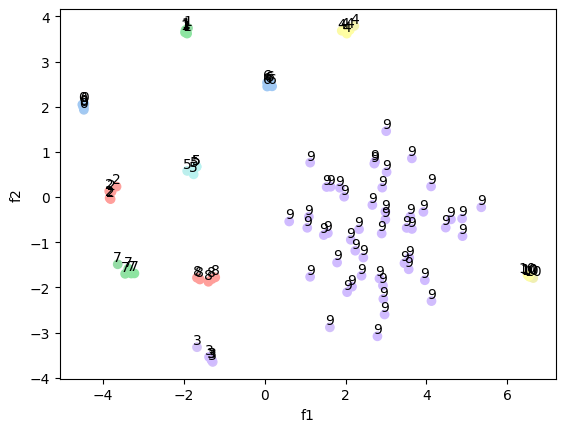

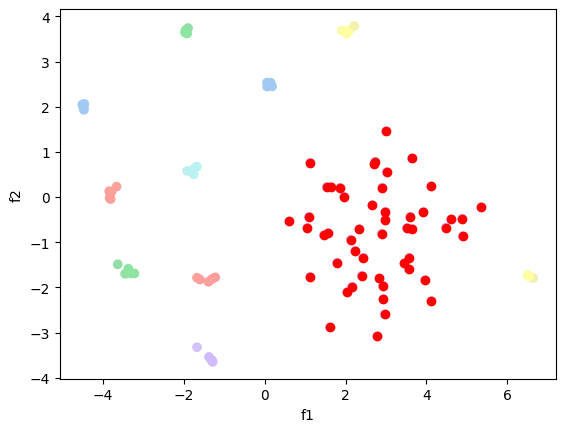

DEBUG flwr 2023-09-18 01:04:36,337 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)


['2', '6', '4', '7', '3', '0', '9', '8', '5', '1']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 21, 22, 23, 24, 25, 26, 27, 28, 29, 41, 42, 43, 44, 45, 46, 47, 48, 49, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
10
All cluster features are the same: 10
{'2': 10, '6': 0, '4': 10, '7': 0, '3': 10, '0': 0, '9': 0, '8': 0, '5': 10, '1': 10}
poison client ids:  [0,

DEBUG flwr 2023-09-18 01:04:43,273 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:04:43,275 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:04:50,459 | server.py:236 | fit_round 9 received 10 results and 0 failures


total selecting features


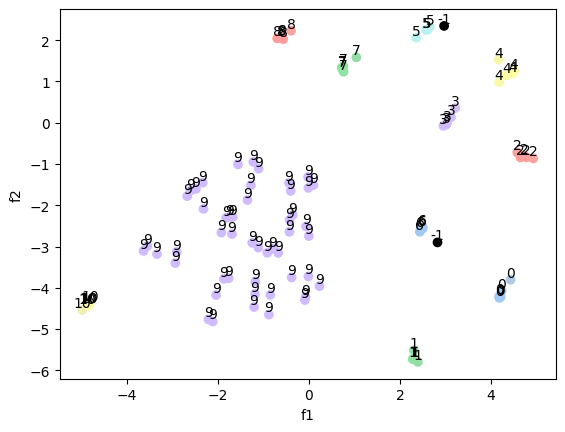

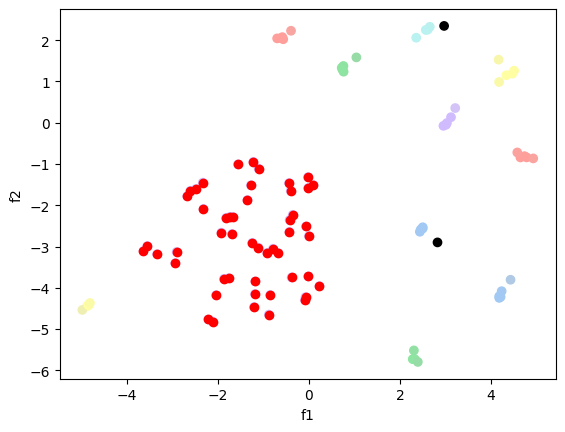

DEBUG flwr 2023-09-18 01:04:59,203 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)


['7', '0', '2', '6', '4', '3', '8', '1', '9', '5']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
All cluster features are the same: 4
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
Not all features are the same. Possible poisoning
Cluster with different features: [21, 22, 23, 24, 25, 26, 27, 28, 29, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 71, 72, 73, 74, 75, 76, 77, 78, 79, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
10
All cluster features are the same: 10
{'7': 0, '0': 0, '2': 10, '6': 0, '4': 10, '3': 10, '8': 0, '1': 10, '9': 0, '5': 10}
pois

DEBUG flwr 2023-09-18 01:05:05,868 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-18 01:05:05,870 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-09-18 01:05:12,434 | server.py:236 | fit_round 10 received 10 results and 0 failures


total selecting features


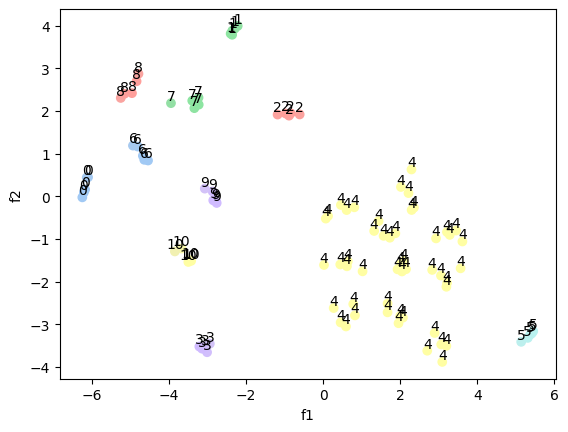

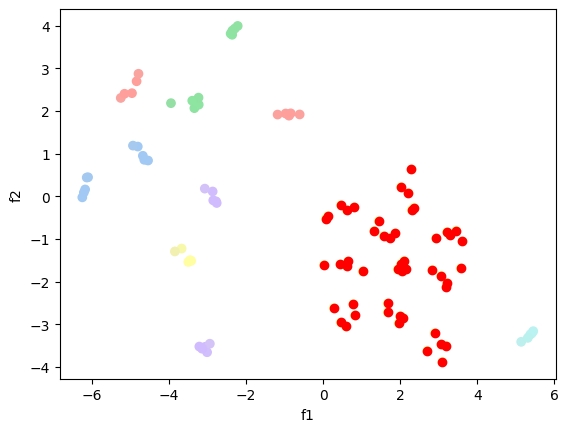

DEBUG flwr 2023-09-18 01:05:20,707 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)


['4', '8', '0', '3', '2', '5', '6', '1', '7', '9']
0
All cluster features are the same: 0
1
All cluster features are the same: 1
2
All cluster features are the same: 2
3
All cluster features are the same: 3
4
Not all features are the same. Possible poisoning
Cluster with different features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
5
All cluster features are the same: 5
6
All cluster features are the same: 6
7
All cluster features are the same: 7
8
All cluster features are the same: 8
9
All cluster features are the same: 9
10
All cluster features are the same: 10
{'4': 10, '8': 0, '0': 0, '3': 10, '2': 10, '5': 10, '6': 0, '1': 10, '7': 0, '9': 0}
poison client ids:  [0,

DEBUG flwr 2023-09-18 01:05:27,418 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-18 01:05:27,420 | server.py:153 | FL finished in 224.5981771289371
INFO flwr 2023-09-18 01:05:27,421 | app.py:225 | app_fit: losses_distributed [(1, 0.04074580007791519), (2, 0.031085980296134953), (3, 0.02214164543151855), (4, 0.00745076984167099), (5, 0.004858693708200007), (6, 0.004023562658578158), (7, 0.0034005919447517956), (8, 0.0032960872236872094), (9, 0.003164501285704318), (10, 0.002888766494288575)]
INFO flwr 2023-09-18 01:05:27,422 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-18 01:05:27,423 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.826), (2, 0.906), (3, 0.925), (4, 0.946), (5, 0.9570000000000001), (6, 0.9600000000000002), (7, 0.9640000000000001), (8, 0.969), (9, 0.9660000000000002), (10, 0.9730000000000001)]}
INFO flwr 2023-09-18 01:05:27,424 | app.py:228 | app_fit: losses_centralized []
INFO flwr 2023-09

Elapsed time: 238.95266842842102 seconds


In [143]:
start2 = time.time()
sim2, cli_list, poison_list, poison_ids,_,_ = run_exp_type_num_rounds(num_rounds=10, trainloaders=trainloaders, valloaders=valloaders, 
                                                                 is_eliminating_clients=True, show_tsne_graphs=True)
end2 = time.time()
elapsed_time = end2 - start2
print(f"Elapsed time: {elapsed_time} seconds")

In [144]:
calc_acc_all_rounds(cli_list, poison_ids)

[40, 50, 0, 10]


([40, 50, 0, 10],
 [5, 0, 0, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 5, 5, 0, 0, 0, 0, 0, 0, 0])

### Debug operation for general detection algorithm

In [394]:
set_constants(num_clients=10, selected_dataset='CIFAR-10')
kwargs_train = {'poison_type': 'target_poison', 'poison_ratio': 0.5, 'target_label': 2, 'target_clients': [1,2,3,4,5]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = get_dataset(kwargs_train=kwargs_train, kwargs_val=kwargs_val, 
                                                    len_train_data=5000, len_test_data=1000, random_iid_ratio=1, 
                                                    is_visualize=False)

5000
Files already downloaded and verified
Files already downloaded and verified
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
performing targeted poisoning of labels
processing client:  2
performing targeted poisoning of labels
processing client:  3
performing targeted poisoning of labels
processing client:  4
performing targeted poisoning of labels
processing client:  5
performing targeted poisoning of labels
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing c

In [398]:
start2 = time.time()
sim2, cli_list, poison_list, poison_ids, results, weight_results = run_exp_type_num_rounds(num_rounds=10, trainloaders=trainloaders, 
                                                                                           valloaders=valloaders, is_eliminating_clients=True, 
                                                                                           show_tsne_graphs=True)
end2 = time.time()
elapsed_time = end2 - start2
print(f"Elapsed time: {elapsed_time} seconds")

INFO flwr 2023-09-18 17:32:01,560 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-18 17:32:09,018	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 
INFO flwr 2023-09-18 17:32:10,095 | app.py:210 | Flower VCE: Ray initialized with resources: {'accelerator_type:RTX': 1.0, 'node:193.1.133.164': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'CPU': 10.0, 'memory': 46565693031.0, 'object_store_memory': 23282846515.0}
INFO flwr 2023-09-18 17:32:10,097 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.1}
INFO flwr 2023-09-18 17:32:10,140 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO flwr 2023-09-18 17:32:10,142 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-18 17:32:10,143 | CustomFedAvg.py:84 | Attempting to initialize parameters
INFO flwr 2023-09-18 17:32:10,144 | server.py:276 | Reques

Attempting to initialize parameters


INFO flwr 2023-09-18 17:32:16,558 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-09-18 17:32:16,560 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-18 17:32:16,561 | server.py:104 | FL starting
DEBUG flwr 2023-09-18 17:32:16,562 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
ERROR flwr 2023-09-18 17:32:37,342 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chamara

KeyboardInterrupt: 

In [284]:
from src.poisonDetection.xaiMetrics import get_shap_feature_list_all
from src.poisonDetection.clientAnalysis.strategyFnGeneralAlg import client_analysis_fn_general_alg_debug
import numpy as np

In [376]:
cli_list[0].keys()

dict_keys(['7', '4', '2', '8', '1', '5', '9', '0', '6', '3'])

In [377]:
client_updates_per_round = [cli_list[1]]

In [378]:
kwargs_poison = {'client_ids':['0','1','2','3','4','5','6','7','8','9'], 'explainer_type':'grad_exp', 'total_rounds': 1, 
                 'sample_count_for_plot':3, 'target_label': 3, 'is_pca': False, 'num_pca_features': 80,
          'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 10,
          'min_cluster_size':2, 'perplexity': 90,
          'show_poison_detection_graphs': True, 'malicious_start_idx':10, 'malicious_end_idx':60,'debug_info':[]}

shap_feature_ori_list_all = get_shap_feature_list_all(None, None,client_updates_per_round , **kwargs_poison)

total selecting features:  10


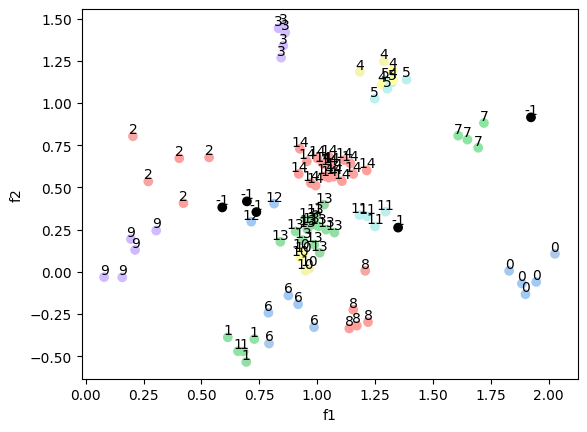

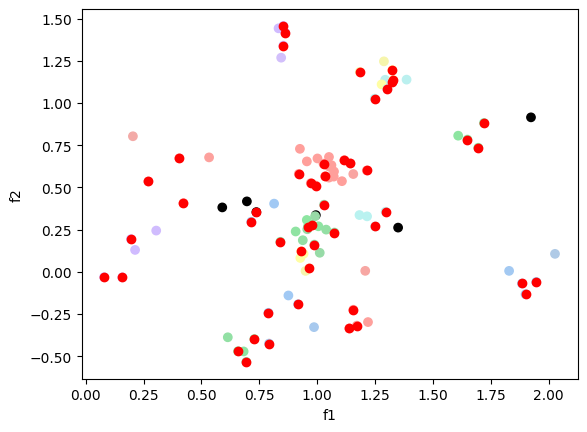

In [379]:
shap_feature_per_client, hdbscan_labels = client_analysis_fn_general_alg_debug(shap_feature_ori_list_all, client_updates_per_round, **kwargs_poison)

In [386]:
my_list = list(client_updates_per_round[0].keys())

In [388]:
# Values to find
values_to_find = ['1', '2', '3', '4', '5']

# Find the indexes of the values in the list
indexes = [i for i, value in enumerate(my_list) if value in values_to_find]
print(indexes)

[3, 5, 7, 8, 9]


In [381]:
# target_clients = list(client_updates_list[0].keys())
total_labels_per_client = 10

# get all cluster ids, ignore -1 cluster id
all_clusters_ids = np.unique(hdbscan_labels)
if np.any(all_clusters_ids == -1):
    all_clusters_ids = all_clusters_ids[all_clusters_ids != -1]

# create an empty dict of arrays to get the positions for each features to be calculated for suspicious counts
feature_positions = {}
for i in all_clusters_ids:
    feature_positions[i] = []
    
for i in range(len(hdbscan_labels)):
    if hdbscan_labels[i] in feature_positions.keys():
      feature_positions[hdbscan_labels[i]].append(i)

In [382]:
feature_positions

{0: [1, 11, 21, 41, 61],
 1: [3, 13, 23, 43, 63],
 2: [2, 12, 22, 42, 62],
 3: [7, 17, 27, 47, 67],
 4: [9, 19, 29, 49, 69],
 5: [4, 14, 24, 44, 64],
 6: [5, 15, 25, 45, 65],
 7: [6, 16, 26, 46],
 8: [8, 18, 28, 48, 68],
 9: [0, 10, 20, 40, 60],
 10: [32, 52, 72, 82, 92],
 11: [31, 51, 71, 91],
 12: [50, 70],
 13: [33, 35, 38, 53, 55, 58, 73, 75, 78, 83, 88, 93, 95, 98],
 14: [34,
  36,
  37,
  39,
  54,
  56,
  57,
  59,
  74,
  76,
  77,
  79,
  84,
  86,
  87,
  89,
  94,
  96,
  97,
  99]}

In [384]:
diff_idxes_all = []

# Main algorithm to detect poisoners: compare feature repetitions within the same cluster.
# If different features are present, possible poisoning alert
target_clients=list(client_updates_list[0].keys())
for i in all_clusters_ids:
    # List of numbers
    numbers = feature_positions[i]

    # Find the remainder when each number is divided by 10
    remainders = [num % 10 for num in numbers]
    
    # Check if all the remainders are the same
    if all(remainder == remainders[0] for remainder in remainders):
        print("All cluster features are the same:", i)
    else:
        print("Not all features are the same. Possible poisoning")
        # Find and isolate the numbers with different remainders
        different_idxes = [num for num, remainder in zip(numbers, remainders) if remainder != remainders[0]]
        # print("Cluster with different features:", different_idxes)
        diff_idxes_all.extend(numbers)

sus_ct = {}

for i in list(target_clients):
    sus_ct[i] = 0

# add a suspicious score for each client
for i in diff_idxes_all:
    sus_client_position = i//len(target_clients)
    sus_client = target_clients[sus_client_position]
    sus_ct[sus_client] +=1

# detecting poison clients
poison_clients = []
for key, value in sus_ct.items():
    if value>total_labels_per_client/2:
        poison_clients.append(key)

poison_idxes = []
idxes_to_remove = list(client_updates_list[0].keys())
for i in poison_clients:
    poison_idxes.append(idxes_to_remove.index(i))

All cluster features are the same: 0
All cluster features are the same: 1
All cluster features are the same: 2
All cluster features are the same: 3
All cluster features are the same: 4
All cluster features are the same: 5
All cluster features are the same: 6
All cluster features are the same: 7
All cluster features are the same: 8
All cluster features are the same: 9
All cluster features are the same: 10
All cluster features are the same: 11
All cluster features are the same: 12
Not all features are the same. Possible poisoning
Not all features are the same. Possible poisoning


In [385]:
poison_idxes

[3, 5, 7, 8, 9]

In [348]:
# sus_ct

In [349]:
def general_algorithm_main_calc(client_updates_list, hdbscan_labels):
  target_clients = list(client_updates_list[0].keys())
  total_labels_per_client = 10

  # get all cluster ids, ignore -1 cluster id
  all_clusters_ids = np.unique(hdbscan_labels)
  if np.any(all_clusters_ids == -1):
    all_clusters_ids = all_clusters_ids[all_clusters_ids != -1]

  # create an empty dict of arrays to get the positions for each features to be calculated for suspicious counts
  feature_positions = {}
  for i in all_clusters_ids:
    feature_positions[i] = []

  for i in range(len(hdbscan_labels)):
    if hdbscan_labels[i] in feature_positions.keys():
      feature_positions[hdbscan_labels[i]].append(i)

  diff_idxes_all = []

  # Main algorithm to detect poisoners: compare feature repetitions within the same cluster.
  # If different features are present, possible poisoning alert
  for i in all_clusters_ids:
    # List of numbers
    numbers = feature_positions[i]

    # Find the remainder when each number is divided by 10
    remainders = [num % 10 for num in numbers]

    # Check if all the remainders are the same
    if all(remainder == remainders[0] for remainder in remainders):
        print("All cluster features are the same:", i)
    else:
        print("Not all features are the same. Possible poisoning")
        # Find and isolate the numbers with different remainders
        different_idxes = [num for num, remainder in zip(numbers, remainders) if remainder != remainders[0]]
        # print("Cluster with different features:", different_idxes)
        diff_idxes_all.extend(numbers)

  sus_ct = {}

  for i in list(target_clients):
    sus_ct[i] = 0

  # add a suspicious score for each client
  for i in diff_idxes_all:
    sus_client_position = i//len(target_clients)
    sus_client = target_clients[sus_client_position]
    sus_ct[sus_client] +=1

  # detecting poison clients
  poison_clients = []
  for key, value in sus_ct.items():
    if value>total_labels_per_client/2:
        poison_clients.append(key)

  return poison_clients